#  Analyse spectra holo at AuxTel for Configurations


- author : Sylvie Dagoret-Campagne
- affiliation : IJCLab/IN2P3/CNES, DESC-LSST fullmember, behalf AuxTel Teal VERA C. Rubin observatory
- 
- creation date : November 8th  2022
- last update : November 8th 2022


- **kernel anaconda3_auxtel** at CC or **python 3** locally

# Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LogNorm
import pandas as pd

import matplotlib.ticker                         # here's where the formatter is
import os
import re
import pandas as pd

plt.rcParams["figure.figsize"] = (16,4)
plt.rcParams["axes.labelsize"] = 'xx-large'
plt.rcParams['axes.titlesize'] = 'xx-large'
plt.rcParams['xtick.labelsize']= 'xx-large'
plt.rcParams['ytick.labelsize']= 'xx-large'

In [2]:
import matplotlib.colors as colors
import matplotlib.cm as cmx
import matplotlib.gridspec as gridspec
from matplotlib.patches import Rectangle

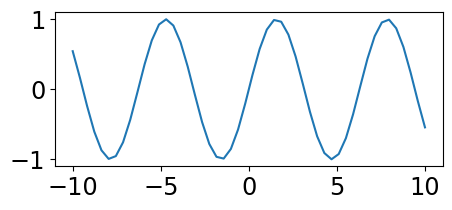

In [3]:
fig=plt.figure(figsize=(5,2))
ax=fig.add_subplot(1,1,1)
X=np.linspace(-10,10,50)
Y=np.sin(X)
ax.plot(X,Y)
plt.show()               

In [4]:
import matplotlib.offsetbox
props = dict(boxstyle='round',edgecolor="w",facecolor="w", alpha=0.5)

In [5]:
from datetime import datetime,date

In [6]:
#pip install fpdf
#from fpdf import FPDF

import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

In [7]:
today = date.today()
string_date=today.strftime("%Y-%m-%d")

In [8]:
string_date

'2022-11-08'

In [9]:
from iminuit import Minuit
import iminuit

In [10]:
iminuit.__version__

'2.17.0'

In [11]:
from astropy.io import fits
from spectractor import parameters
from spectractor.extractor.extractor import Spectractor,dumpParameters,dumpfitparameters
from spectractor.extractor.spectrum import Spectrum, detect_lines, calibrate_spectrum
from spectractor.extractor.spectrum import *
#from spectractor.extractor.spectroscopy import Lines, Line ,HALPHA, HBETA, O2_1, H2O_1,H2O_2
from spectractor.extractor.spectroscopy import Lines, Line ,HALPHA, HBETA, HGAMMA, HDELTA ,O2_1, O2_2, O2B,H2O_1, ATMOSPHERIC_LINES
from spectractor.config import load_config
from spectractor import parameters
from spectractor.extractor.images import *
from scipy import ndimage, misc
from scipy.interpolate import interp1d

In [12]:
from time import sleep

In [13]:
from astropy.time import Time
import astropy.units as u

In [14]:
import pickle

# Calibration line

In [15]:
ATMOSPHERIC_LINES_CALIB = [O2B,O2_1, O2_2]
HYDROGEN_LINES_CALIB = [HALPHA, HBETA, HGAMMA, HDELTA]

setatml = set(ATMOSPHERIC_LINES_CALIB)
sethdryl = set(HYDROGEN_LINES_CALIB )

LINES_CALIB = list(sethdryl.union(setatml))

lines_calib = Lines(LINES_CALIB , hydrogen_only=True,atmospheric_lines=True, redshift=0, emission_spectrum=False)

# Function

In [16]:
def file_tag_forsorting(filename):
    # m=re.findall('^Cor_holo4_003_.*([0-9][0-9][0-9][0-9]-[0-9][0-9]-[0-9][0-9]_.*)[.]fits$',filename)
    m = re.findall('^exposure_.*([0-9][0-9][0-9][0-9][0-9])_postisrccd.*', filename)
    if len(m)>0:
        return m[0]
    else:
        return None


In [17]:
def subdir_tag_forsorting(subdir):
    # m=re.findall('^Cor_holo4_003_.*([0-9][0-9][0-9][0-9]-[0-9][0-9]-[0-9][0-9]_.*)[.]fits$',filename)
    m = re.findall('.*([0-9][0-9][0-9][0-9][0-9])$', subdir)
    if len(m)>0:
        return m[0]
    else:
        return None


In [18]:
file_tag_forsorting('exposure_2022031600330_postisrccd.fits')

'00330'

In [19]:
subdir_tag_forsorting('2022031600330')

'00330'

# Config

In [20]:
# path index for each month
DATE="20211103"
#DATE="20211104"
#filterdispersername = "empty~holo4_003"
#filterdispersername = "BG40~holo4_003"
filterdispersername = "FELH0600~holo4_003"
imagemode = "postISRCCD"
#imagemode = "unflattened"
FLAG_RECALIB = False

In [21]:
version="v5.0"

In [22]:
#Choose the config filename
list_of_spectractorconfigfiles= ['auxtel_config_holo_DECONVOLUTION_PSF1D.ini' ,
                                 'auxtel_config_holo_DECONVOLUTION_PSF2D.ini',
                                 'auxtel_config_holo_DECONVOLUTION_FFM.ini',
                                 'auxtel_config_holo_DECONVOLUTION_PSF2DFFM.ini',
                                 'auxtel_config_holo_DECONVOLUTION_REBIN2PSF1D.ini',
                                 'auxtel_config_holo_DECONVOLUTION_REBIN2FFM.ini',
                                 'auxtel_config_holo_DECONVOLUTION_REBIN2PSF1DFFM300650.ini',
                                 'auxtel_config_holo_DECONVOLUTION_REBIN2PSF2D.ini',
                                 'auxtel_config_holo_DECONVOLUTION_REBIN2PSF1DrotA.ini',
                                 'auxtel_config_holo_DECONVOLUTION_REBIN2PSF1DrotB.ini',
                                 'auxtel_config_holo_DECONVOLUTION_REBIN2PSF1DrotC.ini',
                                 'auxtel_config_holo_DECONVOLUTION_REBIN2PSF1DrotD.ini',
                                 'auxtel_config_holo_DECONVOLUTION_PSF1D_BG40.ini',
                                 'auxtel_config_holo_DECONVOLUTION_PSF1DTRUNC.ini',
                                 'auxtel_config_holo_DECONVOLUTION_REBIN2FFMvNov2022.ini',
                                 'auxtel_config_holo_DECONVOLUTION_FFMvNov2022.ini']

config_idx = len(list_of_spectractorconfigfiles)-1
                                
configfilename= os.path.join("./config",list_of_spectractorconfigfiles[config_idx])
#configdir = (list_of_spectractorconfigfiles[config_idx].split("_")[-1]).split(".") [0]
configdir = "config_" + (list_of_spectractorconfigfiles[config_idx].split("auxtel_config_holo_")[-1]).split(".") [0]

In [23]:
configdir 

'config_DECONVOLUTION_FFMvNov2022'

In [24]:
config=configfilename
print(f">>>>> Spectractor configuration filename : {configfilename}")

>>>>> Spectractor configuration filename : ./config/auxtel_config_holo_DECONVOLUTION_FFMvNov2022.ini


In [25]:
load_config(configfilename)

No rebinning: parameters.REBIN is forced to 1.


In [26]:
configmode = list_of_spectractorconfigfiles[config_idx].split("auxtel_config_holo_DECONVOLUTION_")[-1].split(".") [0]
configmode

'FFMvNov2022'

## Parameters

In [27]:
dumpParameters()

ASTROMETRYNET_DIR 
BGD_ORDER 1
CALIB_BGD_NPARAMS 4
CALIB_BGD_ORDER 3
CALIB_BGD_WIDTH 15
CALIB_PEAK_WIDTH 7
CALIB_SAVGOL_ORDER 2
CALIB_SAVGOL_WINDOW 5
CCD_ARCSEC2RADIANS 4.84813681109536e-06
CCD_GAIN 1.1
CCD_IMSIZE 4096
CCD_MAXADU 170000
CCD_PIXEL2ARCSEC 0.0952
CCD_PIXEL2MM 0.01
CCD_REBIN 1
CONFIG_DIR /sps/lsst/groups/auxtel/softs/utils/anaconda3_nov2022/lib/python3.9/site-packages/Spectractor-2.1-py3.9.egg/spectractor/../config/
DEBUG False
DEBUG_LOGGING False
DISPERSER_DIR /sps/lsst/groups/auxtel/softs/utils/anaconda3_nov2022/lib/python3.9/site-packages/Spectractor-2.1-py3.9.egg/spectractor/extractor/dispersers/
DISPLAY True
DISTANCE2CCD 181
DISTANCE2CCD_ERR 0.4
FGB37 {'label': 'FGB37', 'min': 350, 'max': 750}
FILTERS [{'label': 'RG715', 'min': 690, 'max': 1100}, {'label': 'FGB37', 'min': 350, 'max': 750}, {'label': 'Halfa', 'min': 0.0006431, 'max': 0.0006686999999999999}, {'label': 'Z-Gunn', 'min': 800, 'max': 1100}]
FLAM_TO_ADURATE 5175865186660.421
GRATING_ORDER_2OVER1 0.1
GROOVES_

# Path

In [28]:
HOSTCC=True
LAPTOP=False

In [29]:
# Set path depending on which computer running (according HOSTCC)
if HOSTCC:
    path_auxtel="/sps/lsst/groups/auxtel"
    path_spectractor=os.path.join(path_auxtel,"softs/github/desc/Spectractor")
    path_spectractor_config=os.path.join(path_spectractor,"config")
    path_images=os.path.join(path_auxtel,"data/2022/"+filterdispersername+"/"+DATE)
    if configdir == "":
        path_output_spectractor=os.path.join(path_auxtel,"data/2022/OutputSpectractor/"+imagemode+"/"+filterdispersername+"/"+DATE)
    else:
        path_output_spectractor=os.path.join(path_auxtel,"data/2022/OutputSpectractor/"+imagemode+"/"+filterdispersername+"/"+configdir+"/"+DATE)
        path_topoutput_spectractor=os.path.join(path_auxtel,"data/2022/OutputSpectractor/"+imagemode+"/"+filterdispersername+"/"+configdir)
        path_toptopoutput_spectractor=os.path.join(path_auxtel,"data/2022/OutputSpectractor/"+imagemode+"/"+filterdispersername)
        path_toptoptopoutput_spectractor=os.path.join(path_auxtel,"data/2022/OutputSpectractor/"+imagemode)

else:
    if not LAPTOP:
        path_auxtel="/Users/sylvie/DATA/AuxTelData2022"
        path_spectractor=os.path.join(path_auxtel,"/Users/sylvie/MacOSX/GitHub/LSST/Spectractor")
        path_spectractor_config=os.path.join(path_spectractor,"config")
        path_images=os.path.join(path_auxtel,"data/2022/"+filterdispersername+"/"+DATE)
        if configdir == "":
            path_output_spectractor=os.path.join(path_auxtel,"data/2022/OutputSpectractor/"+imagemode+"/"+filterdispersername+"/"+DATE)
        else:
            path_output_spectractor=os.path.join(path_auxtel,"data/2022/OutputSpectractor/"+imagemode+"/"+filterdispersername+"/"+configdir+"/"+DATE)
            path_topoutput_spectractor=os.path.join(path_auxtel,"data/2022/OutputSpectractor/"+imagemode+"/"+filterdispersername+"/"+configdir)
            path_toptopoutput_spectractor=os.path.join(path_auxtel,"data/2022/OutputSpectractor/"+imagemode+"/"+filterdispersername)
            path_toptoptopoutput_spectractor=os.path.join(path_auxtel,"data/2022/OutputSpectractor/"+imagemode)
    else:
        path_auxtel="/Users/dagoret/DATA/AuxTelData2022"
        path_spectractor=os.path.join(path_auxtel,"/Users/dagoret/MacOSX/GitHub/LSST/Spectractor")
        path_spectractor_config=os.path.join(path_spectractor,"config")
        path_images=os.path.join(path_auxtel,"data/2022/"+filterdispersername+"/"+DATE)
        if configdir == "":
            path_output_spectractor=os.path.join(path_auxtel,"data/2022/OutputSpectractor/"+imagemode+"/"+filterdispersername+"/"+DATE)
        else:
            path_output_spectractor=os.path.join(path_auxtel,"data/2022/OutputSpectractor/"+imagemode+"/"+filterdispersername+"/"+configdir+"/"+DATE)
            path_topoutput_spectractor=os.path.join(path_auxtel,"data/2022/OutputSpectractor/"+imagemode+"/"+filterdispersername+"/"+configdir)
            path_toptopoutput_spectractor=os.path.join(path_auxtel,"data/2022/OutputSpectractor/"+imagemode+"/"+filterdispersername)
            path_toptoptopoutput_spectractor=os.path.join(path_auxtel,"data/2022/OutputSpectractor/"+imagemode)
        


In [30]:
path_output_spectractor

'/sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/FELH0600~holo4_003/config_DECONVOLUTION_FFMvNov2022/20211103'

In [31]:
! ls -l $path_output_spectractor

total 0
drwxrws--- 1 dagoret lsst 2 Nov  7 20:22 2021110300452
drwxrws--- 1 dagoret lsst 2 Nov  7 20:37 2021110300453
drwxrws--- 1 dagoret lsst 2 Nov  8 09:47 2021110300456
drwxrws--- 1 dagoret lsst 2 Nov  8 09:48 2021110300462
drwxrws--- 1 dagoret lsst 2 Nov  8 09:56 2021110300468
drwxrws--- 1 dagoret lsst 2 Nov  8 09:47 2021110300480
drwxrws--- 1 dagoret lsst 2 Nov  8 09:51 2021110300492
drwxrws--- 1 dagoret lsst 2 Nov  8 10:11 2021110300504
drwxrws--- 1 dagoret lsst 2 Nov  8 09:46 2021110300516
drwxrws--- 1 dagoret lsst 2 Nov  8 09:48 2021110300522
drwxrws--- 1 dagoret lsst 2 Nov  8 09:49 2021110300528
drwxrws--- 1 dagoret lsst 2 Nov  8 09:38 2021110300534
drwxrws--- 1 dagoret lsst 2 Nov  8 09:36 2021110300540
drwxrws--- 1 dagoret lsst 2 Nov  8 09:31 2021110300553
drwxrws--- 1 dagoret lsst 2 Nov  8 09:53 2021110300559
drwxrws--- 1 dagoret lsst 2 Nov  8 09:38 2021110300565
drwxrws--- 1 dagoret lsst 2 Nov  8 09:39 2021110300571
drwxrws--- 1 dagoret lsst 2 Nov  8 09:38 2021110300577
dr

In [32]:
# standard configuration for spectractor
#config = os.path.join(path_spectractor_config,"auxtel.ini")
#config=os.path.join("./config",configfilename)
config=configfilename
print(f">>>>> Spectractor configuration filename : {configfilename}")

>>>>> Spectractor configuration filename : ./config/auxtel_config_holo_DECONVOLUTION_FFMvNov2022.ini


In [33]:
load_config(configfilename)

No rebinning: parameters.REBIN is forced to 1.


## Logbook for file selection

In [34]:
filename_logbook='logbooks/auxtellogbook_'+filterdispersername+"_"+DATE+'_' + version+'.csv'

In [35]:
df=pd.read_csv(filename_logbook,index_col=0)

In [36]:
pd.set_option('display.max_rows', None)

In [37]:
df

,index,date,path,file,num,object,filter,disperser,airmass,exposure,...,temperature,humidity,windspd,Obj-posXpix,Obj-posYpix,Dx,Dy,skip,run,quality
0,0,2021-11-04T05:07:43.370,/sps/lsst/groups/auxtel/data/2022/FELH0600~hol...,exposure_2021110300448_postisrccd.fits,448,HD 37795,FELH0600,holo4_003,1.154825,2.0,...,7.2,33.0,6.8,NaN,NaN,NaN,NaN,,NaN,NaN
1,1,2021-11-04T05:08:20.217,/sps/lsst/groups/auxtel/data/2022/FELH0600~hol...,exposure_2021110300449_postisrccd.fits,449,HD 37795,FELH0600,holo4_003,1.153394,2.0,...,7.2,34.0,4.8,NaN,NaN,NaN,NaN,,NaN,NaN
2,2,2021-11-04T05:08:54.415,/sps/lsst/groups/auxtel/data/2022/FELH0600~hol...,exposure_2021110300450_postisrccd.fits,450,HD 37795,FELH0600,holo4_003,1.151521,2.0,...,7.2,34.0,6.0,NaN,NaN,NaN,NaN,,NaN,NaN
3,3,2021-11-04T05:11:43.527,/sps/lsst/groups/auxtel/data/2022/FELH0600~hol...,exposure_2021110300451_postisrccd.fits,451,HD 37795,FELH0600,holo4_003,1.145281,1.0,...,7.2,33.0,6.3,NaN,NaN,NaN,NaN,,NaN,NaN
4,4,2021-11-04T05:12:19.215,/sps/lsst/groups/auxtel/data/2022/FELH0600~hol...,exposure_2021110300452_postisrccd.fits,452,HD 37795,FELH0600,holo4_003,1.144045,1.0,...,7.2,33.0,6.4,NaN,NaN,NaN,NaN,,NaN,NaN
5,5,2021-11-04T05:12:52.522,/sps/lsst/groups/auxtel/data/2022/FELH0600~hol...,exposure_2021110300453_postisrccd.fits,453,HD 37795,FELH0600,holo4_003,1.142759,1.0,...,7.2,33.0,6.7,NaN,NaN,NaN,NaN,,NaN,NaN
6,6,2021-11-04T05:17:12.323,/sps/lsst/groups/auxtel/data/2022/FELH0600~hol...,exposure_2021110300455_postisrccd.fits,455,HD 38666,FELH0600,holo4_003,1.148628,1.0,...,7.3,33.0,6.3,NaN,NaN,NaN,NaN,,NaN,NaN
7,7,2021-11-04T05:17:52.968,/sps/lsst/groups/auxtel/data/2022/FELH0600~hol...,exposure_2021110300456_postisrccd.fits,456,HD 38666,FELH0600,holo4_003,1.147130,1.0,...,7.3,34.0,6.2,NaN,NaN,NaN,NaN,,NaN,NaN
8,8,2021-11-04T05:25:31.608,/sps/lsst/groups/auxtel/data/2022/FELH0600~hol...,exposure_2021110300462_postisrccd.fits,462,HD 38666,FELH0600,holo4_003,1.129715,30.0,...,7.3,31.0,5.8,NaN,NaN,NaN,NaN,,NaN,NaN
9,9,2021-11-04T05:29:35.261,/sps/lsst/groups/auxtel/data/2022/FELH0600~hol...,exposure_2021110300468_postisrccd.fits,468,HD 38666,FELH0600,holo4_003,1.121020,30.0,...,7.4,32.0,5.8,NaN,NaN,NaN,NaN,,NaN,NaN


## Selection of input files

In [38]:
df_good=df
df_good["quality"] = 1

In [39]:
for spectra_file in df_good["file"]:
    print(spectra_file)

exposure_2021110300448_postisrccd.fits
exposure_2021110300449_postisrccd.fits
exposure_2021110300450_postisrccd.fits
exposure_2021110300451_postisrccd.fits
exposure_2021110300452_postisrccd.fits
exposure_2021110300453_postisrccd.fits
exposure_2021110300455_postisrccd.fits
exposure_2021110300456_postisrccd.fits
exposure_2021110300462_postisrccd.fits
exposure_2021110300468_postisrccd.fits
exposure_2021110300474_postisrccd.fits
exposure_2021110300480_postisrccd.fits
exposure_2021110300486_postisrccd.fits
exposure_2021110300492_postisrccd.fits
exposure_2021110300498_postisrccd.fits
exposure_2021110300504_postisrccd.fits
exposure_2021110300510_postisrccd.fits
exposure_2021110300516_postisrccd.fits
exposure_2021110300522_postisrccd.fits
exposure_2021110300528_postisrccd.fits
exposure_2021110300534_postisrccd.fits
exposure_2021110300540_postisrccd.fits
exposure_2021110300552_postisrccd.fits
exposure_2021110300553_postisrccd.fits
exposure_2021110300559_postisrccd.fits
exposure_2021110300565_po

## Selection of Spectractor output files

In [40]:
# total number of exposures
NBEXP=0
# total number of exposures without dir
NBEXPNODIR=0
# total number of exposures with dir
NBEXPWTHDIR=0
# total number of exposures with plots
NBEXPWTHPLT=0
# total number of exposures with spectra
NBEXPWTHSPEC=0

# list of exposures
LISTNUM=[]
# list of exposure without dir (not run spectraction)
LISTNUMNODIR=[]
# list of exposure with dir (spectraction has been run)
LISTNUMWTHDIR=[]
# list of exposures with plots (Spectractor has run up to some point)
LISTNUMWTHPLOTS=[]
# list of exposures with spectraction output (Spectractor has completed)
LISTNUMWTHSPECTR=[]

# list of selected spectra path
List_of_spectra_path=[]

In [41]:
list_of_files=os.listdir(path_output_spectractor)
list_of_files=sorted(list_of_files)


print("list of subdir found ",list_of_files)

for subdir in list_of_files:
    
    
    #tag = file_tag_forsorting(subdir)
    tag = subdir_tag_forsorting(subdir)
    
        
    print(tag)    
    #if tag is not None and int(tag)<317:
    #    continue
    if tag is None :
        continue
  
    
    
    fulldir=os.path.join(path_output_spectractor,subdir)



    if not os.path.isdir(fulldir):
        
        print("---------------------------------------------")
        print(subdir," \t  ",tag)
        print("{} is not a directory".format(subdir))
        

        NBEXPNODIR+=1


    else:

        
        print("---------------------------------------------")
        print(subdir," \t  ",tag)
        print("{} is a directory".format(subdir))

        tagname=subdir_tag_forsorting(subdir)
        print("tagname= {}".format(tagname))
        #targetname=file_target(subdir)
        #print("targetname= {}".format(targetname))
        



        NBEXP += 1
        LISTNUM.append(tagname)



        dir_plots=os.path.join(fulldir,"plots")
        dir_spectration = os.path.join(fulldir, "basespec")

        flag_empty1 = True
        flag_empty2 = True


        if os.path.isdir(dir_plots):
            if any(os.scandir(dir_plots)):
                print("dir_plots is not empty")
                NBEXPWTHPLT+=1
                LISTNUMWTHPLOTS.append(tagname)
                flag_empty1 = False

            else:
                print("dir_plots is empty")


        if os.path.isdir(dir_spectration):
            if any(os.scandir(dir_spectration)):
                print("dir_spectration is not empty")
                NBEXPWTHSPEC+=1
                LISTNUMWTHSPECTR.append(tagname)
                flag_empty2 = False
                List_of_spectra_path.append(dir_spectration)

            else:
                print("dir_spectration is empty")

        if flag_empty1 and flag_empty2 :
            NBEXPNODIR+=1
            LISTNUMNODIR.append(tagname)
        else:
            NBEXPWTHDIR += 1
            LISTNUMWTHDIR.append(tagname)



print("-----------------------------------------------------------------")


#LISTNUM=sorted(LISTNUM)
#LISTNUMNODIR=sorted(LISTNUMNODIR)
#LISTNUMWTHDIR=sorted(LISTNUMWTHDIR)
#LISTNUMWTHPLOTS=sorted(LISTNUMWTHPLOTS)
#LISTNUMWTHSPECTR=sorted(LISTNUMWTHSPECTR)
List_of_spectra_path=sorted(List_of_spectra_path)

print("Full list of Exposures : .......................{}".format(LISTNUM))
print("Full list of Exposures without output dir: .....{}".format(LISTNUMNODIR))
print("Full list of Exposures with output dir: ....... {}".format(LISTNUMWTHDIR))
print("Full list of Exposures with output plots: ..... {}".format(LISTNUMWTHPLOTS))
print("Full list of Exposures with output spectra: ....{}".format(LISTNUMWTHSPECTR))




print("Total number of exposures : .....................{}".format(NBEXP))
print("Total number of exposures without dir : .........{}".format(NBEXPNODIR))
print("Total number of exposures with dir :.............{}".format(NBEXPWTHDIR))
print("Total number of exposures with plots : ..........{}".format(NBEXPWTHPLT))
print("Total number of exposures with spectra: .........{}".format(NBEXPWTHSPEC))


list of subdir found  ['2021110300452', '2021110300453', '2021110300456', '2021110300462', '2021110300468', '2021110300480', '2021110300492', '2021110300504', '2021110300516', '2021110300522', '2021110300528', '2021110300534', '2021110300540', '2021110300553', '2021110300559', '2021110300565', '2021110300571', '2021110300577', '2021110300583', '2021110300589', '2021110300595', '2021110300601', '2021110300607', '2021110300694', '2021110300700', '2021110300706', '2021110300712', '2021110300718', '2021110300724', '2021110300736']
00452
---------------------------------------------
2021110300452  	   00452
2021110300452 is a directory
tagname= 00452
dir_plots is not empty
dir_spectration is not empty
00453
---------------------------------------------
2021110300453  	   00453
2021110300453 is a directory
tagname= 00453
dir_plots is not empty
dir_spectration is not empty
00456
---------------------------------------------
2021110300456  	   00456
2021110300456 is a directory
tagname= 00456


In [42]:
#dir_spectra="outputs_reprocess"
print(List_of_spectra_path)

['/sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/FELH0600~holo4_003/config_DECONVOLUTION_FFMvNov2022/20211103/2021110300452/basespec', '/sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/FELH0600~holo4_003/config_DECONVOLUTION_FFMvNov2022/20211103/2021110300453/basespec', '/sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/FELH0600~holo4_003/config_DECONVOLUTION_FFMvNov2022/20211103/2021110300456/basespec', '/sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/FELH0600~holo4_003/config_DECONVOLUTION_FFMvNov2022/20211103/2021110300462/basespec', '/sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/FELH0600~holo4_003/config_DECONVOLUTION_FFMvNov2022/20211103/2021110300468/basespec', '/sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/FELH0600~holo4_003/config_DECONVOLUTION_FFMvNov2022/20211103/2021110300480/basespec', '/sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/FELH0600~holo4_003/config_DECONVOLU

In [43]:
config

'./config/auxtel_config_holo_DECONVOLUTION_FFMvNov2022.ini'

## Extraction of spectra

In [44]:
all_files_spectra = []
all_files_spectrogram = []
all_files_lines = []
all_files_table = []

# loop on topdir
for dir_spectra in List_of_spectra_path:
    for filename in os.listdir(dir_spectra):
        if re.search("_spectrum.fits$",filename):
            the_file_spectrum=os.path.join(dir_spectra,filename)
            all_files_spectra.append(the_file_spectrum)
            the_file_spectrogram=the_file_spectrum.replace("_spectrum","_spectrogram")
            all_files_spectrogram.append(the_file_spectrogram)
            the_file_lines=the_file_spectrum.replace("_spectrum.fits","_lines.csv")
            all_files_lines.append(the_file_lines)
            the_file_table=the_file_spectrum.replace("_spectrum.fits","_table.csv")
            all_files_table.append(the_file_table)
    

In [45]:
all_files_spectra[:3]

['/sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/FELH0600~holo4_003/config_DECONVOLUTION_FFMvNov2022/20211103/2021110300452/basespec/exposure_2021110300452_postisrccd_spectrum.fits',
 '/sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/FELH0600~holo4_003/config_DECONVOLUTION_FFMvNov2022/20211103/2021110300453/basespec/exposure_2021110300453_postisrccd_spectrum.fits',
 '/sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/FELH0600~holo4_003/config_DECONVOLUTION_FFMvNov2022/20211103/2021110300456/basespec/exposure_2021110300456_postisrccd_spectrum.fits']

In [46]:
all_files_spectrogram[:3]

['/sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/FELH0600~holo4_003/config_DECONVOLUTION_FFMvNov2022/20211103/2021110300452/basespec/exposure_2021110300452_postisrccd_spectrogram.fits',
 '/sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/FELH0600~holo4_003/config_DECONVOLUTION_FFMvNov2022/20211103/2021110300453/basespec/exposure_2021110300453_postisrccd_spectrogram.fits',
 '/sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/FELH0600~holo4_003/config_DECONVOLUTION_FFMvNov2022/20211103/2021110300456/basespec/exposure_2021110300456_postisrccd_spectrogram.fits']

In [47]:
all_files_lines[:3]

['/sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/FELH0600~holo4_003/config_DECONVOLUTION_FFMvNov2022/20211103/2021110300452/basespec/exposure_2021110300452_postisrccd_lines.csv',
 '/sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/FELH0600~holo4_003/config_DECONVOLUTION_FFMvNov2022/20211103/2021110300453/basespec/exposure_2021110300453_postisrccd_lines.csv',
 '/sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/FELH0600~holo4_003/config_DECONVOLUTION_FFMvNov2022/20211103/2021110300456/basespec/exposure_2021110300456_postisrccd_lines.csv']

In [48]:
all_files_table[:3] 

['/sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/FELH0600~holo4_003/config_DECONVOLUTION_FFMvNov2022/20211103/2021110300452/basespec/exposure_2021110300452_postisrccd_table.csv',
 '/sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/FELH0600~holo4_003/config_DECONVOLUTION_FFMvNov2022/20211103/2021110300453/basespec/exposure_2021110300453_postisrccd_table.csv',
 '/sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/FELH0600~holo4_003/config_DECONVOLUTION_FFMvNov2022/20211103/2021110300456/basespec/exposure_2021110300456_postisrccd_table.csv']

## Selection of good spectra

In [49]:
all_good_spectra_spectrum_files = sorted(all_files_spectra)

In [50]:
N=len(all_good_spectra_spectrum_files)

# wavelength bin colors
jet = plt.get_cmap('jet')
cNorm = colors.Normalize(vmin=0, vmax=N)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
all_colors = scalarMap.to_rgba(np.arange(N), alpha=1)

## One Spectrum

9 ) exposure_2021110300522_postisrccd_spectrum.fits   /sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/FELH0600~holo4_003/config_DECONVOLUTION_FFMvNov2022/20211103/2021110300522/basespec/exposure_2021110300522_postisrccd_spectrum.fits
No rebinning: parameters.REBIN is forced to 1.


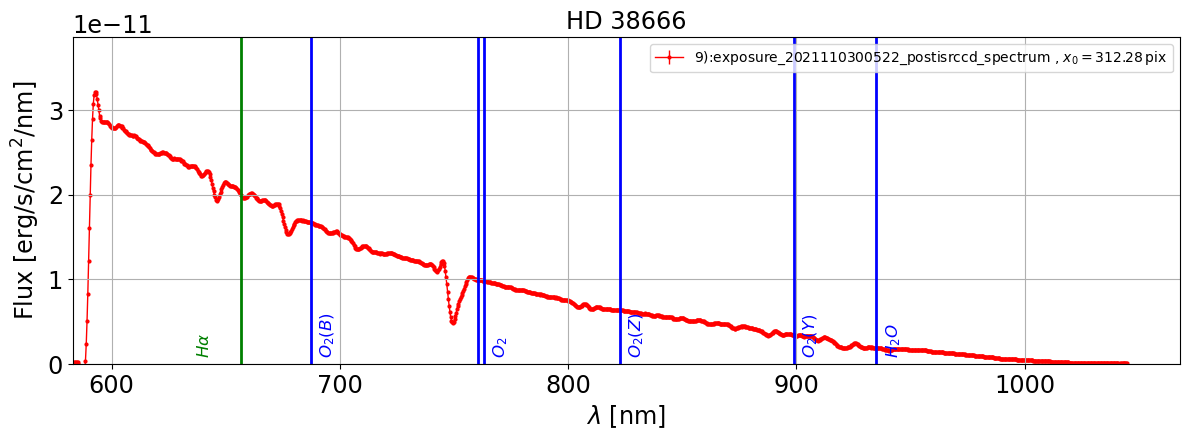

In [51]:
#idx=7 # Big Shift
#idx = 8 # Shift, I don't know why
idx = 9 # OK
#idx = 10 # OK
#idx = 11 # OK
#idx = 12 # 0K
#idx = 13 # strange shift after recalib
#idx = 14 # OK
#idx = 15 # Shift
#idx = 16 # BAD Spectrum Nothing
#idx = 17 # OK
#idx = 18 # trange shift after recalib
#idx = 19 # OK
#idx = 20 # OK
#idx = 21 # OK
#idx = 22 # BAD Spectrum
#idx = 24 # OK


fullfilename = all_good_spectra_spectrum_files[idx]
    
filename = os.path.basename(fullfilename)
print(idx,")",filename," ",fullfilename)
    
    
fig=plt.figure(figsize=(12,12))
ax1 = fig.add_subplot(3, 1, 1)
    
filename= os.path.basename(fullfilename)
tag=file_tag_forsorting(filename.split(".")[0])

    
   
     
s=Spectrum(fullfilename, config=config,fast_load=False)
label=filename.split('.')[0]+" "
label = str(idx) +"):"+label
#s.plot_spectrum(ax=ax1,force_lines=True,label=label)
s.plot_spectrum(ax=ax1,force_lines=True,label=label)

   
if FLAG_RECALIB: 
    parameters.DEBUG=True
    parameters.LIVE_FIT=True
    ax2 = fig.add_subplot(3, 1, 2)
    print(" === RECALIBRATE lines === ")
    s.lines = lines_calib
    newlambdas = calibrate_spectrum(s, with_adr=True)
    label=str(idx) +"):"+filename.split('.')[0]+" recalibrated"
    s.plot_spectrum(ax=ax2,force_lines=True,label=label)
    t=s.lines.print_detected_lines(print_table=True)
    print(t["Shift"])
    print(t["Chisq"])
    
    ax3 = fig.add_subplot(3, 1, 3)
    ax3.plot(newlambdas,s.data,"r-")
    s.lines.plot_detected_lines(ax=ax3)
    s.lines.plot_atomic_lines(ax=ax3,force=True)
    ax3.set_xlim(parameters.LAMBDA_MIN, parameters.LAMBDA_MAX)
    ax3.grid()
    
    

plt.show()
    

In [52]:
parameters.DEBUG=False
parameters.LIVE_FIT=False

## All Spectra

============================ 0 ) exposure_2021110300452_postisrccd_spectrum.fits   /sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/FELH0600~holo4_003/config_DECONVOLUTION_FFMvNov2022/20211103/2021110300452/basespec/exposure_2021110300452_postisrccd_spectrum.fits ==============================
No rebinning: parameters.REBIN is forced to 1.


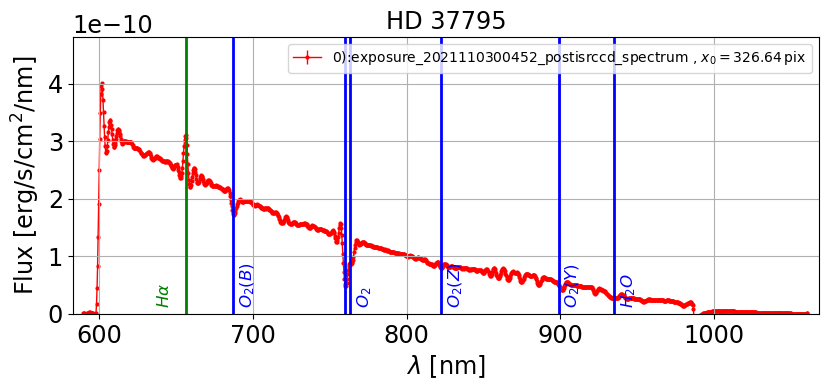

=== ORIGINAL CALIB lines === 


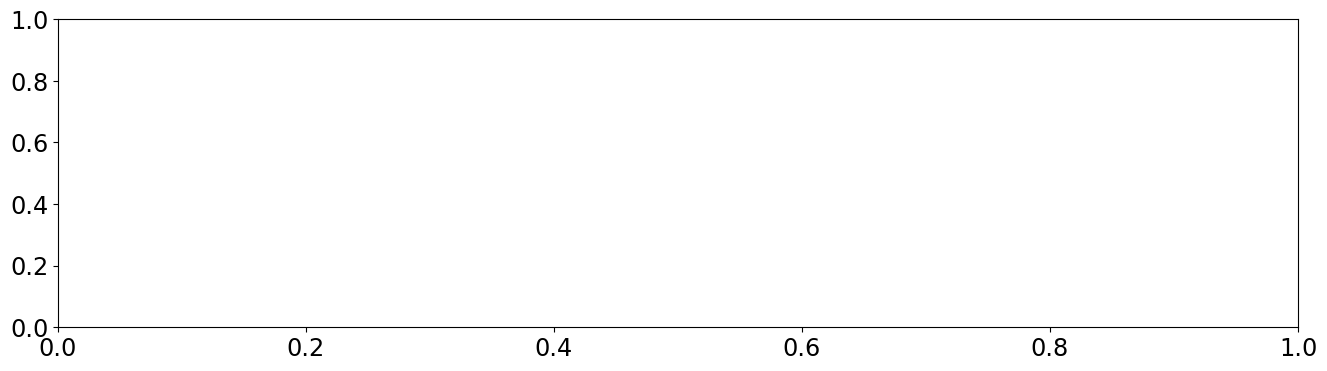

============================ 1 ) exposure_2021110300453_postisrccd_spectrum.fits   /sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/FELH0600~holo4_003/config_DECONVOLUTION_FFMvNov2022/20211103/2021110300453/basespec/exposure_2021110300453_postisrccd_spectrum.fits ==============================
No rebinning: parameters.REBIN is forced to 1.


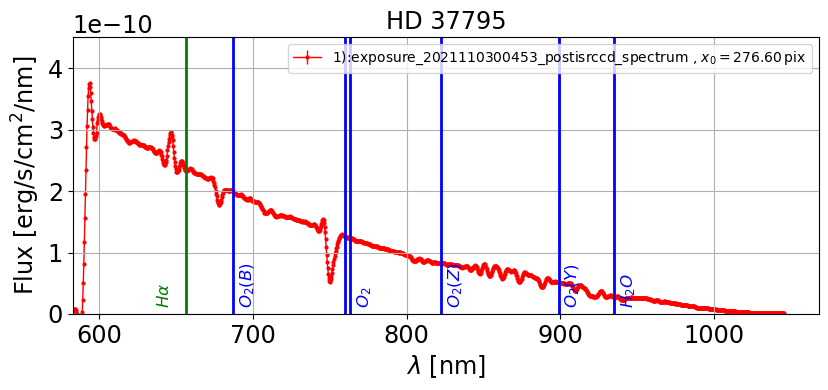

=== ORIGINAL CALIB lines === 


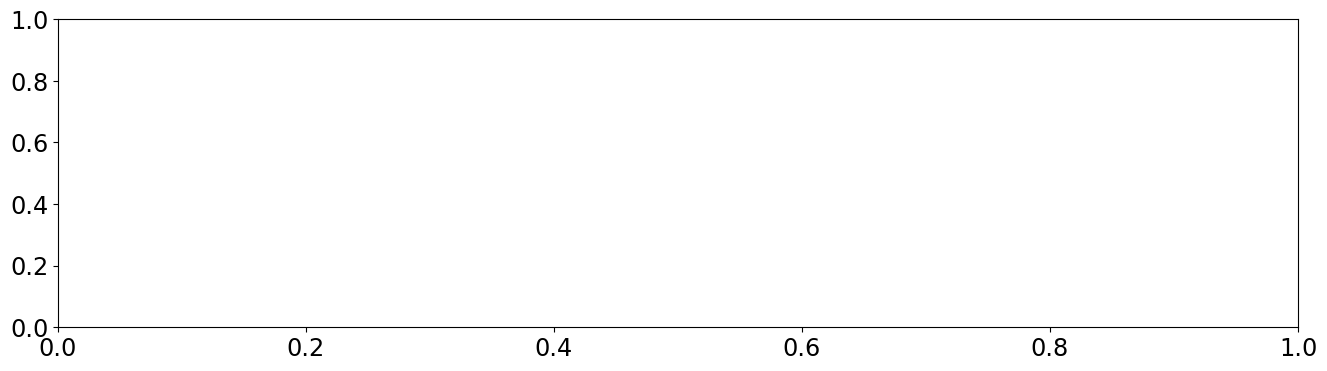

============================ 2 ) exposure_2021110300456_postisrccd_spectrum.fits   /sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/FELH0600~holo4_003/config_DECONVOLUTION_FFMvNov2022/20211103/2021110300456/basespec/exposure_2021110300456_postisrccd_spectrum.fits ==============================
No rebinning: parameters.REBIN is forced to 1.


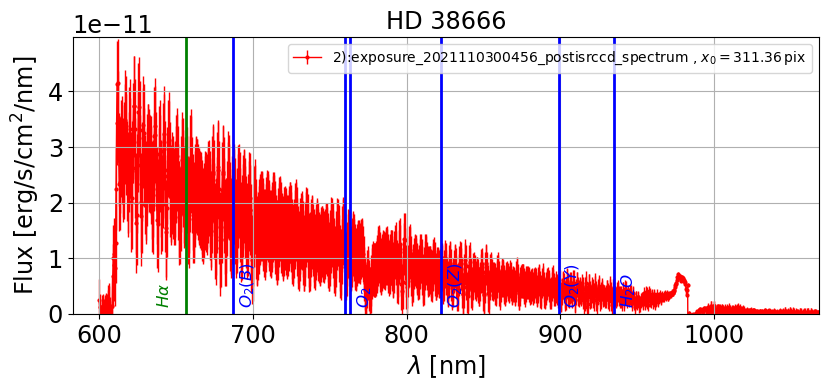

=== ORIGINAL CALIB lines === 


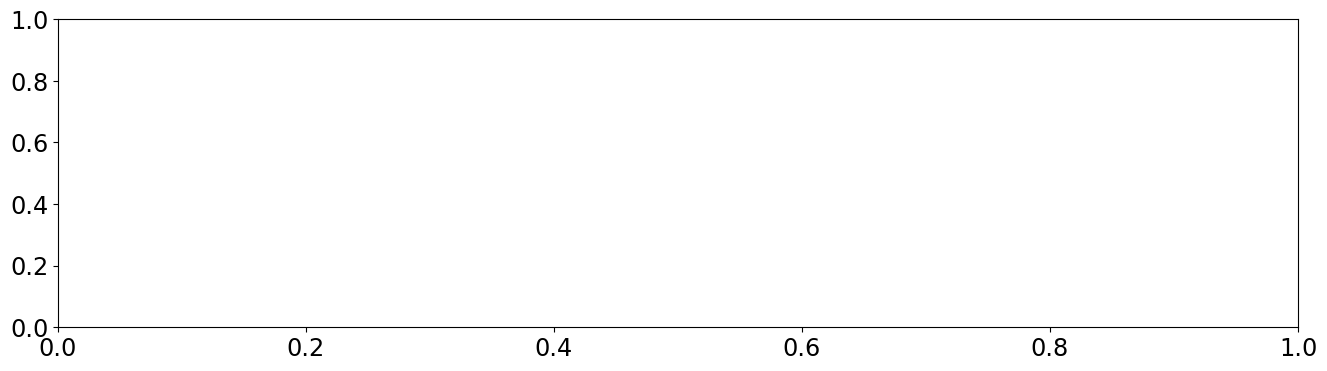

============================ 3 ) exposure_2021110300462_postisrccd_spectrum.fits   /sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/FELH0600~holo4_003/config_DECONVOLUTION_FFMvNov2022/20211103/2021110300462/basespec/exposure_2021110300462_postisrccd_spectrum.fits ==============================
No rebinning: parameters.REBIN is forced to 1.


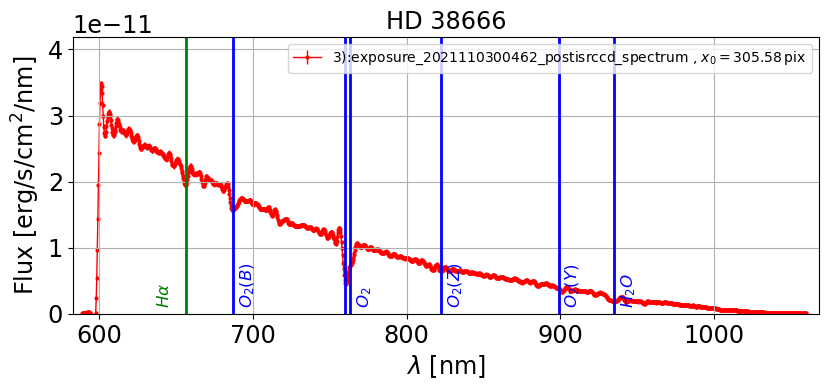

=== ORIGINAL CALIB lines === 


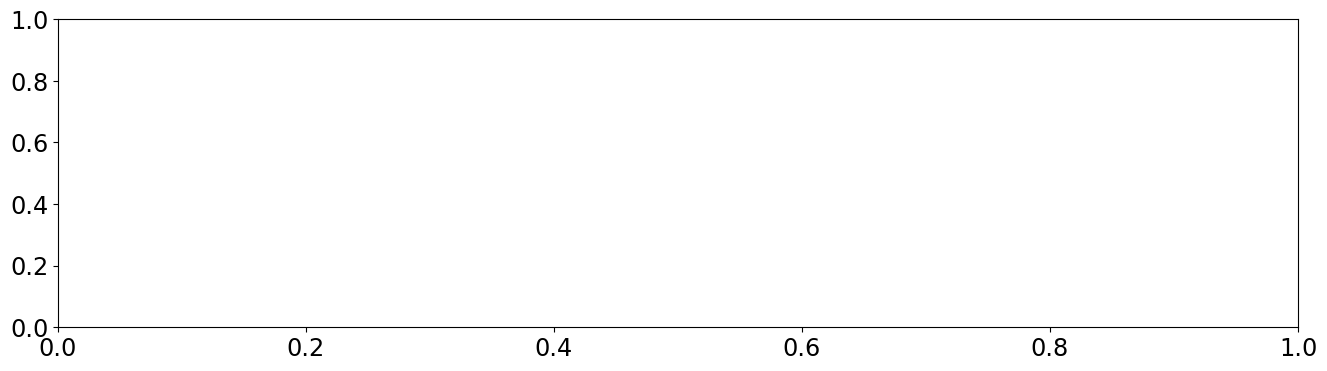

============================ 4 ) exposure_2021110300468_postisrccd_spectrum.fits   /sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/FELH0600~holo4_003/config_DECONVOLUTION_FFMvNov2022/20211103/2021110300468/basespec/exposure_2021110300468_postisrccd_spectrum.fits ==============================
No rebinning: parameters.REBIN is forced to 1.


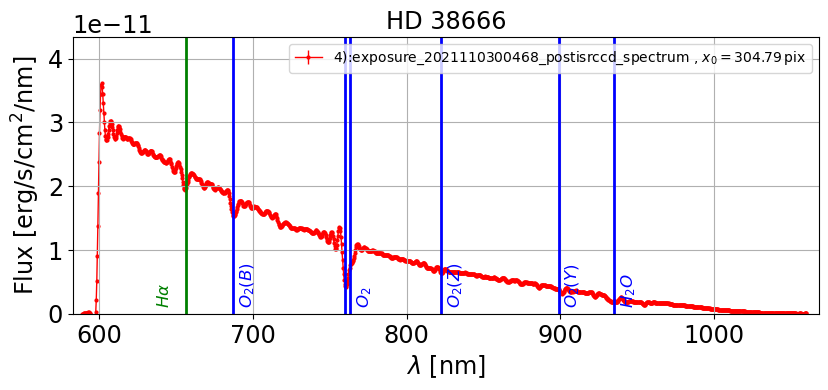

=== ORIGINAL CALIB lines === 


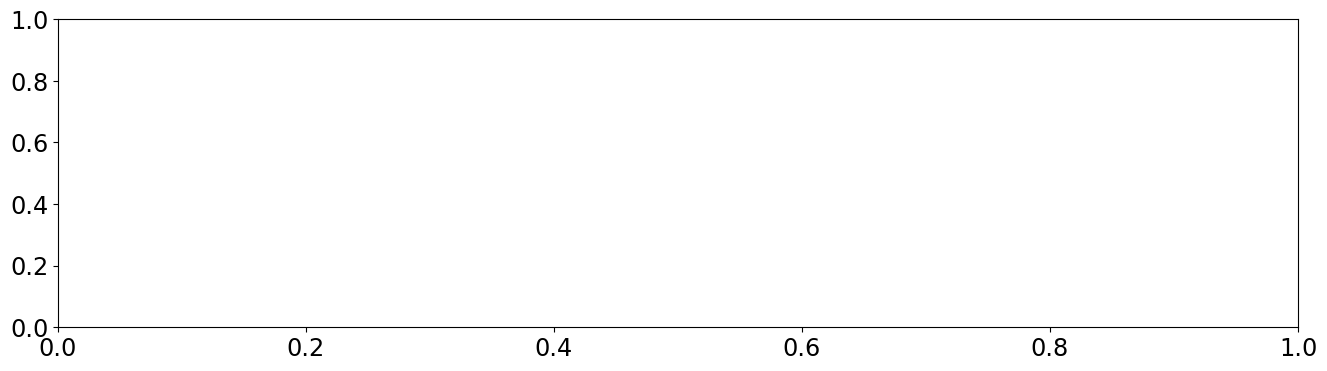

============================ 5 ) exposure_2021110300480_postisrccd_spectrum.fits   /sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/FELH0600~holo4_003/config_DECONVOLUTION_FFMvNov2022/20211103/2021110300480/basespec/exposure_2021110300480_postisrccd_spectrum.fits ==============================
No rebinning: parameters.REBIN is forced to 1.


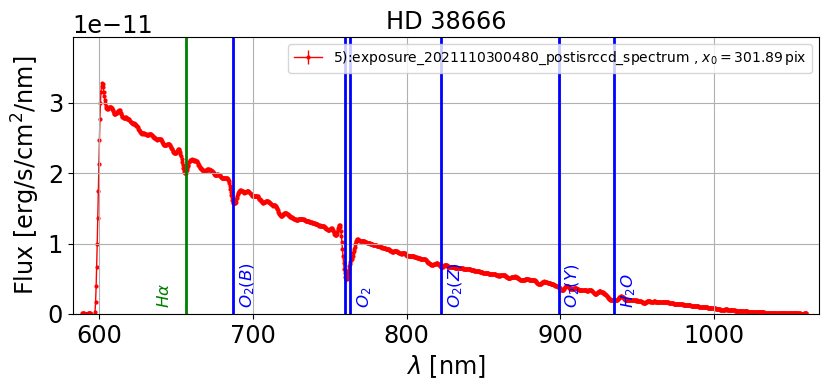

=== ORIGINAL CALIB lines === 


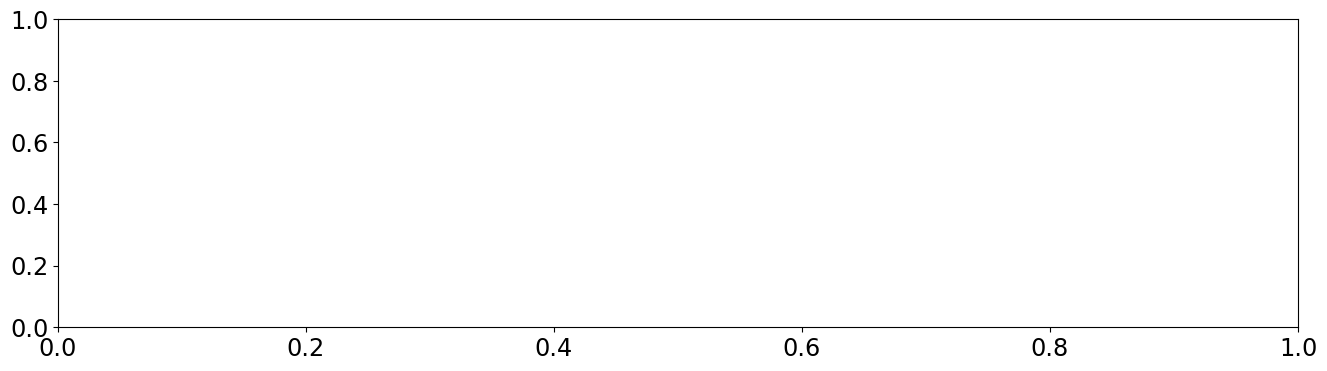

============================ 6 ) exposure_2021110300492_postisrccd_spectrum.fits   /sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/FELH0600~holo4_003/config_DECONVOLUTION_FFMvNov2022/20211103/2021110300492/basespec/exposure_2021110300492_postisrccd_spectrum.fits ==============================
No rebinning: parameters.REBIN is forced to 1.


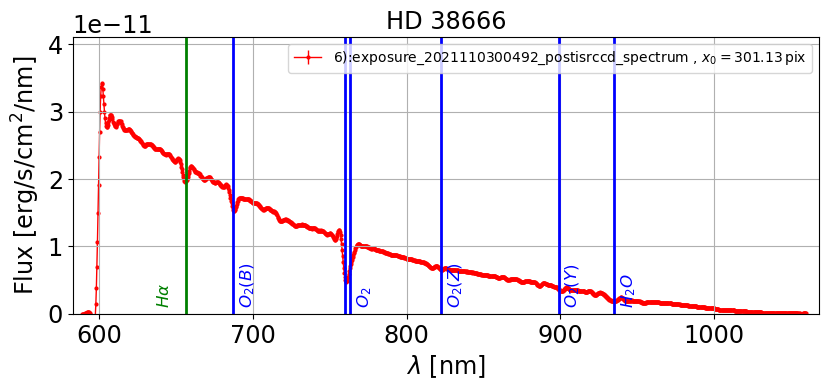

=== ORIGINAL CALIB lines === 


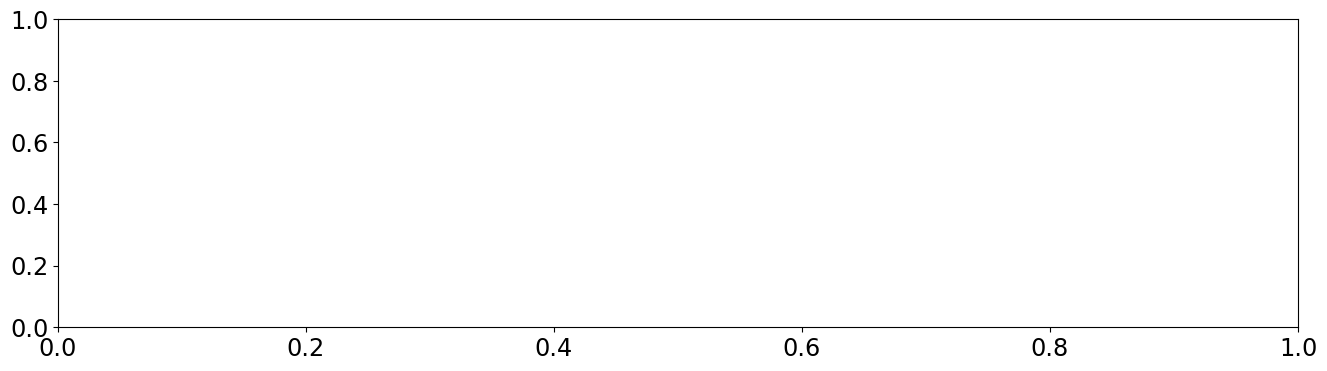

============================ 7 ) exposure_2021110300504_postisrccd_spectrum.fits   /sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/FELH0600~holo4_003/config_DECONVOLUTION_FFMvNov2022/20211103/2021110300504/basespec/exposure_2021110300504_postisrccd_spectrum.fits ==============================
No rebinning: parameters.REBIN is forced to 1.


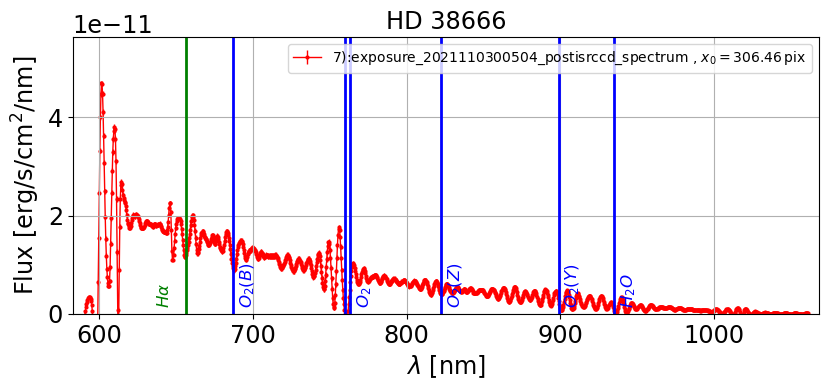

=== ORIGINAL CALIB lines === 


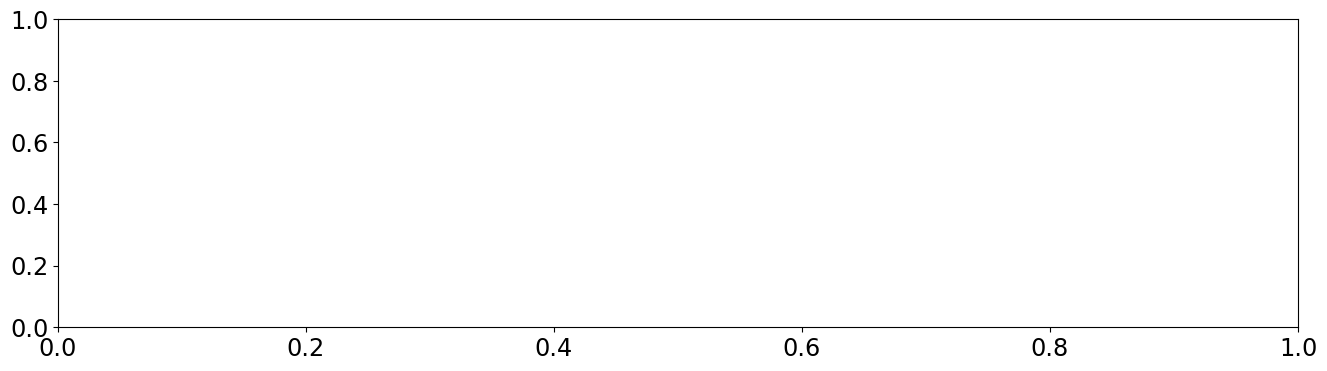

============================ 8 ) exposure_2021110300516_postisrccd_spectrum.fits   /sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/FELH0600~holo4_003/config_DECONVOLUTION_FFMvNov2022/20211103/2021110300516/basespec/exposure_2021110300516_postisrccd_spectrum.fits ==============================
No rebinning: parameters.REBIN is forced to 1.


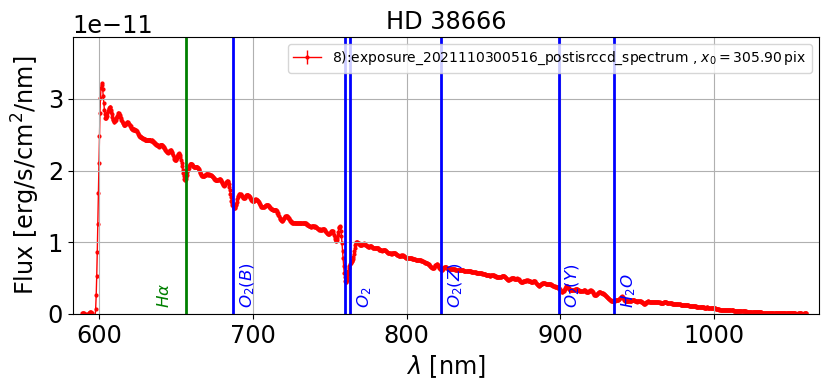

=== ORIGINAL CALIB lines === 


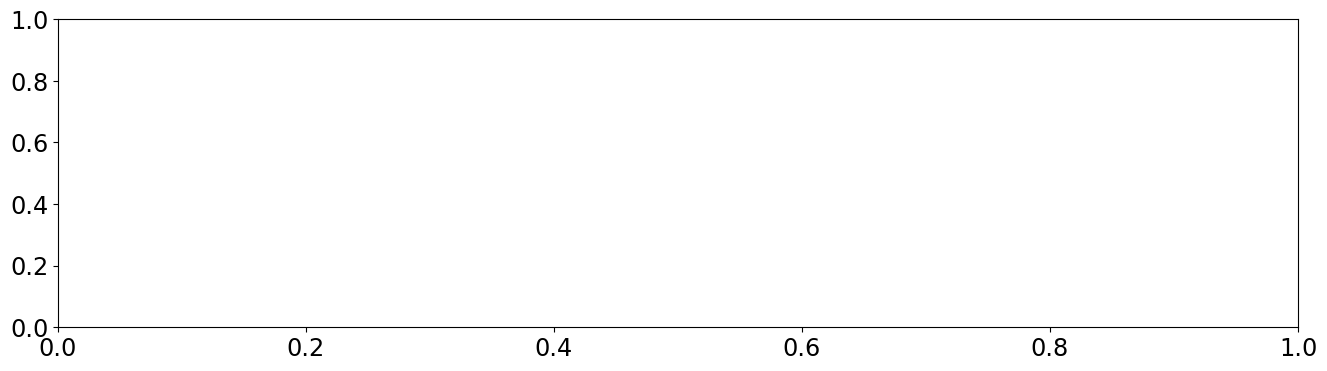

============================ 9 ) exposure_2021110300522_postisrccd_spectrum.fits   /sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/FELH0600~holo4_003/config_DECONVOLUTION_FFMvNov2022/20211103/2021110300522/basespec/exposure_2021110300522_postisrccd_spectrum.fits ==============================
No rebinning: parameters.REBIN is forced to 1.


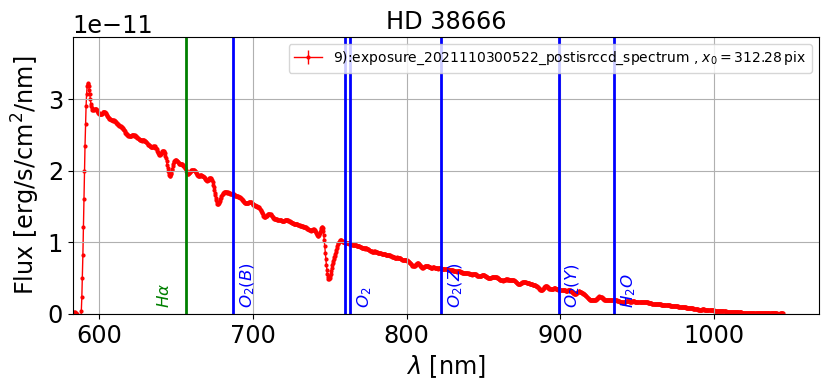

=== ORIGINAL CALIB lines === 


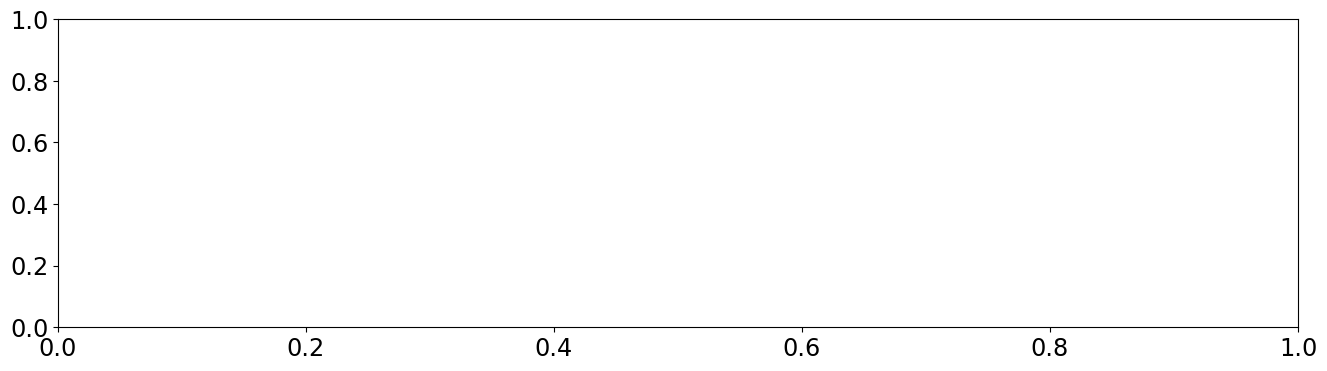

============================ 10 ) exposure_2021110300528_postisrccd_spectrum.fits   /sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/FELH0600~holo4_003/config_DECONVOLUTION_FFMvNov2022/20211103/2021110300528/basespec/exposure_2021110300528_postisrccd_spectrum.fits ==============================
No rebinning: parameters.REBIN is forced to 1.


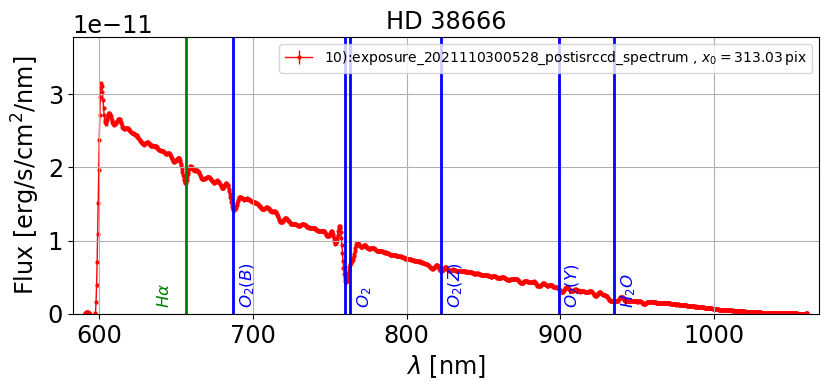

=== ORIGINAL CALIB lines === 


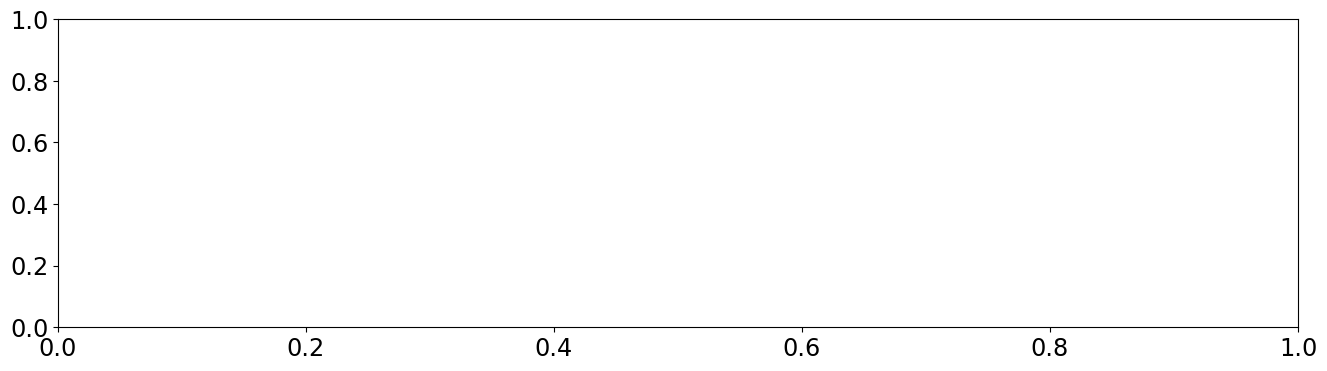

============================ 11 ) exposure_2021110300534_postisrccd_spectrum.fits   /sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/FELH0600~holo4_003/config_DECONVOLUTION_FFMvNov2022/20211103/2021110300534/basespec/exposure_2021110300534_postisrccd_spectrum.fits ==============================
No rebinning: parameters.REBIN is forced to 1.


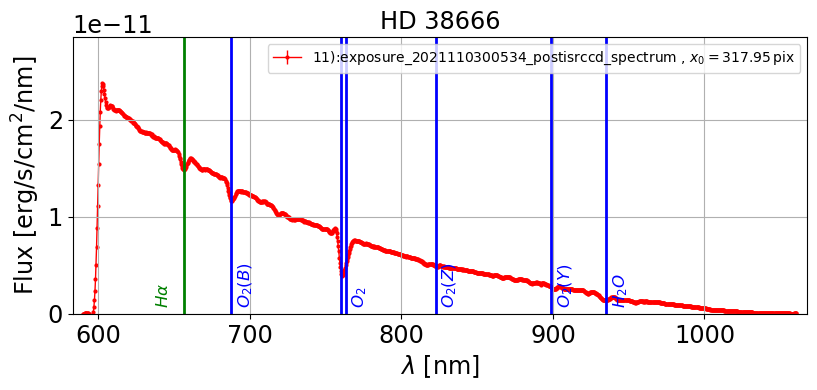

=== ORIGINAL CALIB lines === 


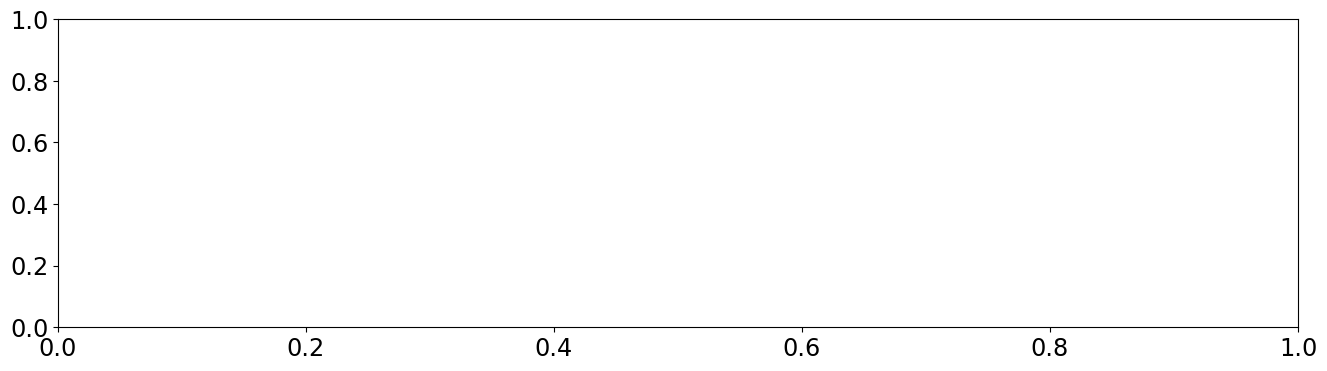

============================ 12 ) exposure_2021110300540_postisrccd_spectrum.fits   /sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/FELH0600~holo4_003/config_DECONVOLUTION_FFMvNov2022/20211103/2021110300540/basespec/exposure_2021110300540_postisrccd_spectrum.fits ==============================
No rebinning: parameters.REBIN is forced to 1.


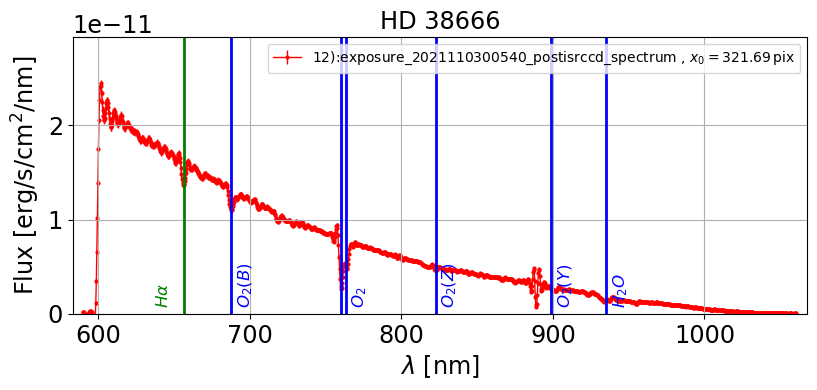

=== ORIGINAL CALIB lines === 


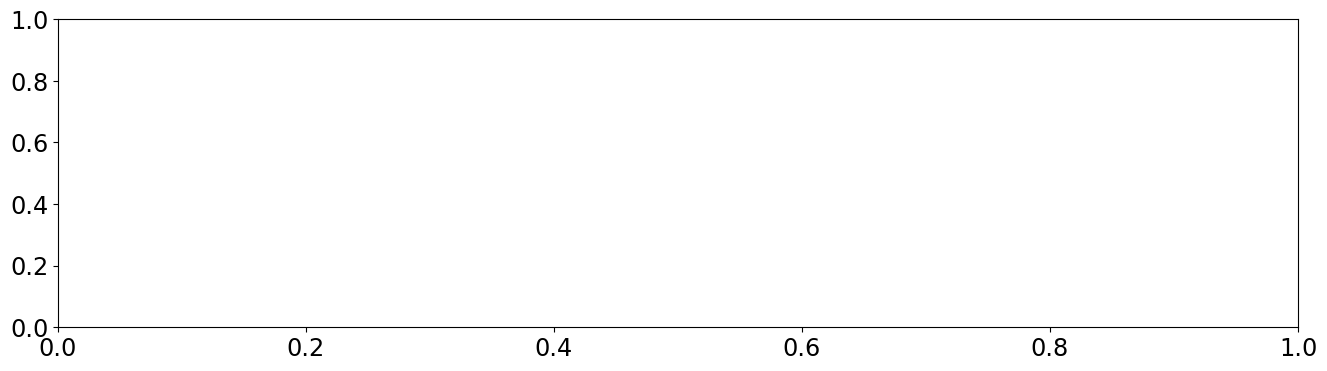

============================ 13 ) exposure_2021110300553_postisrccd_spectrum.fits   /sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/FELH0600~holo4_003/config_DECONVOLUTION_FFMvNov2022/20211103/2021110300553/basespec/exposure_2021110300553_postisrccd_spectrum.fits ==============================
No rebinning: parameters.REBIN is forced to 1.


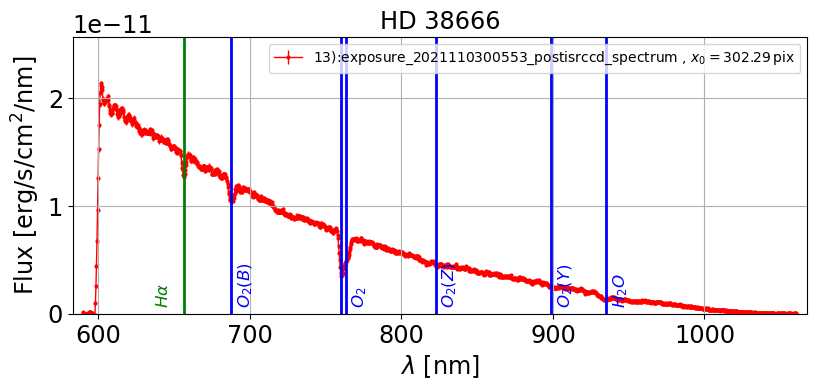

=== ORIGINAL CALIB lines === 


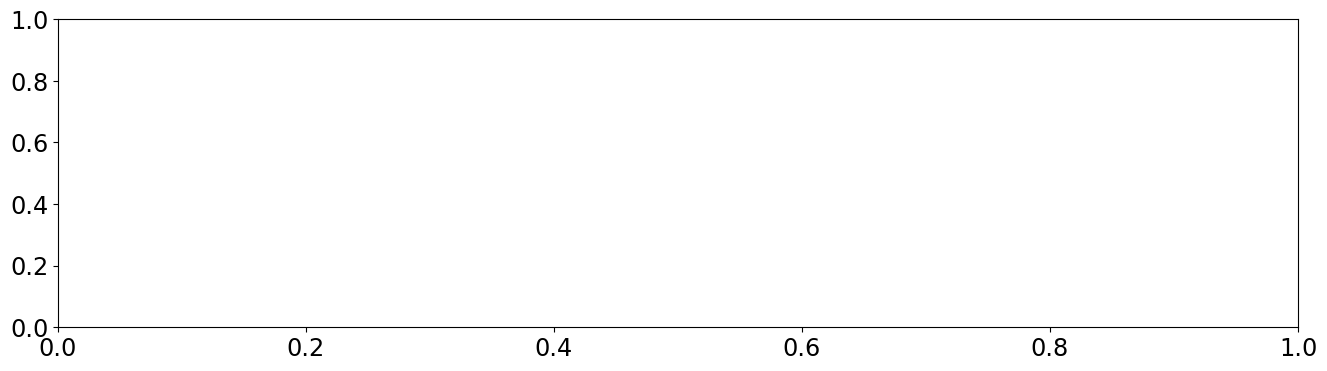

============================ 14 ) exposure_2021110300559_postisrccd_spectrum.fits   /sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/FELH0600~holo4_003/config_DECONVOLUTION_FFMvNov2022/20211103/2021110300559/basespec/exposure_2021110300559_postisrccd_spectrum.fits ==============================
No rebinning: parameters.REBIN is forced to 1.


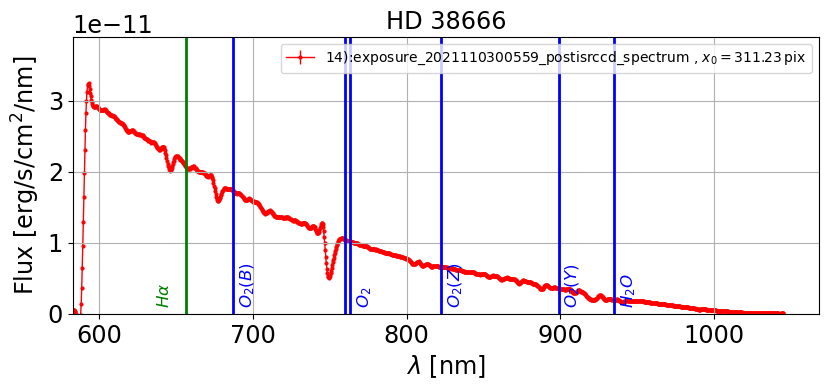

=== ORIGINAL CALIB lines === 


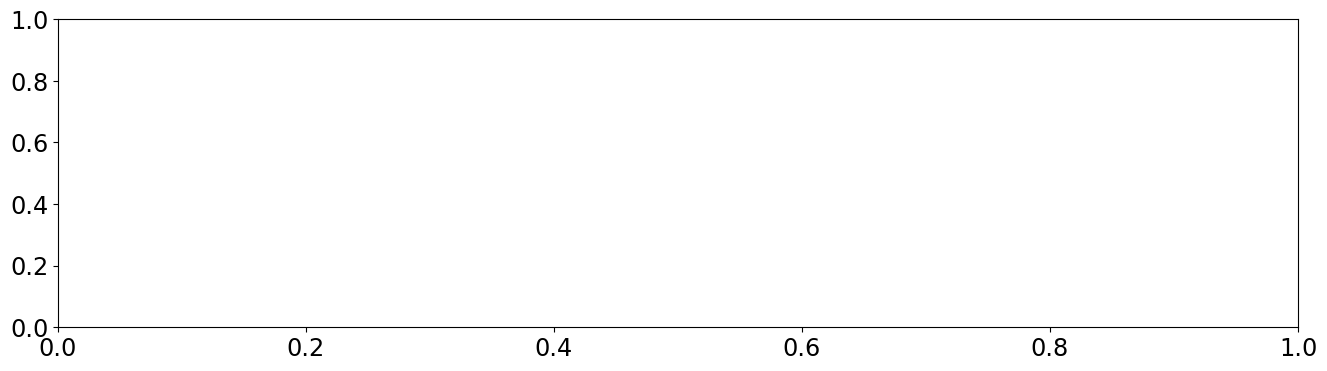

============================ 15 ) exposure_2021110300565_postisrccd_spectrum.fits   /sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/FELH0600~holo4_003/config_DECONVOLUTION_FFMvNov2022/20211103/2021110300565/basespec/exposure_2021110300565_postisrccd_spectrum.fits ==============================
No rebinning: parameters.REBIN is forced to 1.


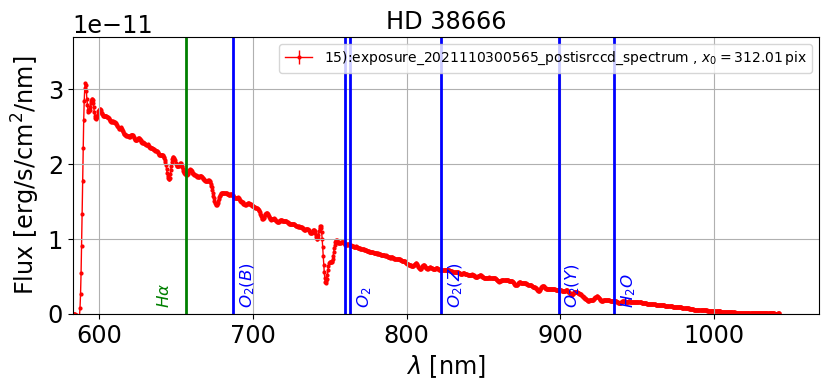

=== ORIGINAL CALIB lines === 


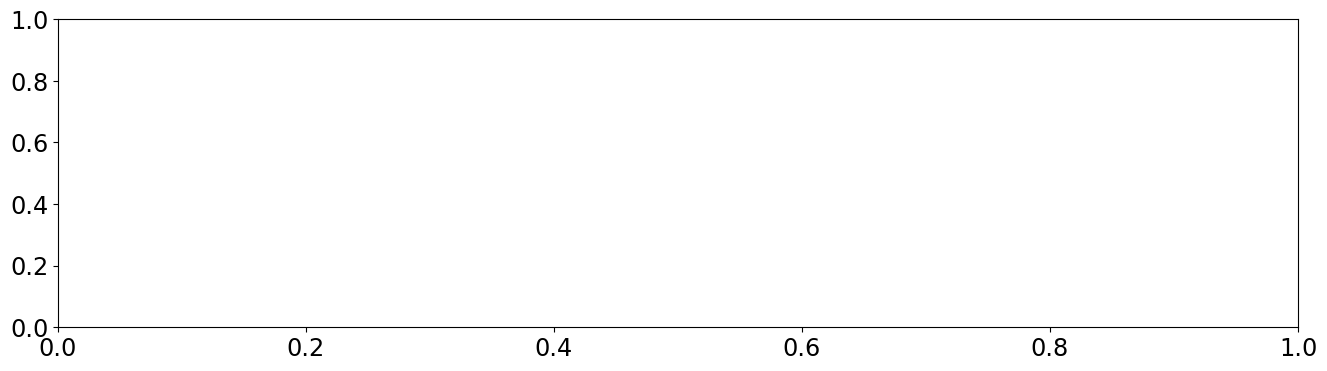

============================ 16 ) exposure_2021110300571_postisrccd_spectrum.fits   /sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/FELH0600~holo4_003/config_DECONVOLUTION_FFMvNov2022/20211103/2021110300571/basespec/exposure_2021110300571_postisrccd_spectrum.fits ==============================
No rebinning: parameters.REBIN is forced to 1.


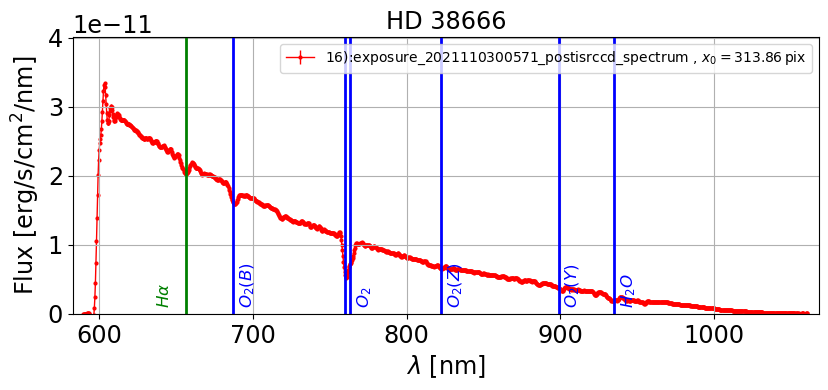

=== ORIGINAL CALIB lines === 


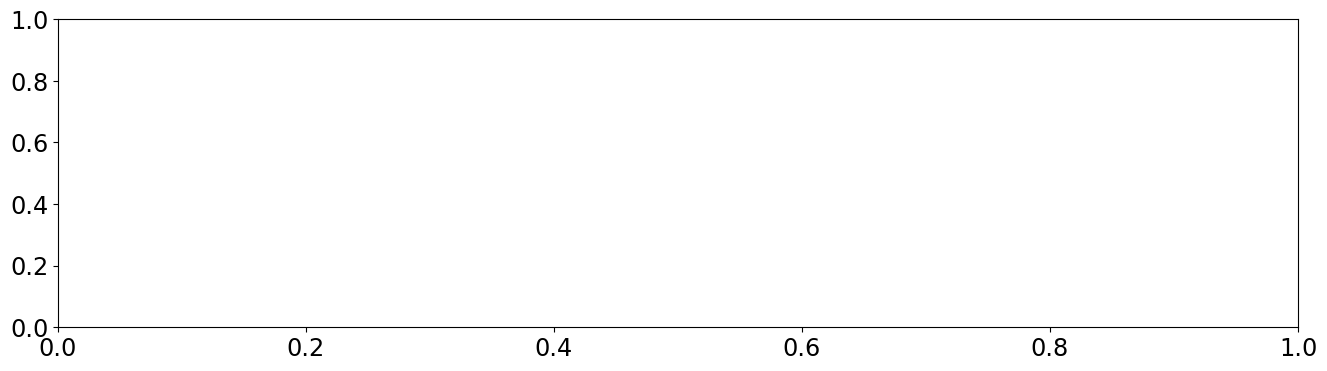

============================ 17 ) exposure_2021110300577_postisrccd_spectrum.fits   /sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/FELH0600~holo4_003/config_DECONVOLUTION_FFMvNov2022/20211103/2021110300577/basespec/exposure_2021110300577_postisrccd_spectrum.fits ==============================
No rebinning: parameters.REBIN is forced to 1.


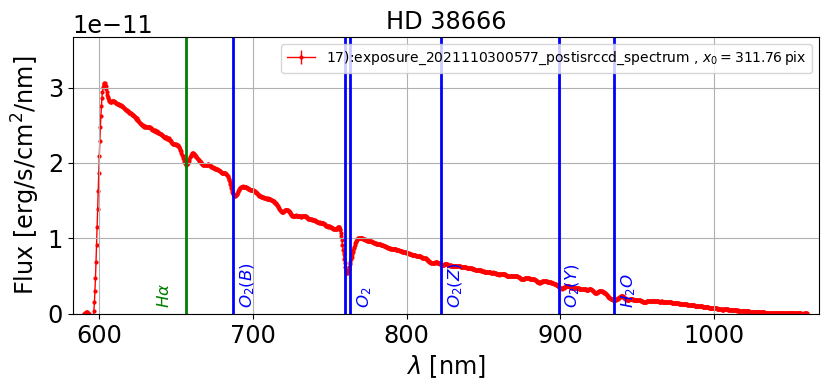

=== ORIGINAL CALIB lines === 


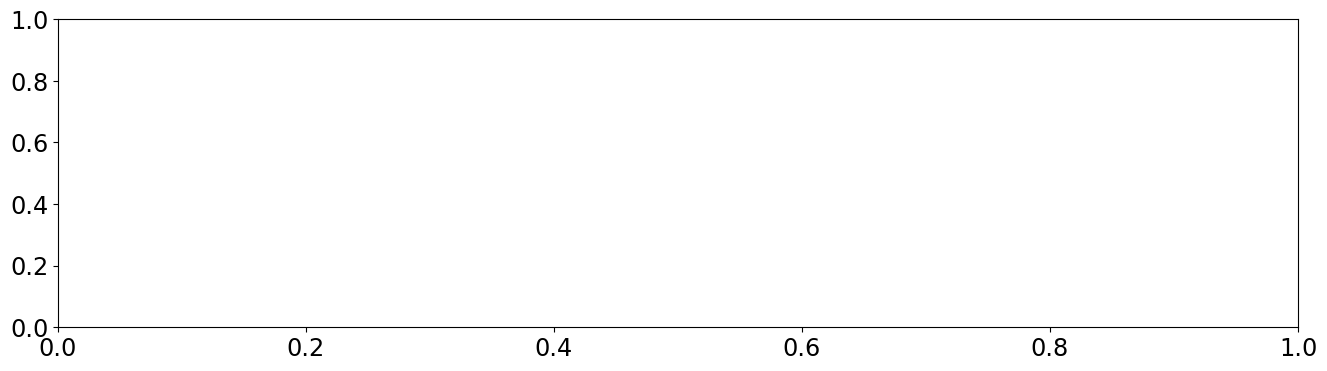

============================ 18 ) exposure_2021110300583_postisrccd_spectrum.fits   /sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/FELH0600~holo4_003/config_DECONVOLUTION_FFMvNov2022/20211103/2021110300583/basespec/exposure_2021110300583_postisrccd_spectrum.fits ==============================
No rebinning: parameters.REBIN is forced to 1.


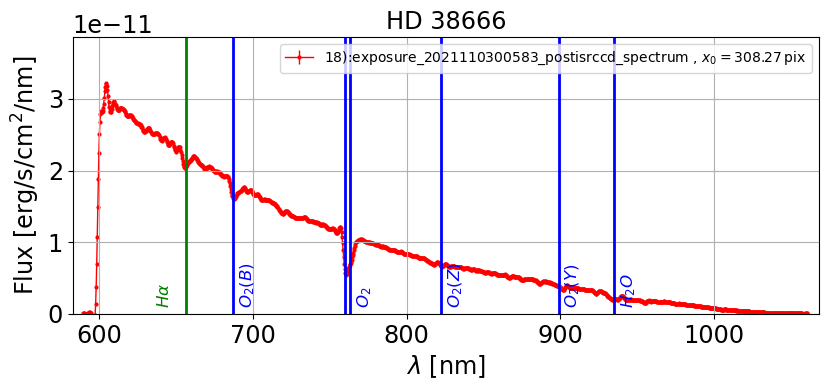

=== ORIGINAL CALIB lines === 


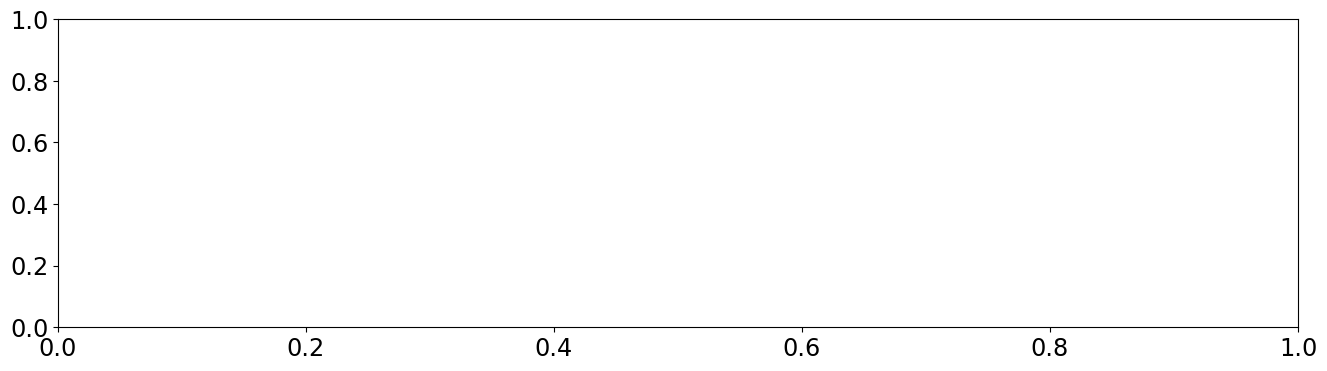

============================ 19 ) exposure_2021110300589_postisrccd_spectrum.fits   /sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/FELH0600~holo4_003/config_DECONVOLUTION_FFMvNov2022/20211103/2021110300589/basespec/exposure_2021110300589_postisrccd_spectrum.fits ==============================
No rebinning: parameters.REBIN is forced to 1.


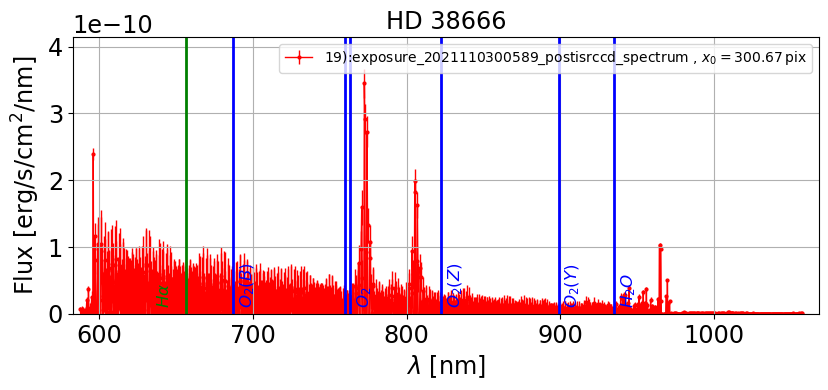

=== ORIGINAL CALIB lines === 


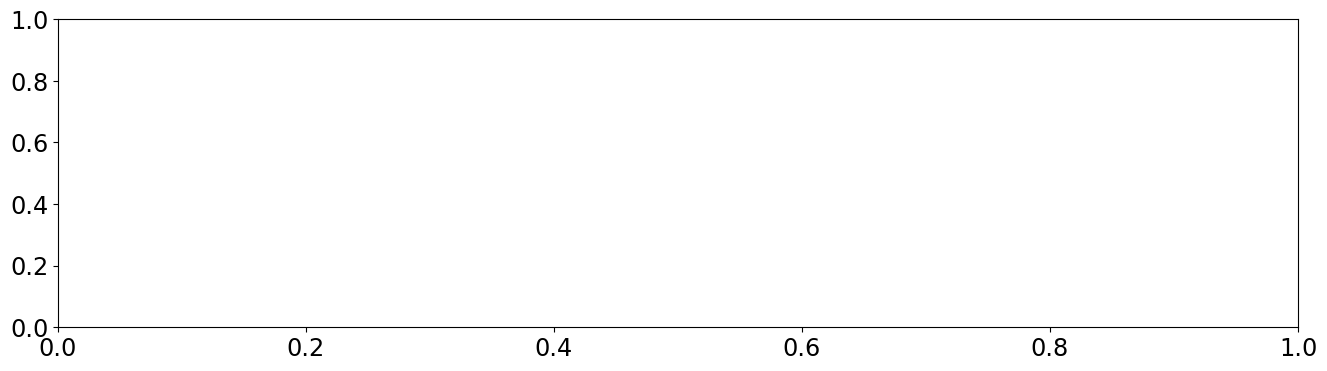

============================ 20 ) exposure_2021110300595_postisrccd_spectrum.fits   /sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/FELH0600~holo4_003/config_DECONVOLUTION_FFMvNov2022/20211103/2021110300595/basespec/exposure_2021110300595_postisrccd_spectrum.fits ==============================
No rebinning: parameters.REBIN is forced to 1.


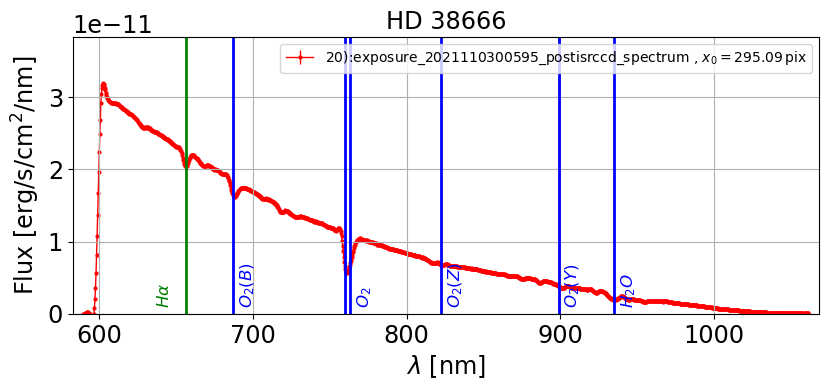

=== ORIGINAL CALIB lines === 


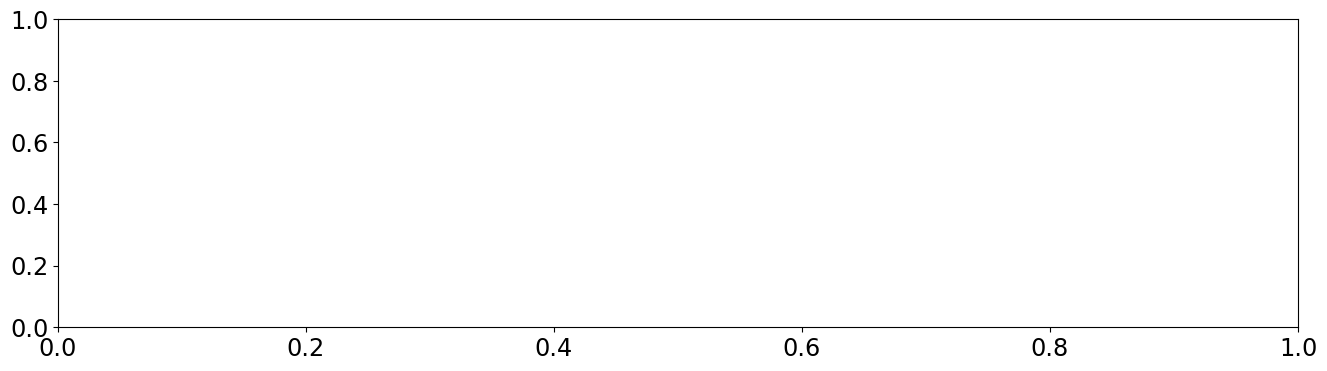

============================ 21 ) exposure_2021110300601_postisrccd_spectrum.fits   /sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/FELH0600~holo4_003/config_DECONVOLUTION_FFMvNov2022/20211103/2021110300601/basespec/exposure_2021110300601_postisrccd_spectrum.fits ==============================
No rebinning: parameters.REBIN is forced to 1.


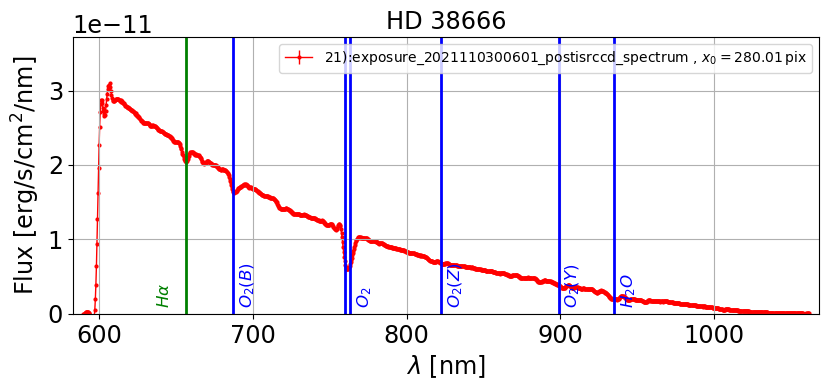

=== ORIGINAL CALIB lines === 


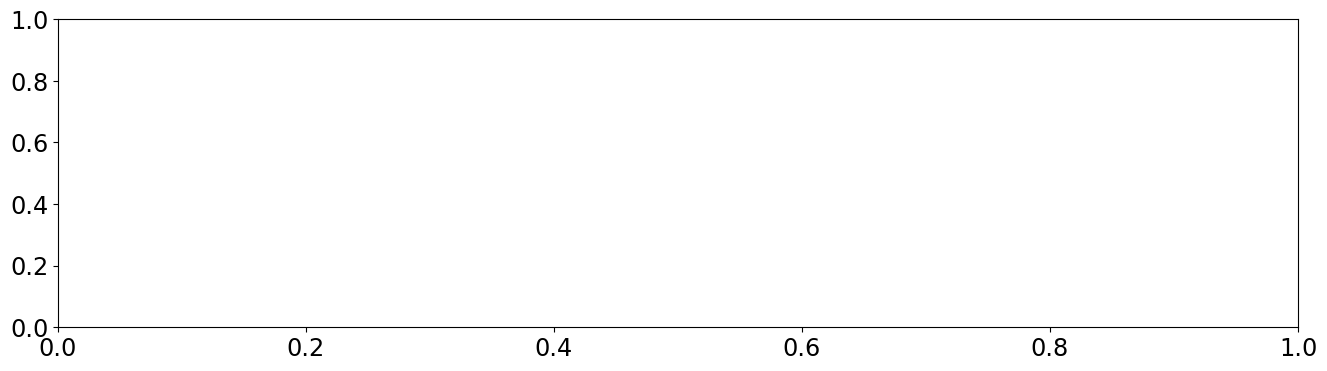

============================ 22 ) exposure_2021110300607_postisrccd_spectrum.fits   /sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/FELH0600~holo4_003/config_DECONVOLUTION_FFMvNov2022/20211103/2021110300607/basespec/exposure_2021110300607_postisrccd_spectrum.fits ==============================
No rebinning: parameters.REBIN is forced to 1.


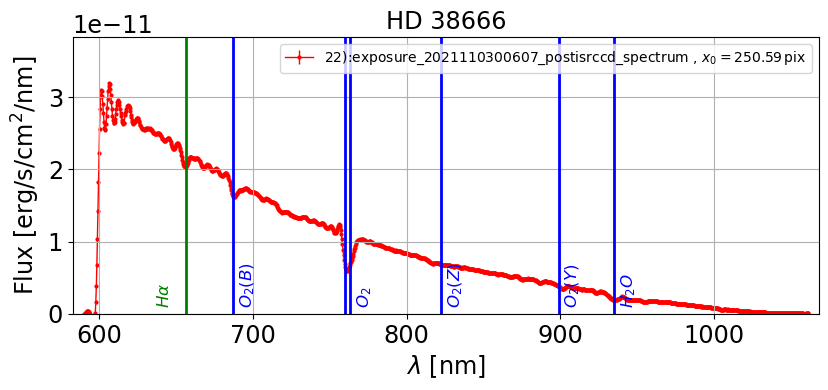

=== ORIGINAL CALIB lines === 


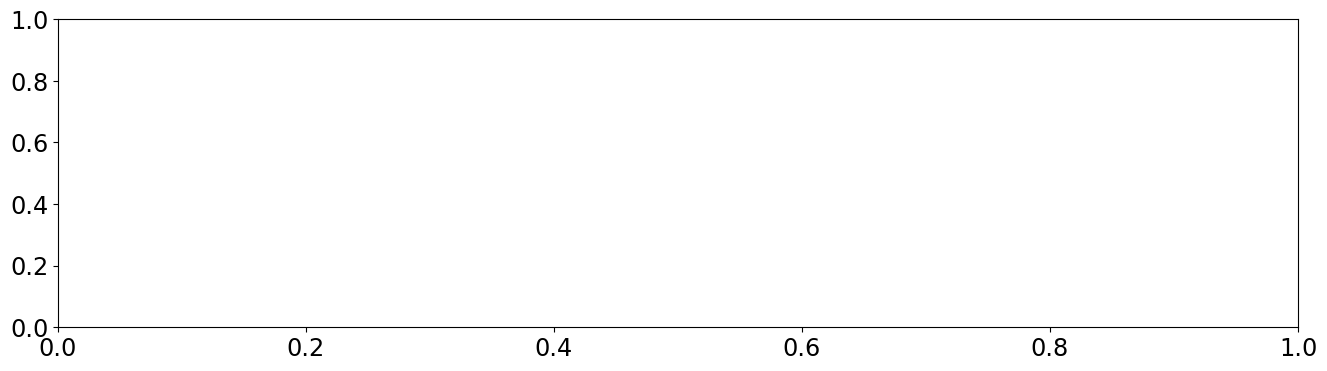

============================ 23 ) exposure_2021110300694_postisrccd_spectrum.fits   /sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/FELH0600~holo4_003/config_DECONVOLUTION_FFMvNov2022/20211103/2021110300694/basespec/exposure_2021110300694_postisrccd_spectrum.fits ==============================
No rebinning: parameters.REBIN is forced to 1.


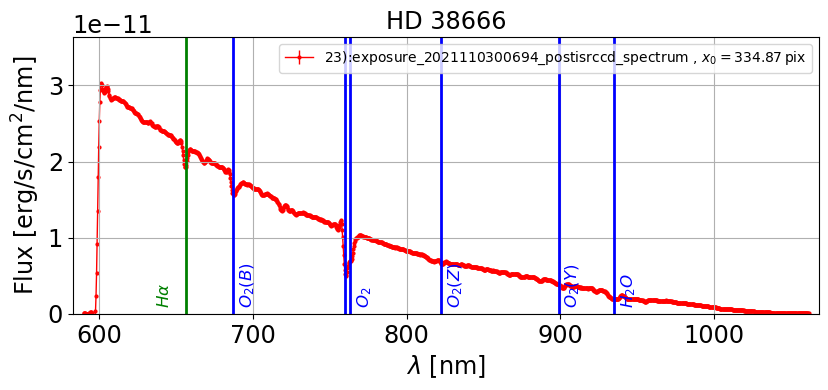

=== ORIGINAL CALIB lines === 


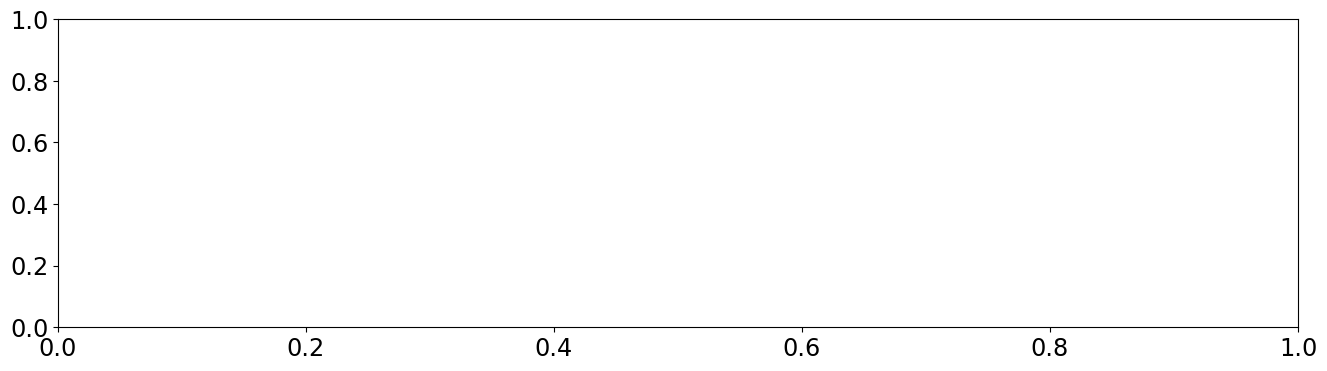

============================ 24 ) exposure_2021110300700_postisrccd_spectrum.fits   /sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/FELH0600~holo4_003/config_DECONVOLUTION_FFMvNov2022/20211103/2021110300700/basespec/exposure_2021110300700_postisrccd_spectrum.fits ==============================
No rebinning: parameters.REBIN is forced to 1.


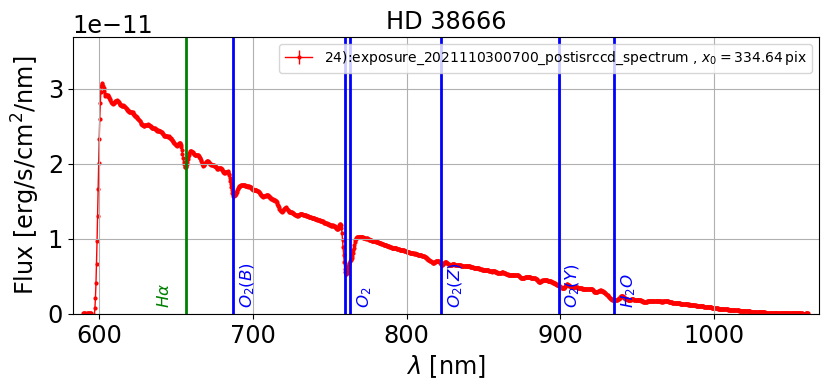

=== ORIGINAL CALIB lines === 


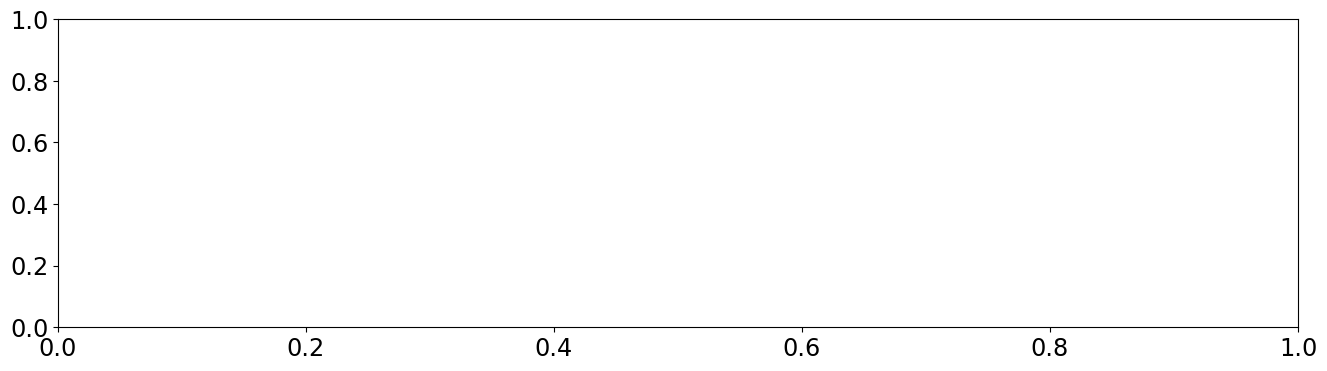

============================ 25 ) exposure_2021110300706_postisrccd_spectrum.fits   /sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/FELH0600~holo4_003/config_DECONVOLUTION_FFMvNov2022/20211103/2021110300706/basespec/exposure_2021110300706_postisrccd_spectrum.fits ==============================
No rebinning: parameters.REBIN is forced to 1.


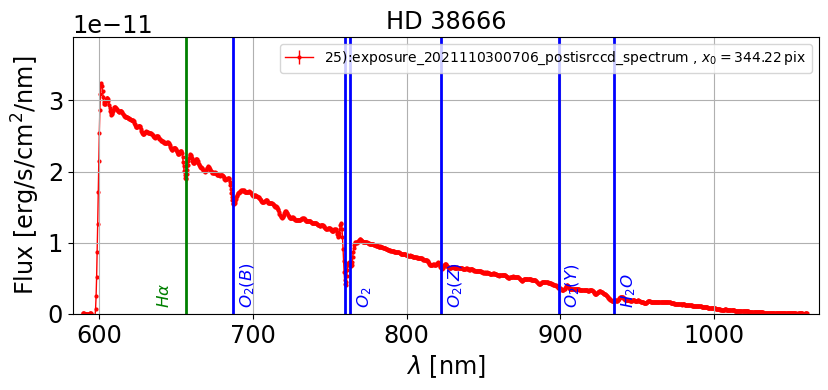

=== ORIGINAL CALIB lines === 


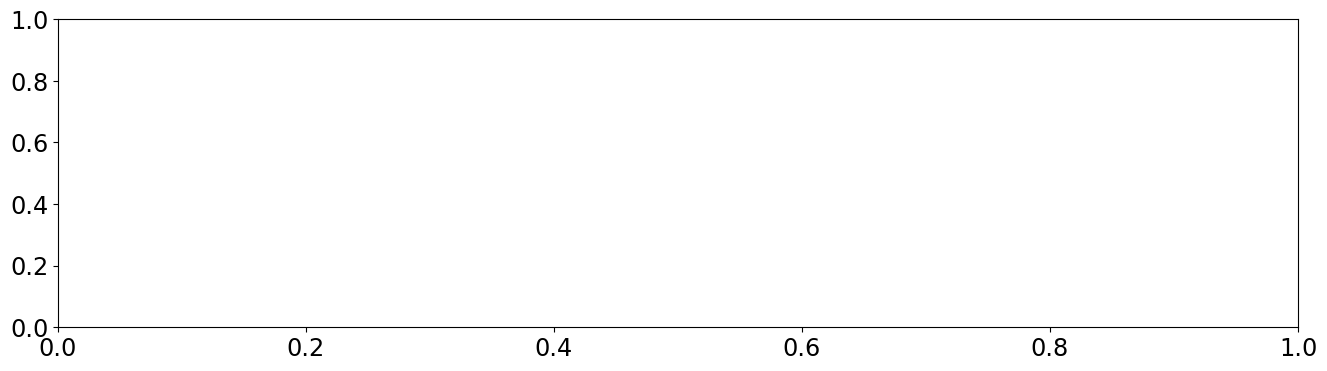

============================ 26 ) exposure_2021110300712_postisrccd_spectrum.fits   /sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/FELH0600~holo4_003/config_DECONVOLUTION_FFMvNov2022/20211103/2021110300712/basespec/exposure_2021110300712_postisrccd_spectrum.fits ==============================
No rebinning: parameters.REBIN is forced to 1.


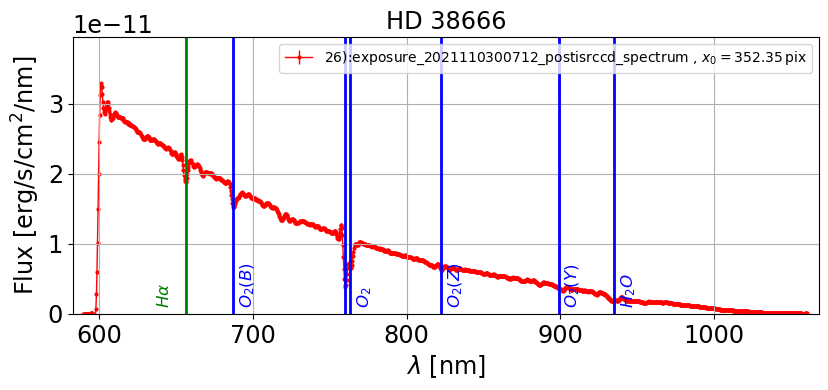

=== ORIGINAL CALIB lines === 


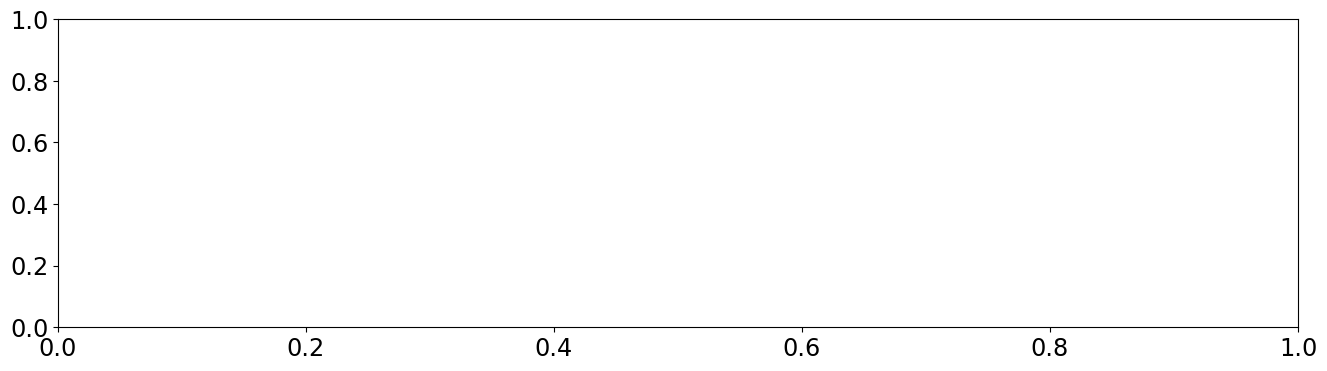

============================ 27 ) exposure_2021110300718_postisrccd_spectrum.fits   /sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/FELH0600~holo4_003/config_DECONVOLUTION_FFMvNov2022/20211103/2021110300718/basespec/exposure_2021110300718_postisrccd_spectrum.fits ==============================
No rebinning: parameters.REBIN is forced to 1.


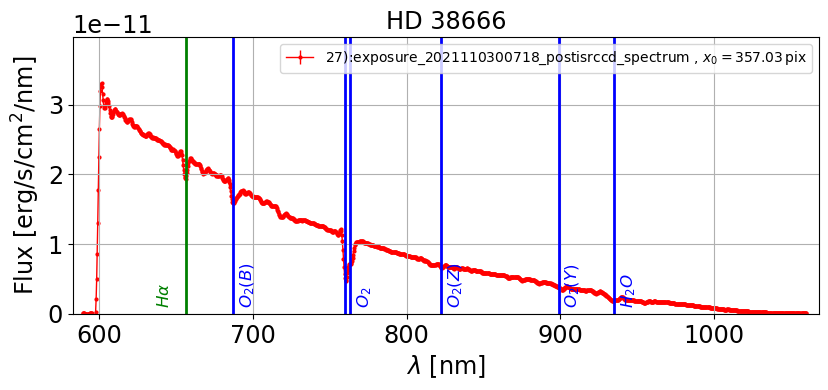

=== ORIGINAL CALIB lines === 


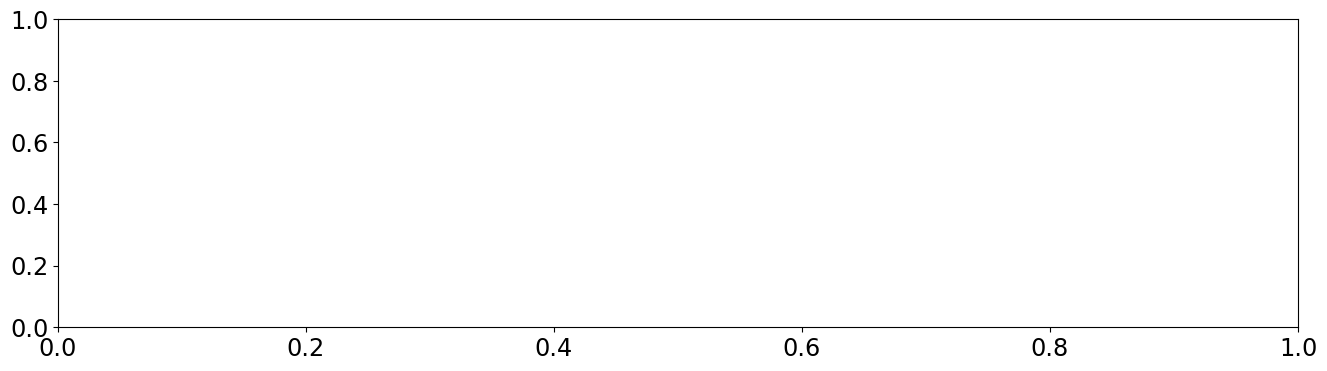

============================ 28 ) exposure_2021110300724_postisrccd_spectrum.fits   /sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/FELH0600~holo4_003/config_DECONVOLUTION_FFMvNov2022/20211103/2021110300724/basespec/exposure_2021110300724_postisrccd_spectrum.fits ==============================
No rebinning: parameters.REBIN is forced to 1.


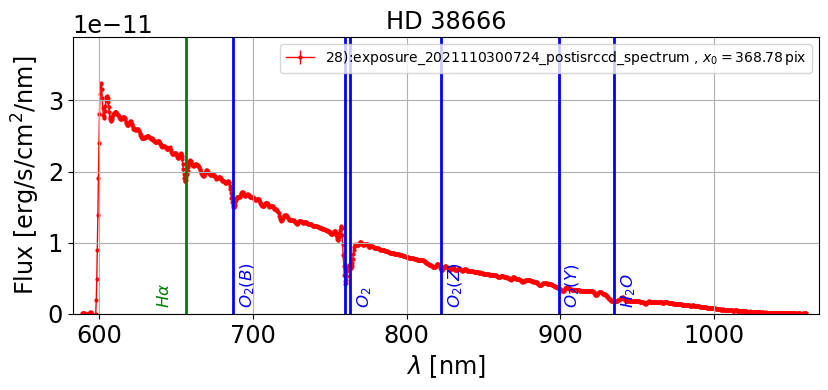

=== ORIGINAL CALIB lines === 


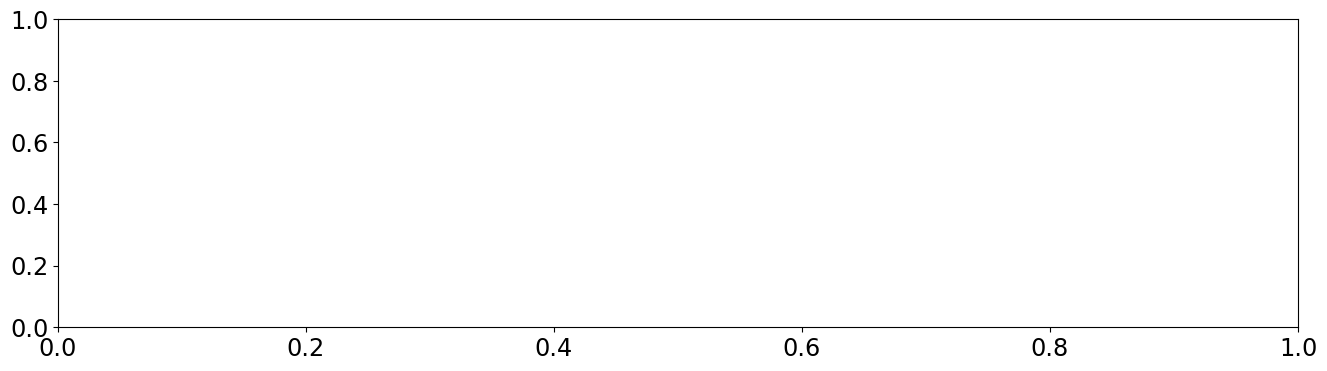

============================ 29 ) exposure_2021110300736_postisrccd_spectrum.fits   /sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/FELH0600~holo4_003/config_DECONVOLUTION_FFMvNov2022/20211103/2021110300736/basespec/exposure_2021110300736_postisrccd_spectrum.fits ==============================
No rebinning: parameters.REBIN is forced to 1.


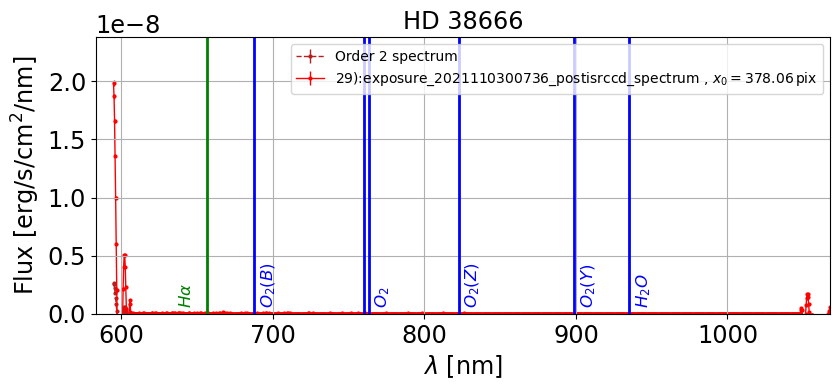

=== ORIGINAL CALIB lines === 


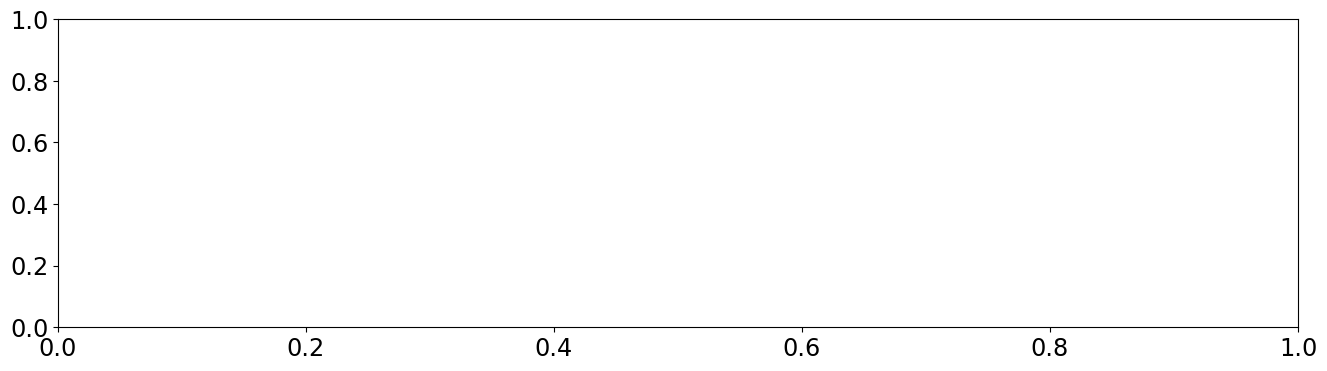

In [53]:
parameters.DISPLAY=True

FLAG_ORDER2 = False

infos = []
all_lambdas=[]
all_data=[]
all_data_err=[]

if FLAG_ORDER2:
    all_lambdas_order2=[]
    all_data_order2=[]
    all_data_err_order2=[]

all_num=[]
all_figs = []


idx=0
for fullfilename in all_good_spectra_spectrum_files:
    
    filename = os.path.basename(fullfilename)
    print("============================",idx,")",filename," ",fullfilename,"==============================")
    
    
    fig=plt.figure(figsize=(16,4))
    ax1 = fig.add_subplot(1, 2, 1)
    
    filename= os.path.basename(fullfilename)
    tag=file_tag_forsorting(filename.split(".")[0])
    all_num.append(tag)
    
   
     
    s=Spectrum(fullfilename, config=config,fast_load=False)
    label=filename.split('.')[0]+" "
    label = str(idx) +"):"+label
    s.plot_spectrum(ax=ax1,force_lines=True,label=label)
    print("=== ORIGINAL CALIB lines === ")
    s.lines.print_detected_lines(print_table=True)
    
    if FLAG_RECALIB: 
        print(" === RECALIBRATE lines === ")
        s.lines = lines_calib
        lambdas = calibrate_spectrum(s, with_adr=False)
        label=filename.split('.')[0]+" recalibrated"
        s.plot_spectrum(ax=ax1,force_lines=True,label=label)
        t=s.lines.print_detected_lines(print_table=True)
        print(t["Shift"])
    
    
    
    
    all_lambdas.append(s.lambdas)
    all_data.append(s.data)
    all_data_err.append(s.err)
    
    if FLAG_ORDER2:
        all_lambdas_order2.append(s.lambdas_order2)
        all_data_order2.append(s.data_order2)
        all_data_err_order2.append(s.err_order2)
    
    ax2 = fig.add_subplot(1, 2, 2)
    
    fullfilename2=all_files_spectrogram[idx]
    
    s.load_spectrogram(fullfilename2)
    s.plot_spectrogram(ax=ax2,scale="log")
    
    
    infos.append([idx,s.target.label,s.date_obs,s.airmass,s.temperature,s.pressure,s.humidity])
    
    
    plt.show()
    all_figs.append(fig)
    
    idx+=1
    

## Save figures in a pdf filename

In [54]:
def SaveFigSpectraInPdf(nbspecperpage=5):
    
    Nspec= len(all_good_spectra_spectrum_files)
    Nbpages = np.ceil(Nspec/nbspecperpage)
    idx_inpage = nbspecperpage
    idx_pagenum = 0
    idx = 0
    
    all_composed_figs = []
    
    for fullfilename in all_good_spectra_spectrum_files:
        
        if idx_inpage == nbspecperpage:
            idx_inpage = 1
            idx_pagenum += 1
            
            if idx_pagenum > 1:
                all_composed_figs.append(fig)
            
            # create a new figure 
            fig=plt.figure(figsize=(16,20))
        else:
            idx_inpage += 1   
                             
        idx_fig = 2*(idx_inpage-1)+1
        
        print(f"\t \t  SaveFigSpectraInPdf >>>>>>>>  spec num = {idx}, pagenum = {idx_pagenum}/{Nbpages}, idx_inpage = {idx_inpage}, idx_fig = {idx_fig}")        
       
        
    
        filename = os.path.basename(fullfilename)
        

        ax1 = fig.add_subplot(nbspecperpage, 2, idx_fig)
    
        filename= os.path.basename(fullfilename)
        tag=file_tag_forsorting(filename.split(".")[0])
     
     
        s=Spectrum(fullfilename, config=config,fast_load=False);
        label=filename.split('.')[0]+" "
        s.plot_spectrum(ax=ax1,force_lines=True,label=label)
    
    
        ax2 = fig.add_subplot(nbspecperpage, 2, idx_fig+1)
    
        fullfilename2=all_files_spectrogram[idx]
    
        s.load_spectrogram(fullfilename2)
        s.plot_spectrogram(ax=ax2,scale="log")
    
        plt.show()
                           
        idx+=1
                           
        if idx == Nspec:
             all_composed_figs.append(fig)
                           
    return  all_composed_figs
    


In [55]:
def SaveFigSpectraSummaryInPdf(all_wl,all_spec,all_tag,delta=0, 
                thetitle="Hologram, spectrum night 2022-03-16", 
                thexlabel="$\\lambda$ (nm)",theylabel="Flux (erg/cm^2/s/nm)",figsize=(14,8)):
    """
    """
    
    
    
    
    NN=len(all_wl)
    
    # wavelength bin colors
    jet = plt.get_cmap('jet')
    cNorm = colors.Normalize(vmin=0, vmax=NN)
    scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
    all_colors = scalarMap.to_rgba(np.arange(NN), alpha=1)
    
    
    fig=plt.figure(figsize=figsize)
    ax=fig.add_subplot(1,1,1)
    
    idx=0
    for idx in range(NN):
        
        label=all_tag[idx]
        ax.plot(all_wl[idx],all_spec[idx]+delta,label=label,color=all_colors[idx])
        if delta !=0:
            plt.text(250.,all_spec[idx][0]+delta, f'{label}',color=all_colors[idx],fontsize=10)
        
    ax.set_xlabel(thexlabel)
    ax.set_ylabel(theylabel)
    ax.set_xlim(250.,1100)
    ax.grid()
    ax.legend(bbox_to_anchor=(1.04, 1), prop={'size': 10}, loc='upper left')
    ax.set_title(thetitle)
    plt.show()
    return fig

In [56]:
def SaveFigSpectraSummaryBothInPdf(all_wl,all_spec,all_tag,delta=0, 
                thetitle="Hologram, spectrum", 
                thexlabel="$\\lambda$ (nm)",theylabel="Flux (erg/cm^2/s/nm)",figsize=(12,20)):
    """
    
    """
    
    NN=len(all_wl)
    
    # wavelength bin colors
    jet = plt.get_cmap('jet')
    cNorm = colors.Normalize(vmin=0, vmax=NN)
    scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
    all_colors = scalarMap.to_rgba(np.arange(NN), alpha=1)
    
    
    fig=plt.figure(figsize=figsize)
    
    gs = gridspec.GridSpec(2, 1,height_ratios=[1, 3] ,figure=fig)
    
    ax=fig.add_subplot(gs[0,0])
    
    idx=0
    for idx in range(NN):
        
        label=all_tag[idx]
        ax.plot(all_wl[idx],all_spec[idx],label=label,color=all_colors[idx])
        #if delta !=0:
        #    ax.plot(all_lambdas[idx],all_data[idx]+delta,label=label,color=all_colors[idx])
        #    plt.text(250.,all_spec[idx][0]+delta, f'{label}',color=all_colors[idx],fontsize=10)
            
        
    ax.set_ylabel(theylabel)
    ax.set_xlim(250.,1100)
    ax.grid()
    #ax.legend(bbox_to_anchor=(1.04, 1), prop={'size': 10}, loc='upper left')
    ax.set_title("superimposed spectra")
    
    #ax=fig.add_subplot(2,1,2)
    ax=fig.add_subplot(gs[1,0])
    
    
    idx=0
    for idx in range(NN):
        
        deltashift=idx*delta
        
        label=all_tag[idx]
        
        if delta ==0:
            
            ax.plot(all_wl[idx],all_spec[idx]+deltashift,label=label,color=all_colors[idx])
            plt.text(250.,all_spec[idx][0]+deltashift, f'{label}',color=all_colors[idx],fontsize=10)
        elif delta !=0:
            plt.text(250.,all_spec[idx][0]+deltashift, f'{label}',color=all_colors[idx],fontsize=10)
            ax.plot(all_wl[idx],all_spec[idx]+deltashift,label=label,color=all_colors[idx])
        
    ax.set_xlabel(thexlabel)
    ax.set_ylabel(theylabel)
    ax.set_xlim(250.,1100)
    ax.grid()
    #ax.legend(bbox_to_anchor=(1.04, 1), prop={'size': 10}, loc='upper left')
    ax.set_title(f"shifted spectra by $\\delta f = $ {delta:.3e}")
    
    
    plt.suptitle(thetitle,y=0.95,fontsize=20,fontweight="bold")
    #plt.tight_layout()
    plt.show()
    return fig
        
    
    

### Individual spectra

	 	  SaveFigSpectraInPdf >>>>>>>>  spec num = 0, pagenum = 1/6.0, idx_inpage = 1, idx_fig = 1
No rebinning: parameters.REBIN is forced to 1.


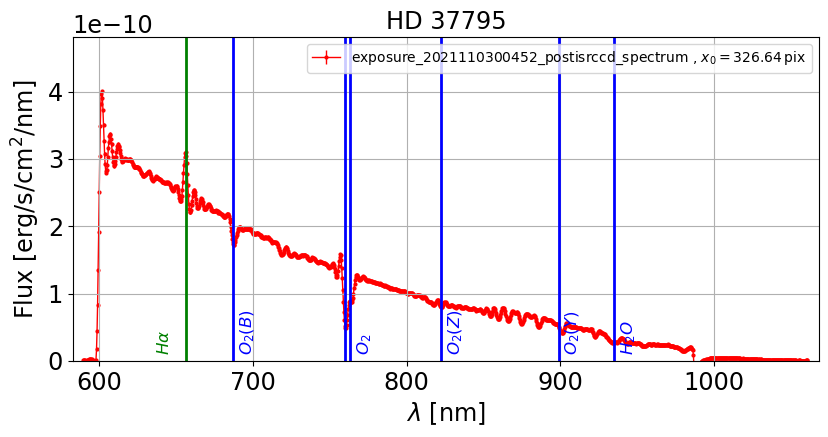

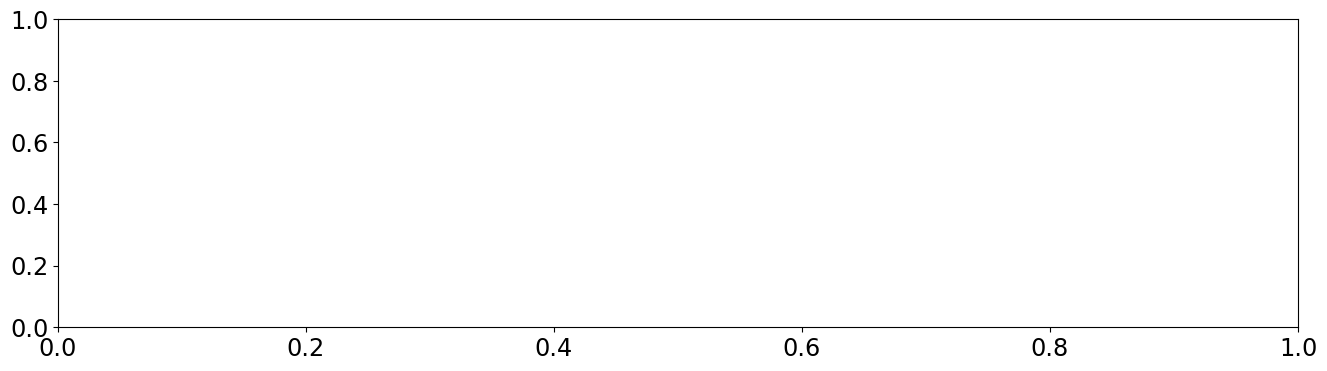

	 	  SaveFigSpectraInPdf >>>>>>>>  spec num = 1, pagenum = 1/6.0, idx_inpage = 2, idx_fig = 3
No rebinning: parameters.REBIN is forced to 1.


<Figure size 1600x400 with 0 Axes>

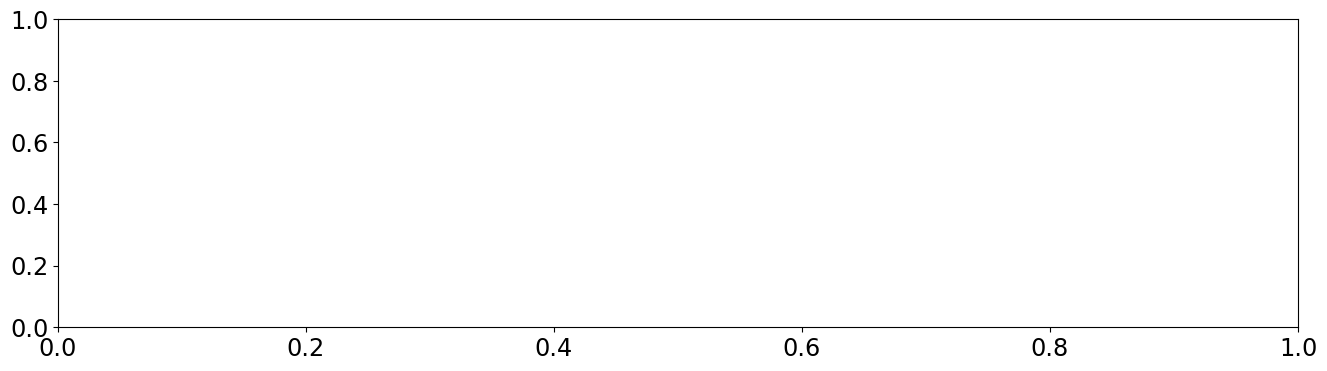

	 	  SaveFigSpectraInPdf >>>>>>>>  spec num = 2, pagenum = 1/6.0, idx_inpage = 3, idx_fig = 5
No rebinning: parameters.REBIN is forced to 1.


<Figure size 1600x400 with 0 Axes>

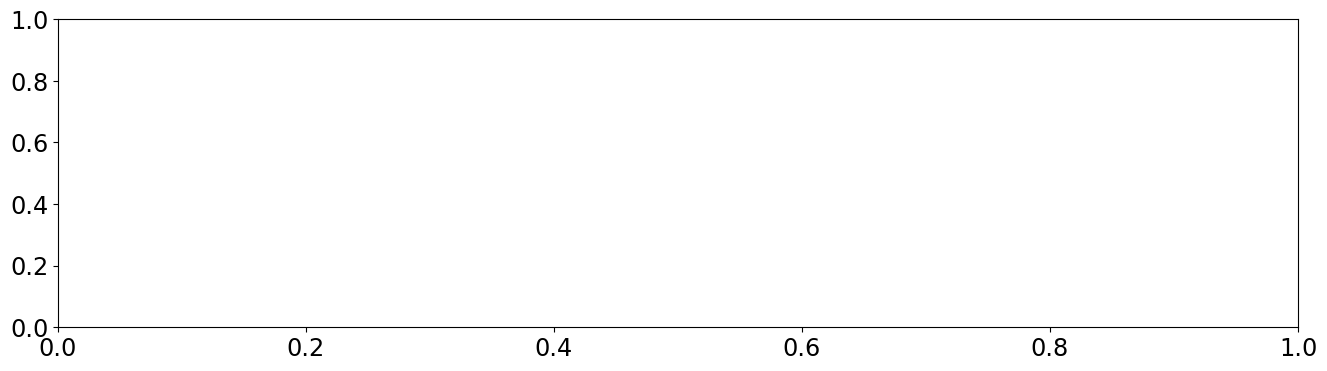

	 	  SaveFigSpectraInPdf >>>>>>>>  spec num = 3, pagenum = 1/6.0, idx_inpage = 4, idx_fig = 7
No rebinning: parameters.REBIN is forced to 1.


<Figure size 1600x400 with 0 Axes>

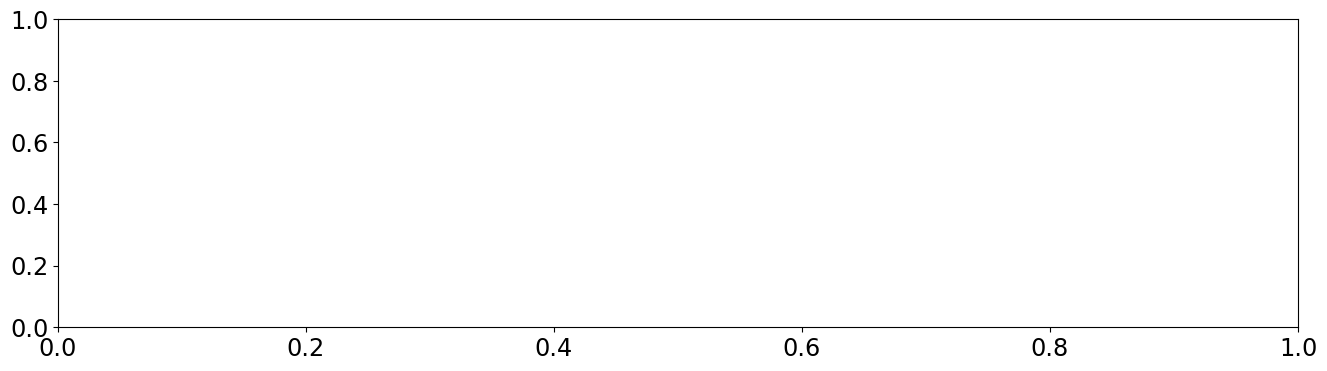

	 	  SaveFigSpectraInPdf >>>>>>>>  spec num = 4, pagenum = 1/6.0, idx_inpage = 5, idx_fig = 9
No rebinning: parameters.REBIN is forced to 1.


<Figure size 1600x400 with 0 Axes>

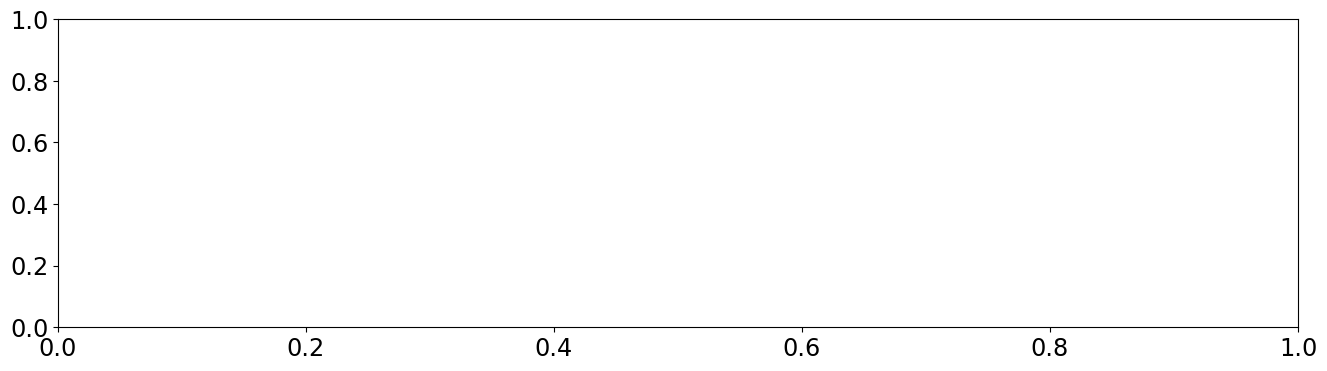

	 	  SaveFigSpectraInPdf >>>>>>>>  spec num = 5, pagenum = 2/6.0, idx_inpage = 1, idx_fig = 1
No rebinning: parameters.REBIN is forced to 1.


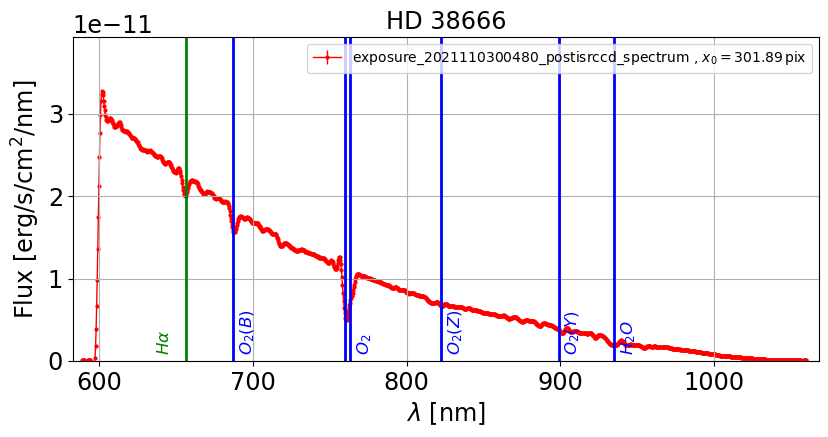

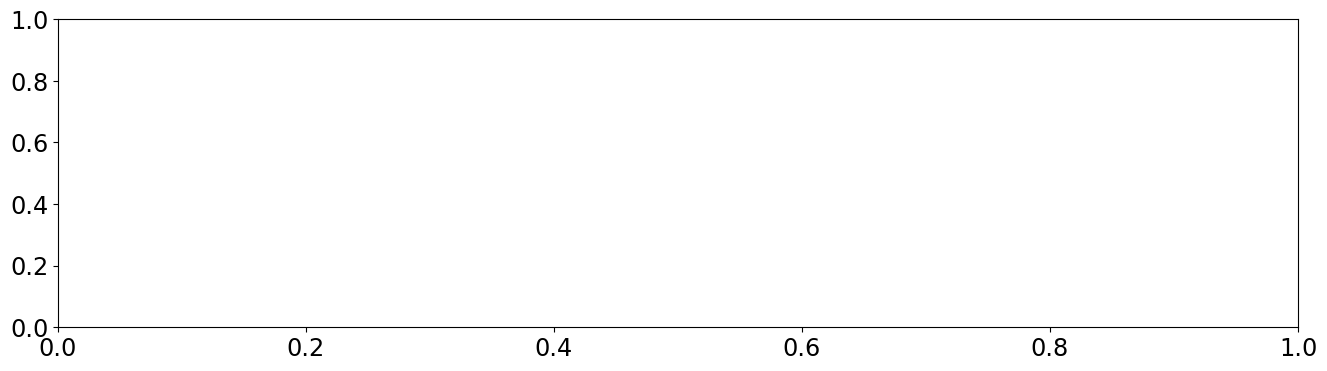

	 	  SaveFigSpectraInPdf >>>>>>>>  spec num = 6, pagenum = 2/6.0, idx_inpage = 2, idx_fig = 3
No rebinning: parameters.REBIN is forced to 1.


<Figure size 1600x400 with 0 Axes>

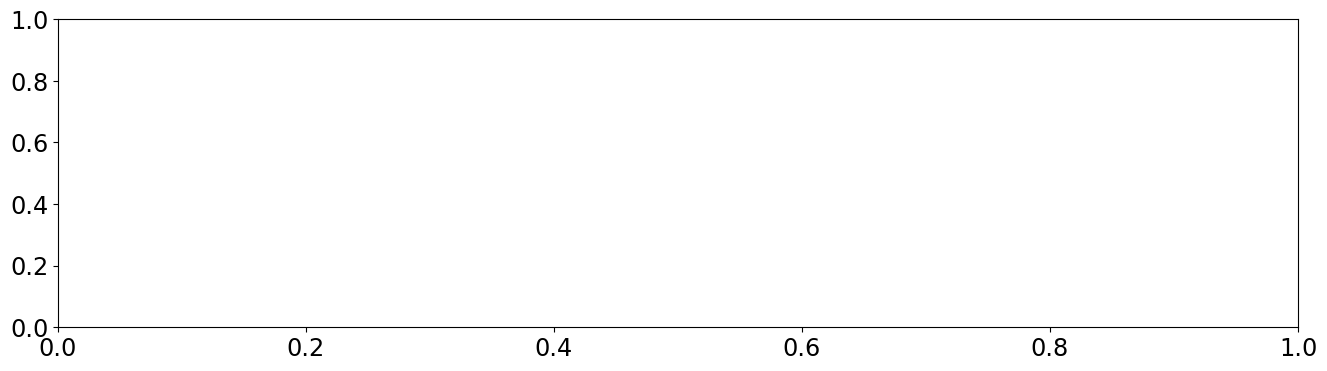

	 	  SaveFigSpectraInPdf >>>>>>>>  spec num = 7, pagenum = 2/6.0, idx_inpage = 3, idx_fig = 5
No rebinning: parameters.REBIN is forced to 1.


<Figure size 1600x400 with 0 Axes>

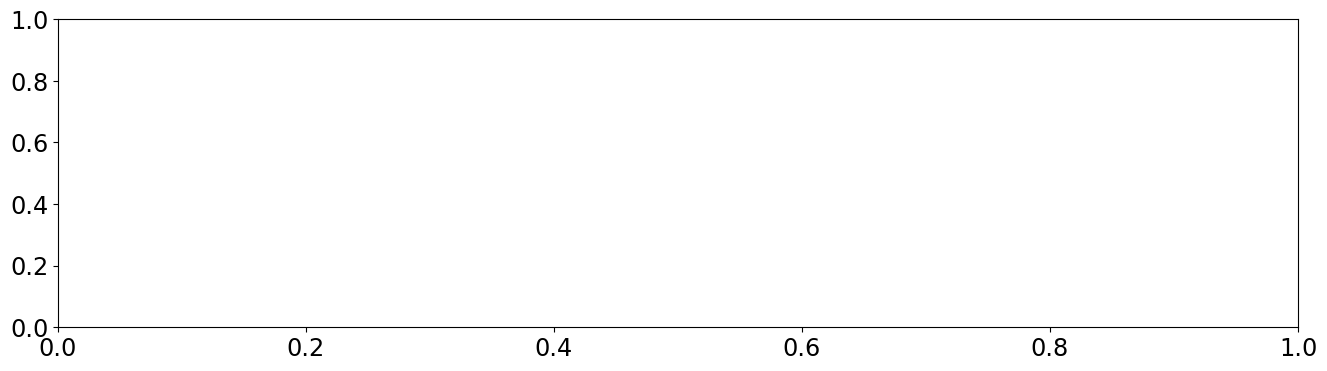

	 	  SaveFigSpectraInPdf >>>>>>>>  spec num = 8, pagenum = 2/6.0, idx_inpage = 4, idx_fig = 7
No rebinning: parameters.REBIN is forced to 1.


<Figure size 1600x400 with 0 Axes>

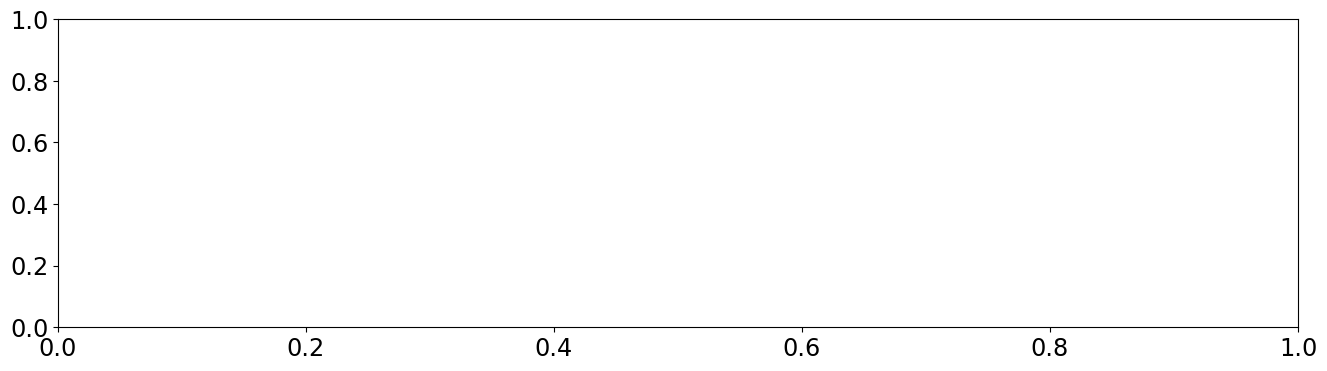

	 	  SaveFigSpectraInPdf >>>>>>>>  spec num = 9, pagenum = 2/6.0, idx_inpage = 5, idx_fig = 9
No rebinning: parameters.REBIN is forced to 1.


<Figure size 1600x400 with 0 Axes>

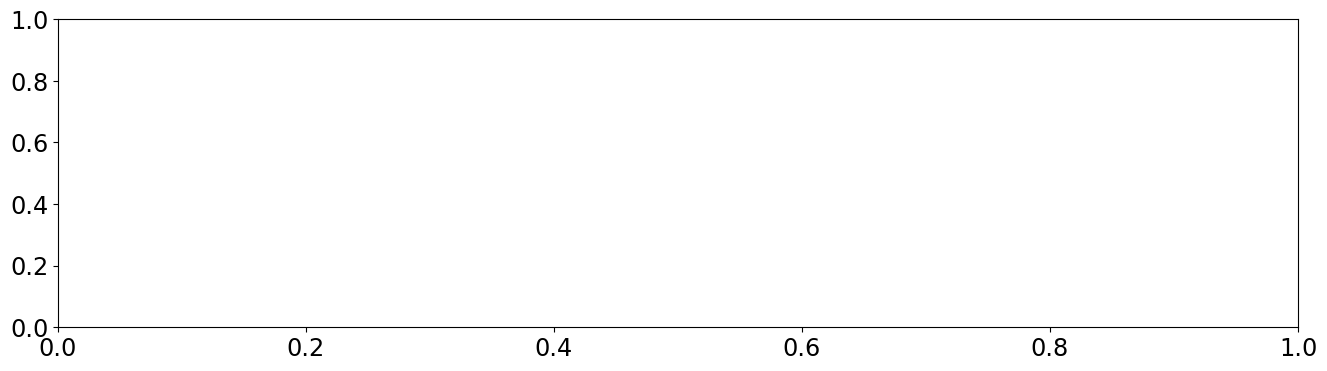

	 	  SaveFigSpectraInPdf >>>>>>>>  spec num = 10, pagenum = 3/6.0, idx_inpage = 1, idx_fig = 1
No rebinning: parameters.REBIN is forced to 1.


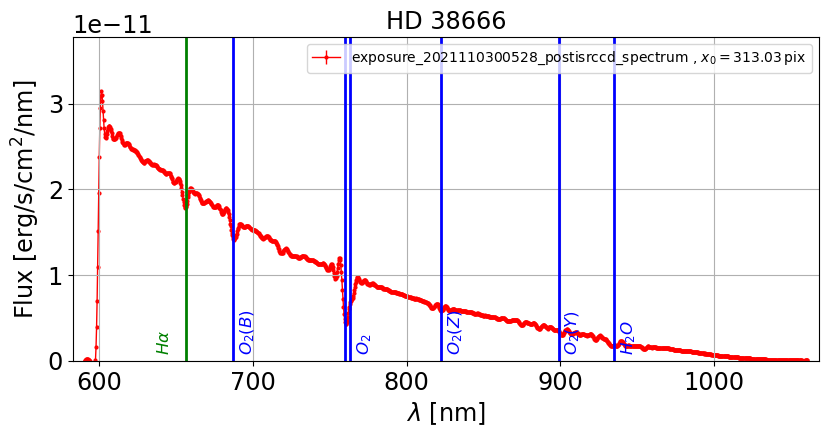

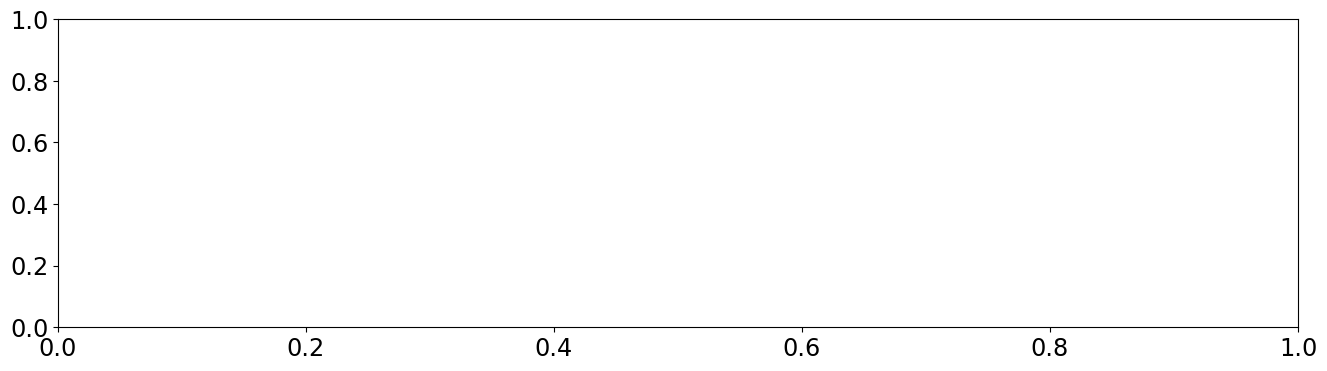

	 	  SaveFigSpectraInPdf >>>>>>>>  spec num = 11, pagenum = 3/6.0, idx_inpage = 2, idx_fig = 3
No rebinning: parameters.REBIN is forced to 1.


<Figure size 1600x400 with 0 Axes>

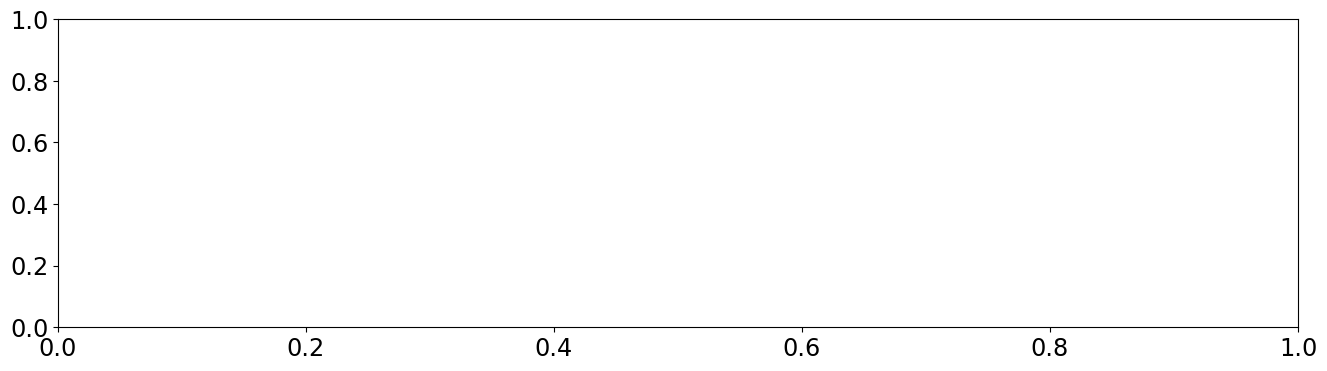

	 	  SaveFigSpectraInPdf >>>>>>>>  spec num = 12, pagenum = 3/6.0, idx_inpage = 3, idx_fig = 5
No rebinning: parameters.REBIN is forced to 1.


<Figure size 1600x400 with 0 Axes>

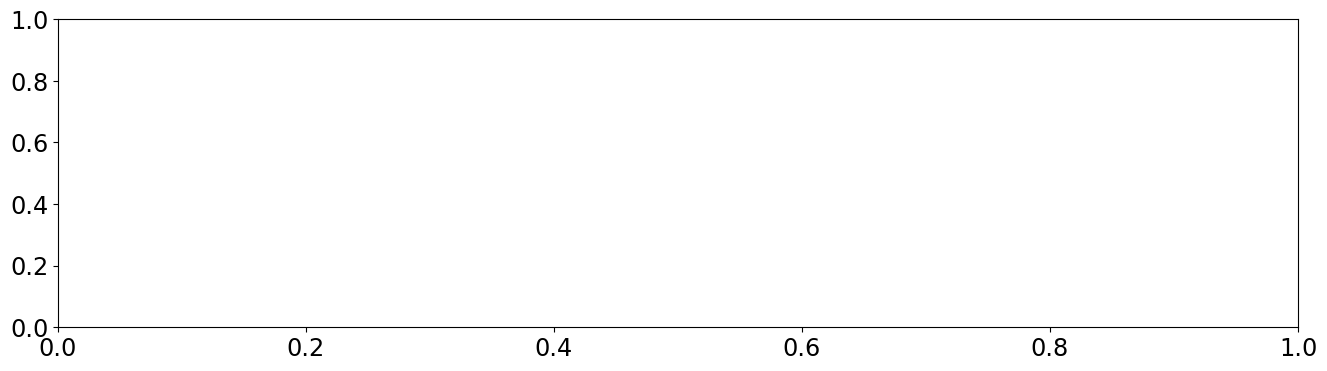

	 	  SaveFigSpectraInPdf >>>>>>>>  spec num = 13, pagenum = 3/6.0, idx_inpage = 4, idx_fig = 7
No rebinning: parameters.REBIN is forced to 1.


<Figure size 1600x400 with 0 Axes>

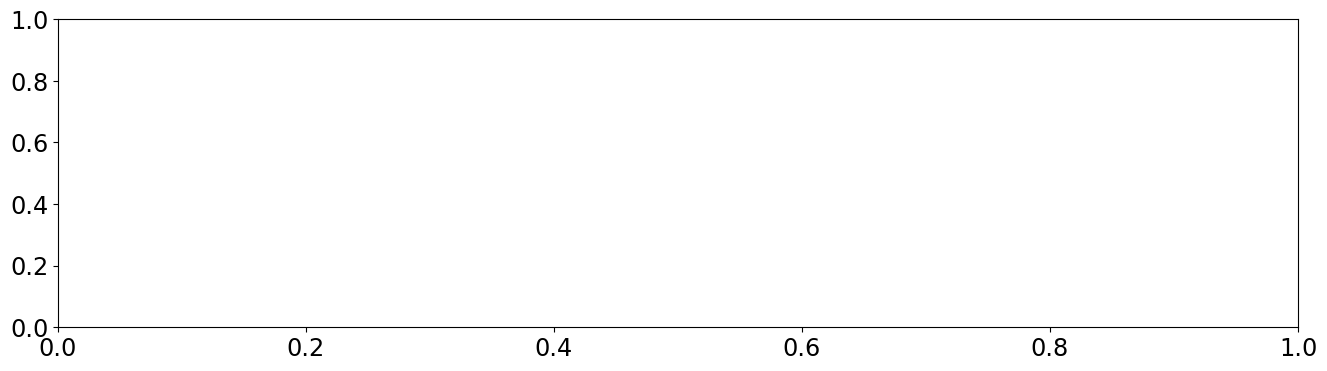

	 	  SaveFigSpectraInPdf >>>>>>>>  spec num = 14, pagenum = 3/6.0, idx_inpage = 5, idx_fig = 9
No rebinning: parameters.REBIN is forced to 1.


<Figure size 1600x400 with 0 Axes>

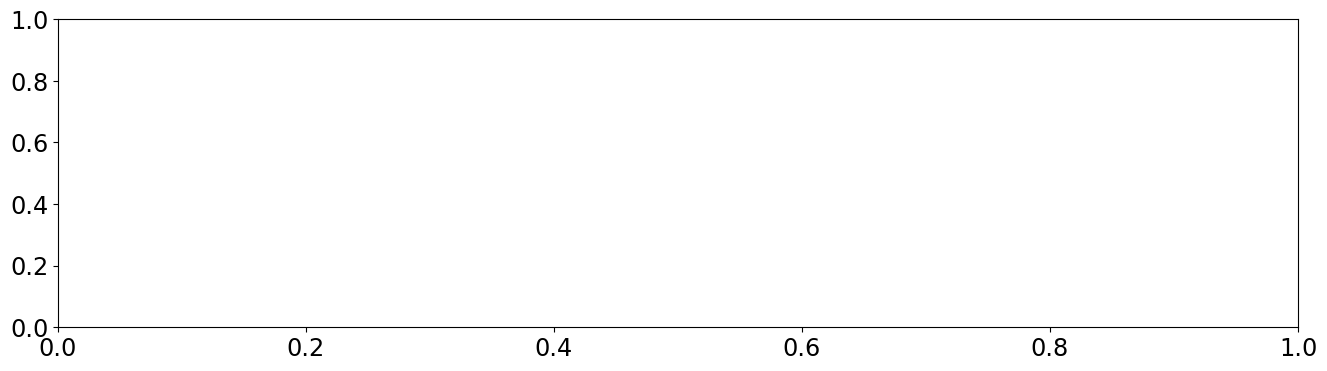

	 	  SaveFigSpectraInPdf >>>>>>>>  spec num = 15, pagenum = 4/6.0, idx_inpage = 1, idx_fig = 1
No rebinning: parameters.REBIN is forced to 1.


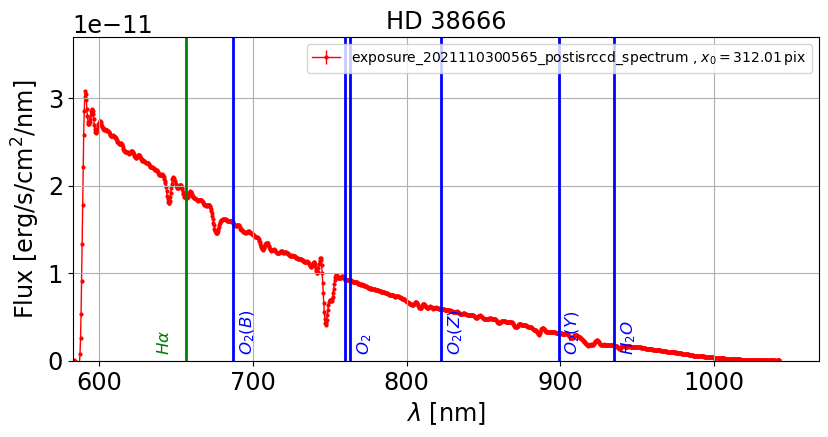

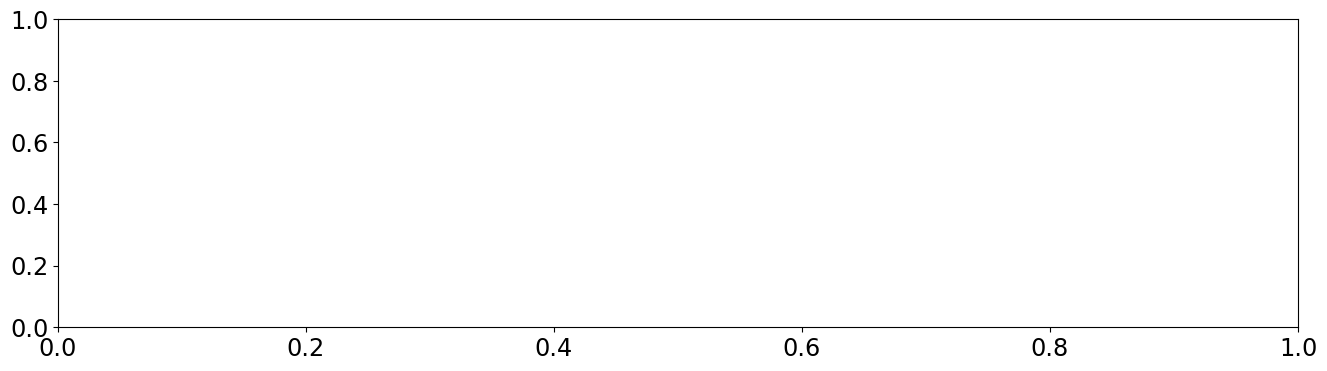

	 	  SaveFigSpectraInPdf >>>>>>>>  spec num = 16, pagenum = 4/6.0, idx_inpage = 2, idx_fig = 3
No rebinning: parameters.REBIN is forced to 1.


<Figure size 1600x400 with 0 Axes>

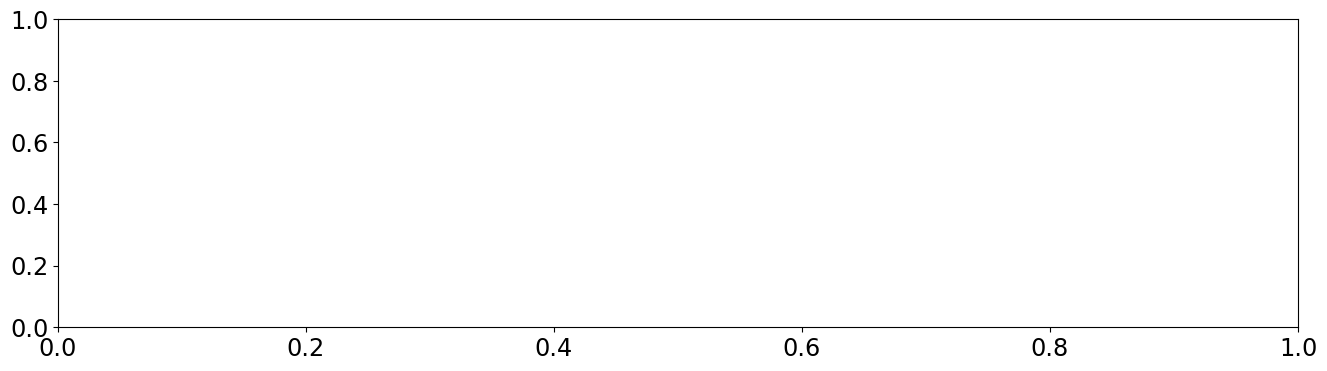

	 	  SaveFigSpectraInPdf >>>>>>>>  spec num = 17, pagenum = 4/6.0, idx_inpage = 3, idx_fig = 5
No rebinning: parameters.REBIN is forced to 1.


<Figure size 1600x400 with 0 Axes>

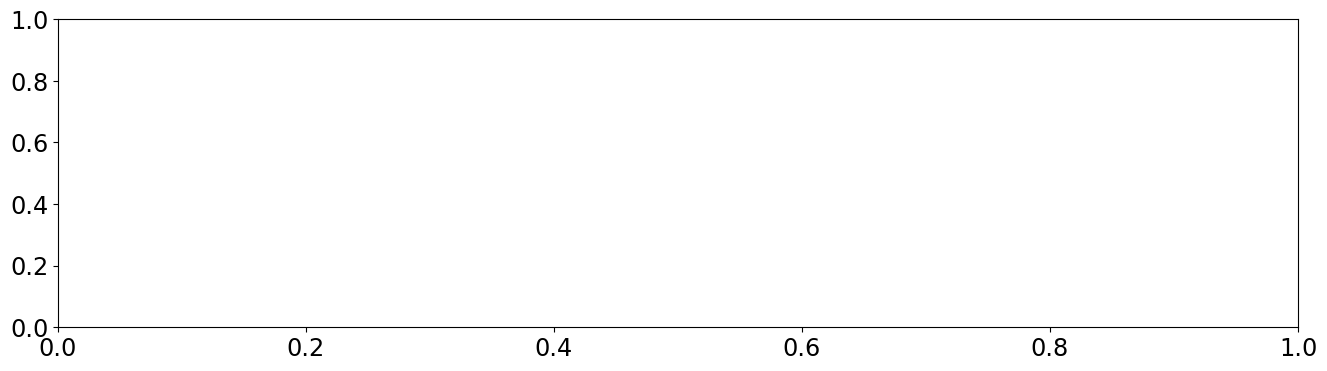

	 	  SaveFigSpectraInPdf >>>>>>>>  spec num = 18, pagenum = 4/6.0, idx_inpage = 4, idx_fig = 7
No rebinning: parameters.REBIN is forced to 1.


<Figure size 1600x400 with 0 Axes>

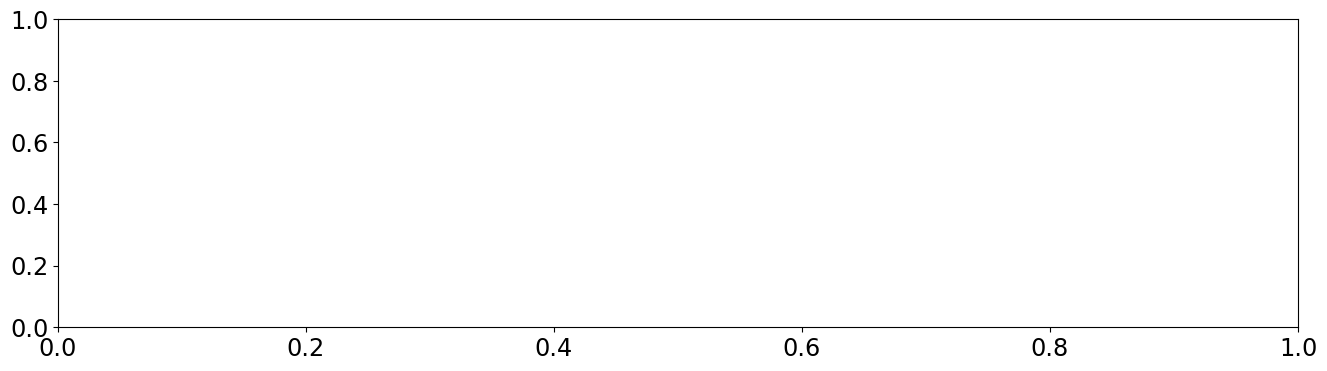

	 	  SaveFigSpectraInPdf >>>>>>>>  spec num = 19, pagenum = 4/6.0, idx_inpage = 5, idx_fig = 9
No rebinning: parameters.REBIN is forced to 1.


<Figure size 1600x400 with 0 Axes>

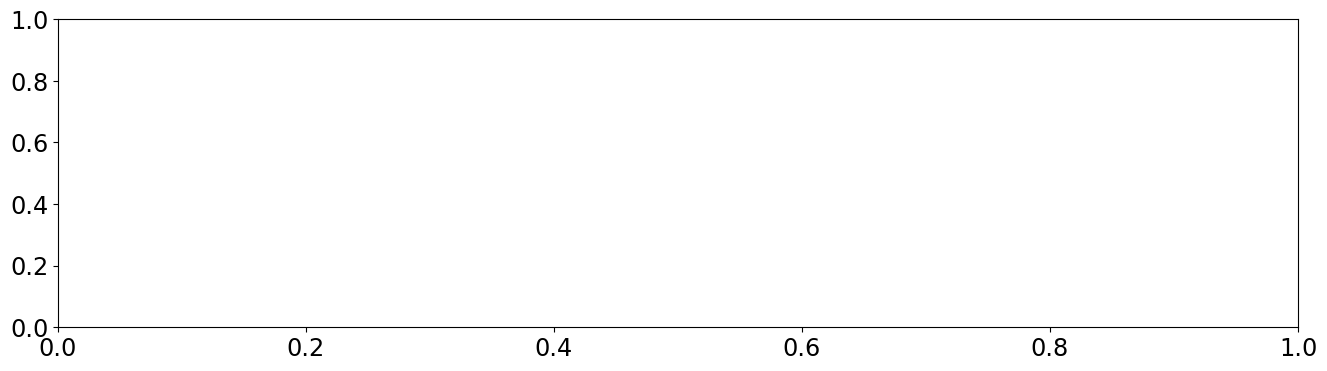

	 	  SaveFigSpectraInPdf >>>>>>>>  spec num = 20, pagenum = 5/6.0, idx_inpage = 1, idx_fig = 1
No rebinning: parameters.REBIN is forced to 1.


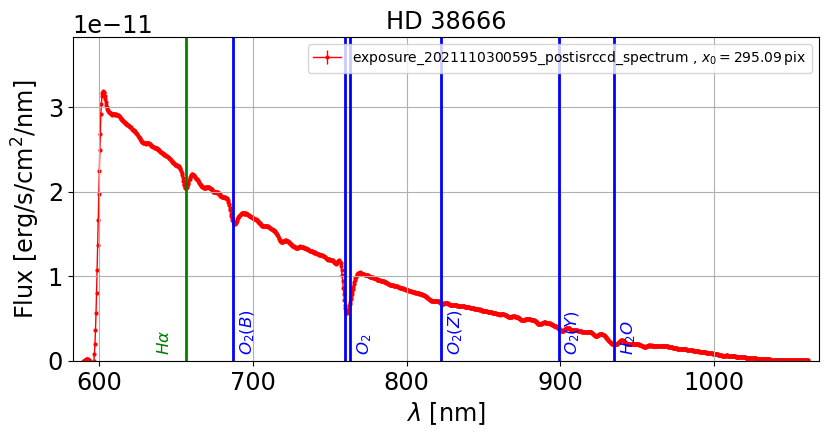

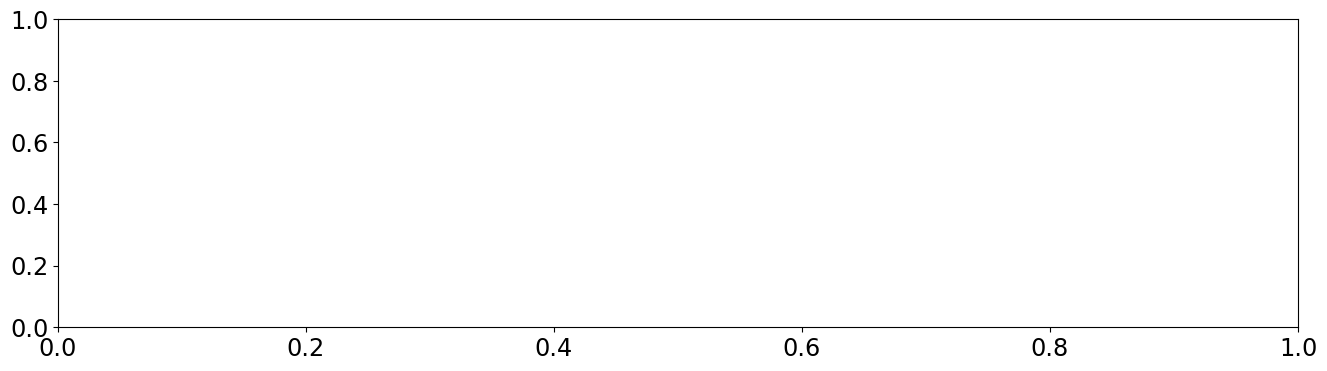

	 	  SaveFigSpectraInPdf >>>>>>>>  spec num = 21, pagenum = 5/6.0, idx_inpage = 2, idx_fig = 3
No rebinning: parameters.REBIN is forced to 1.


<Figure size 1600x400 with 0 Axes>

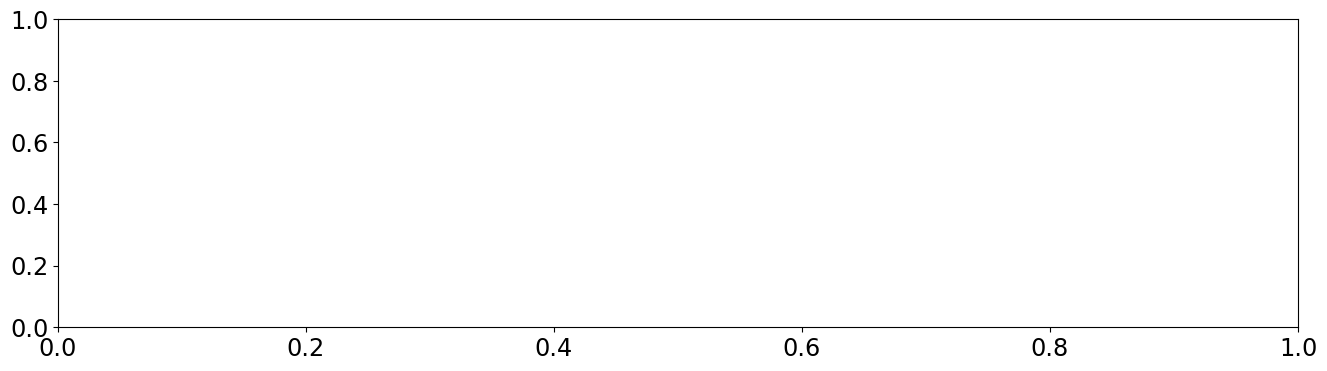

	 	  SaveFigSpectraInPdf >>>>>>>>  spec num = 22, pagenum = 5/6.0, idx_inpage = 3, idx_fig = 5
No rebinning: parameters.REBIN is forced to 1.


<Figure size 1600x400 with 0 Axes>

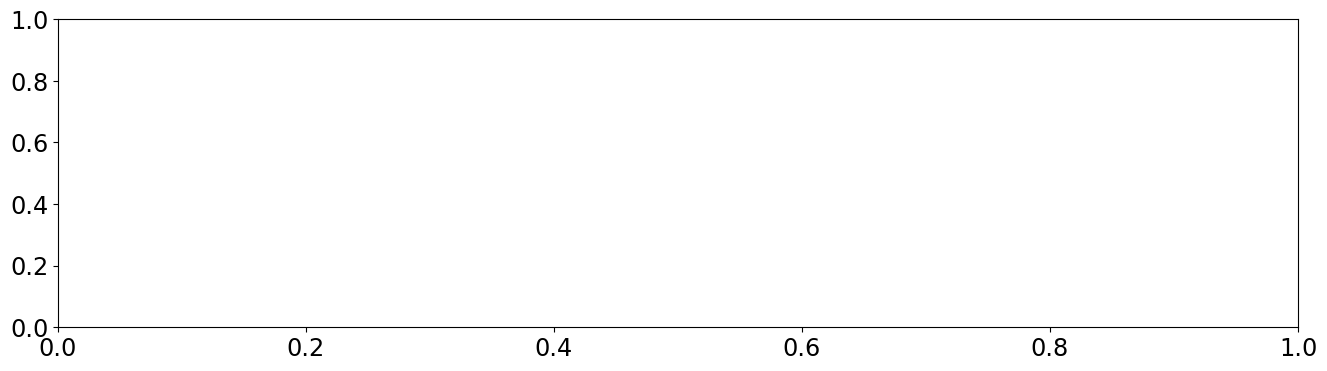

	 	  SaveFigSpectraInPdf >>>>>>>>  spec num = 23, pagenum = 5/6.0, idx_inpage = 4, idx_fig = 7
No rebinning: parameters.REBIN is forced to 1.


<Figure size 1600x400 with 0 Axes>

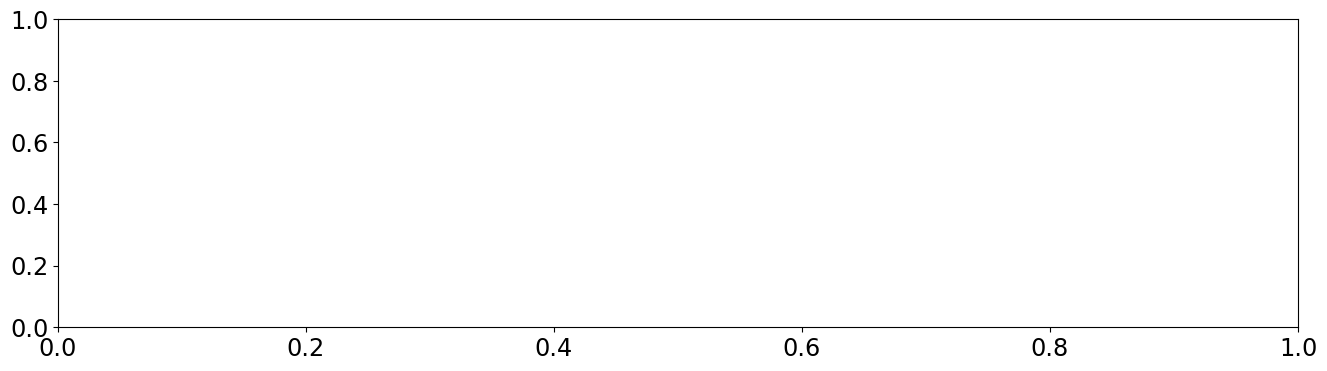

	 	  SaveFigSpectraInPdf >>>>>>>>  spec num = 24, pagenum = 5/6.0, idx_inpage = 5, idx_fig = 9
No rebinning: parameters.REBIN is forced to 1.


<Figure size 1600x400 with 0 Axes>

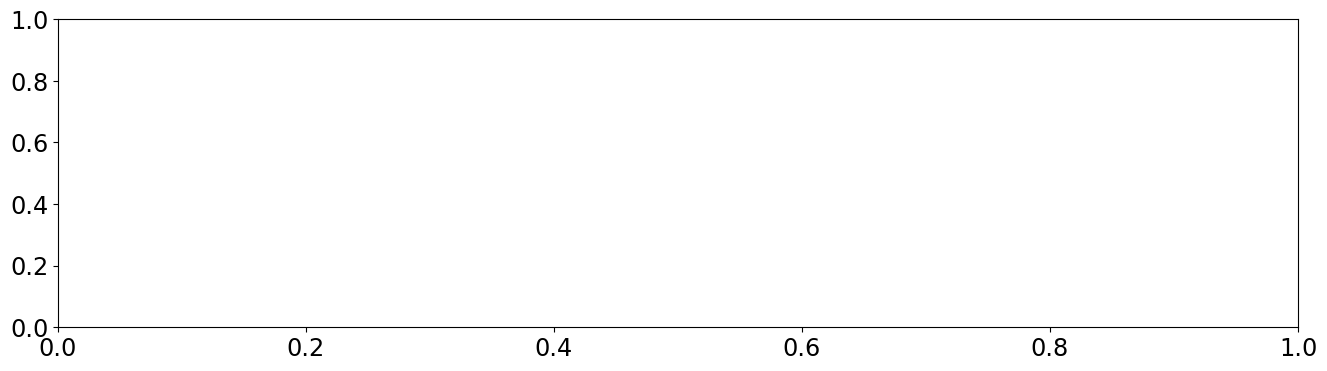

	 	  SaveFigSpectraInPdf >>>>>>>>  spec num = 25, pagenum = 6/6.0, idx_inpage = 1, idx_fig = 1
No rebinning: parameters.REBIN is forced to 1.


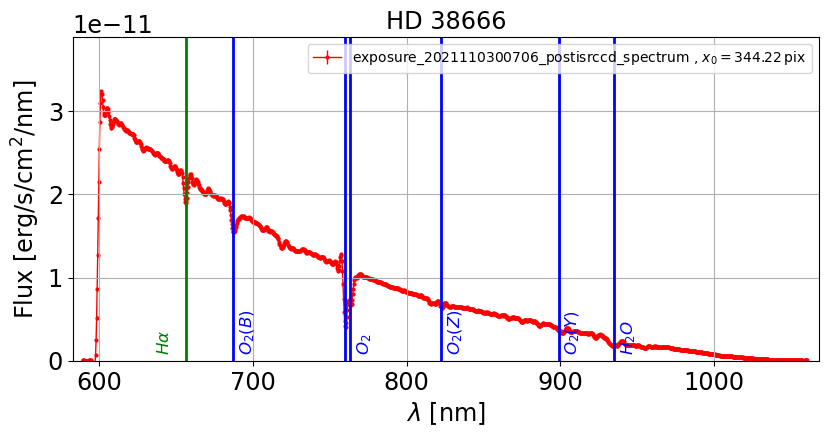

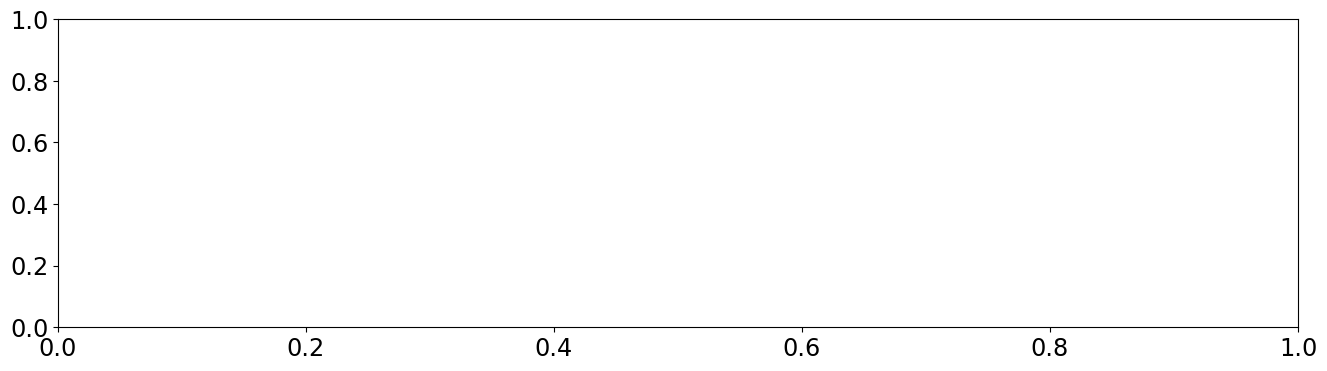

	 	  SaveFigSpectraInPdf >>>>>>>>  spec num = 26, pagenum = 6/6.0, idx_inpage = 2, idx_fig = 3
No rebinning: parameters.REBIN is forced to 1.


<Figure size 1600x400 with 0 Axes>

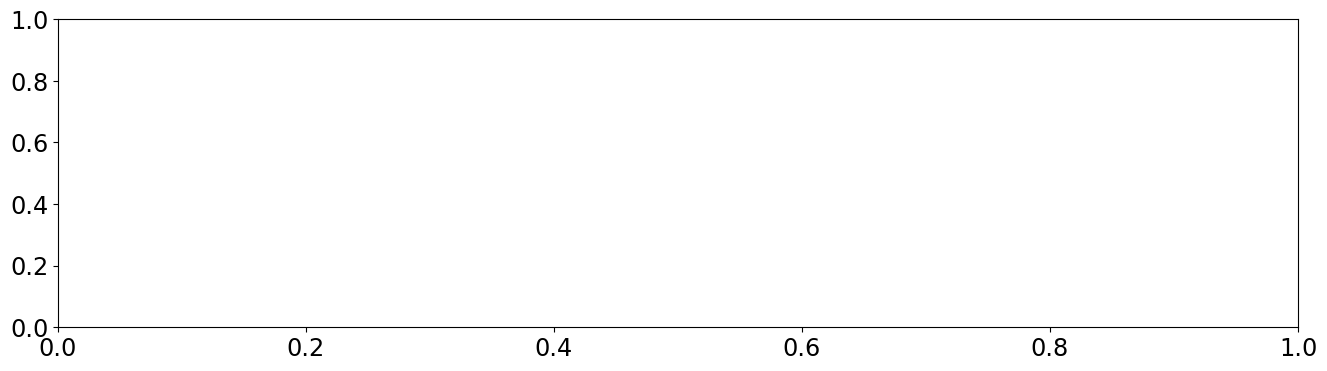

	 	  SaveFigSpectraInPdf >>>>>>>>  spec num = 27, pagenum = 6/6.0, idx_inpage = 3, idx_fig = 5
No rebinning: parameters.REBIN is forced to 1.


<Figure size 1600x400 with 0 Axes>

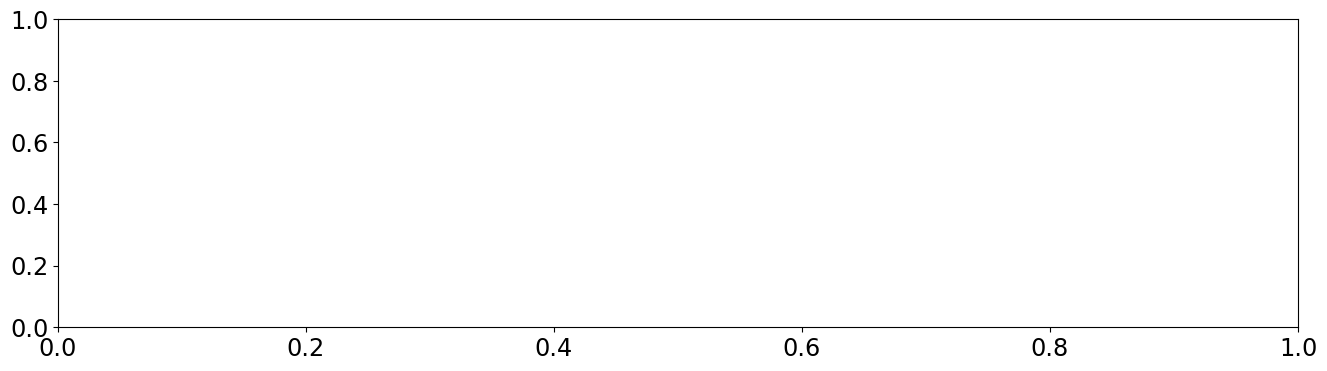

	 	  SaveFigSpectraInPdf >>>>>>>>  spec num = 28, pagenum = 6/6.0, idx_inpage = 4, idx_fig = 7
No rebinning: parameters.REBIN is forced to 1.


<Figure size 1600x400 with 0 Axes>

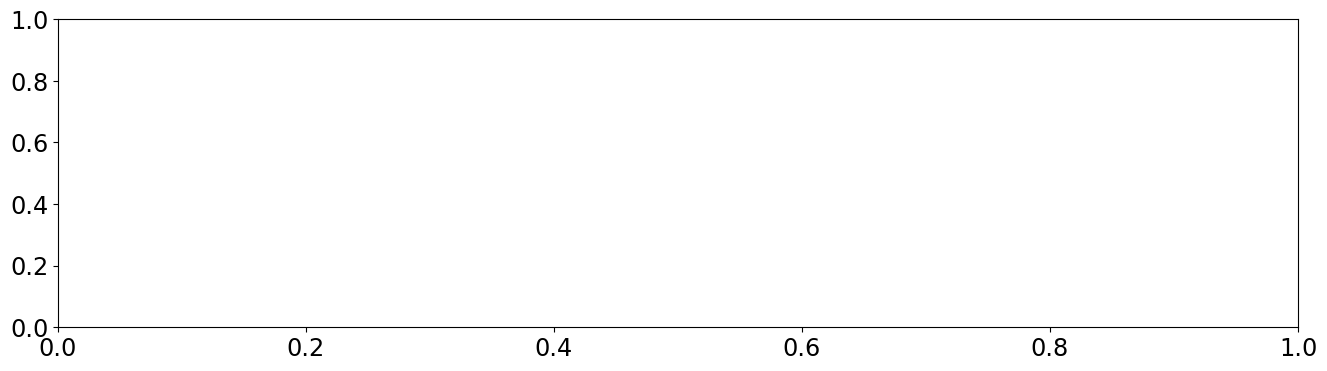

	 	  SaveFigSpectraInPdf >>>>>>>>  spec num = 29, pagenum = 6/6.0, idx_inpage = 5, idx_fig = 9
No rebinning: parameters.REBIN is forced to 1.


<Figure size 1600x400 with 0 Axes>

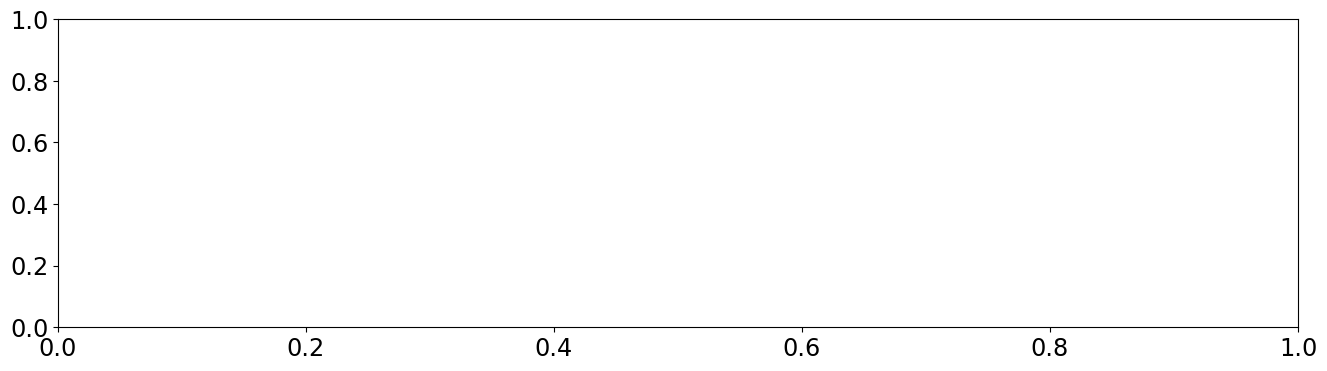

In [57]:
all_figs = SaveFigSpectraInPdf(nbspecperpage=5)

### Summary spectra

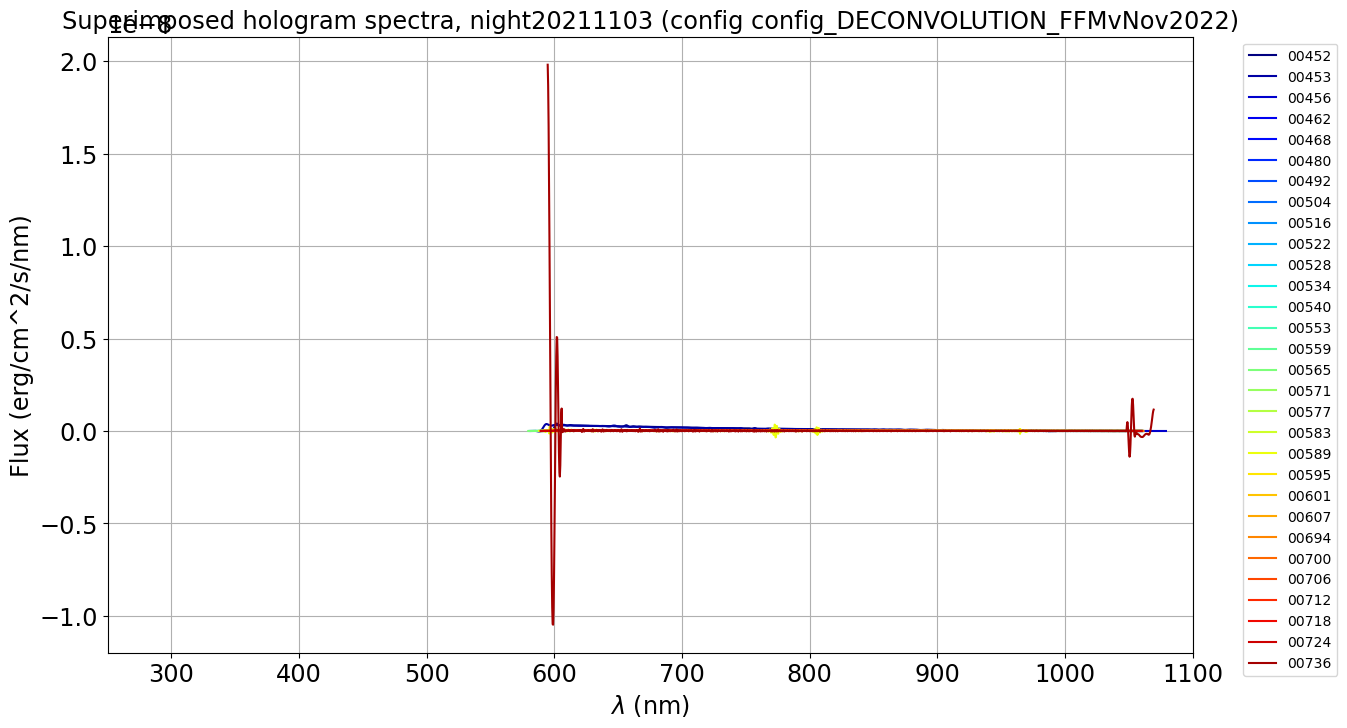

In [58]:
thetitle = f"Superimposed hologram spectra, night{DATE} (config {configdir})"
sumfig = SaveFigSpectraSummaryInPdf(all_lambdas,all_data,all_num,delta=0, thetitle=thetitle)

In [59]:
all_figs.append(sumfig)

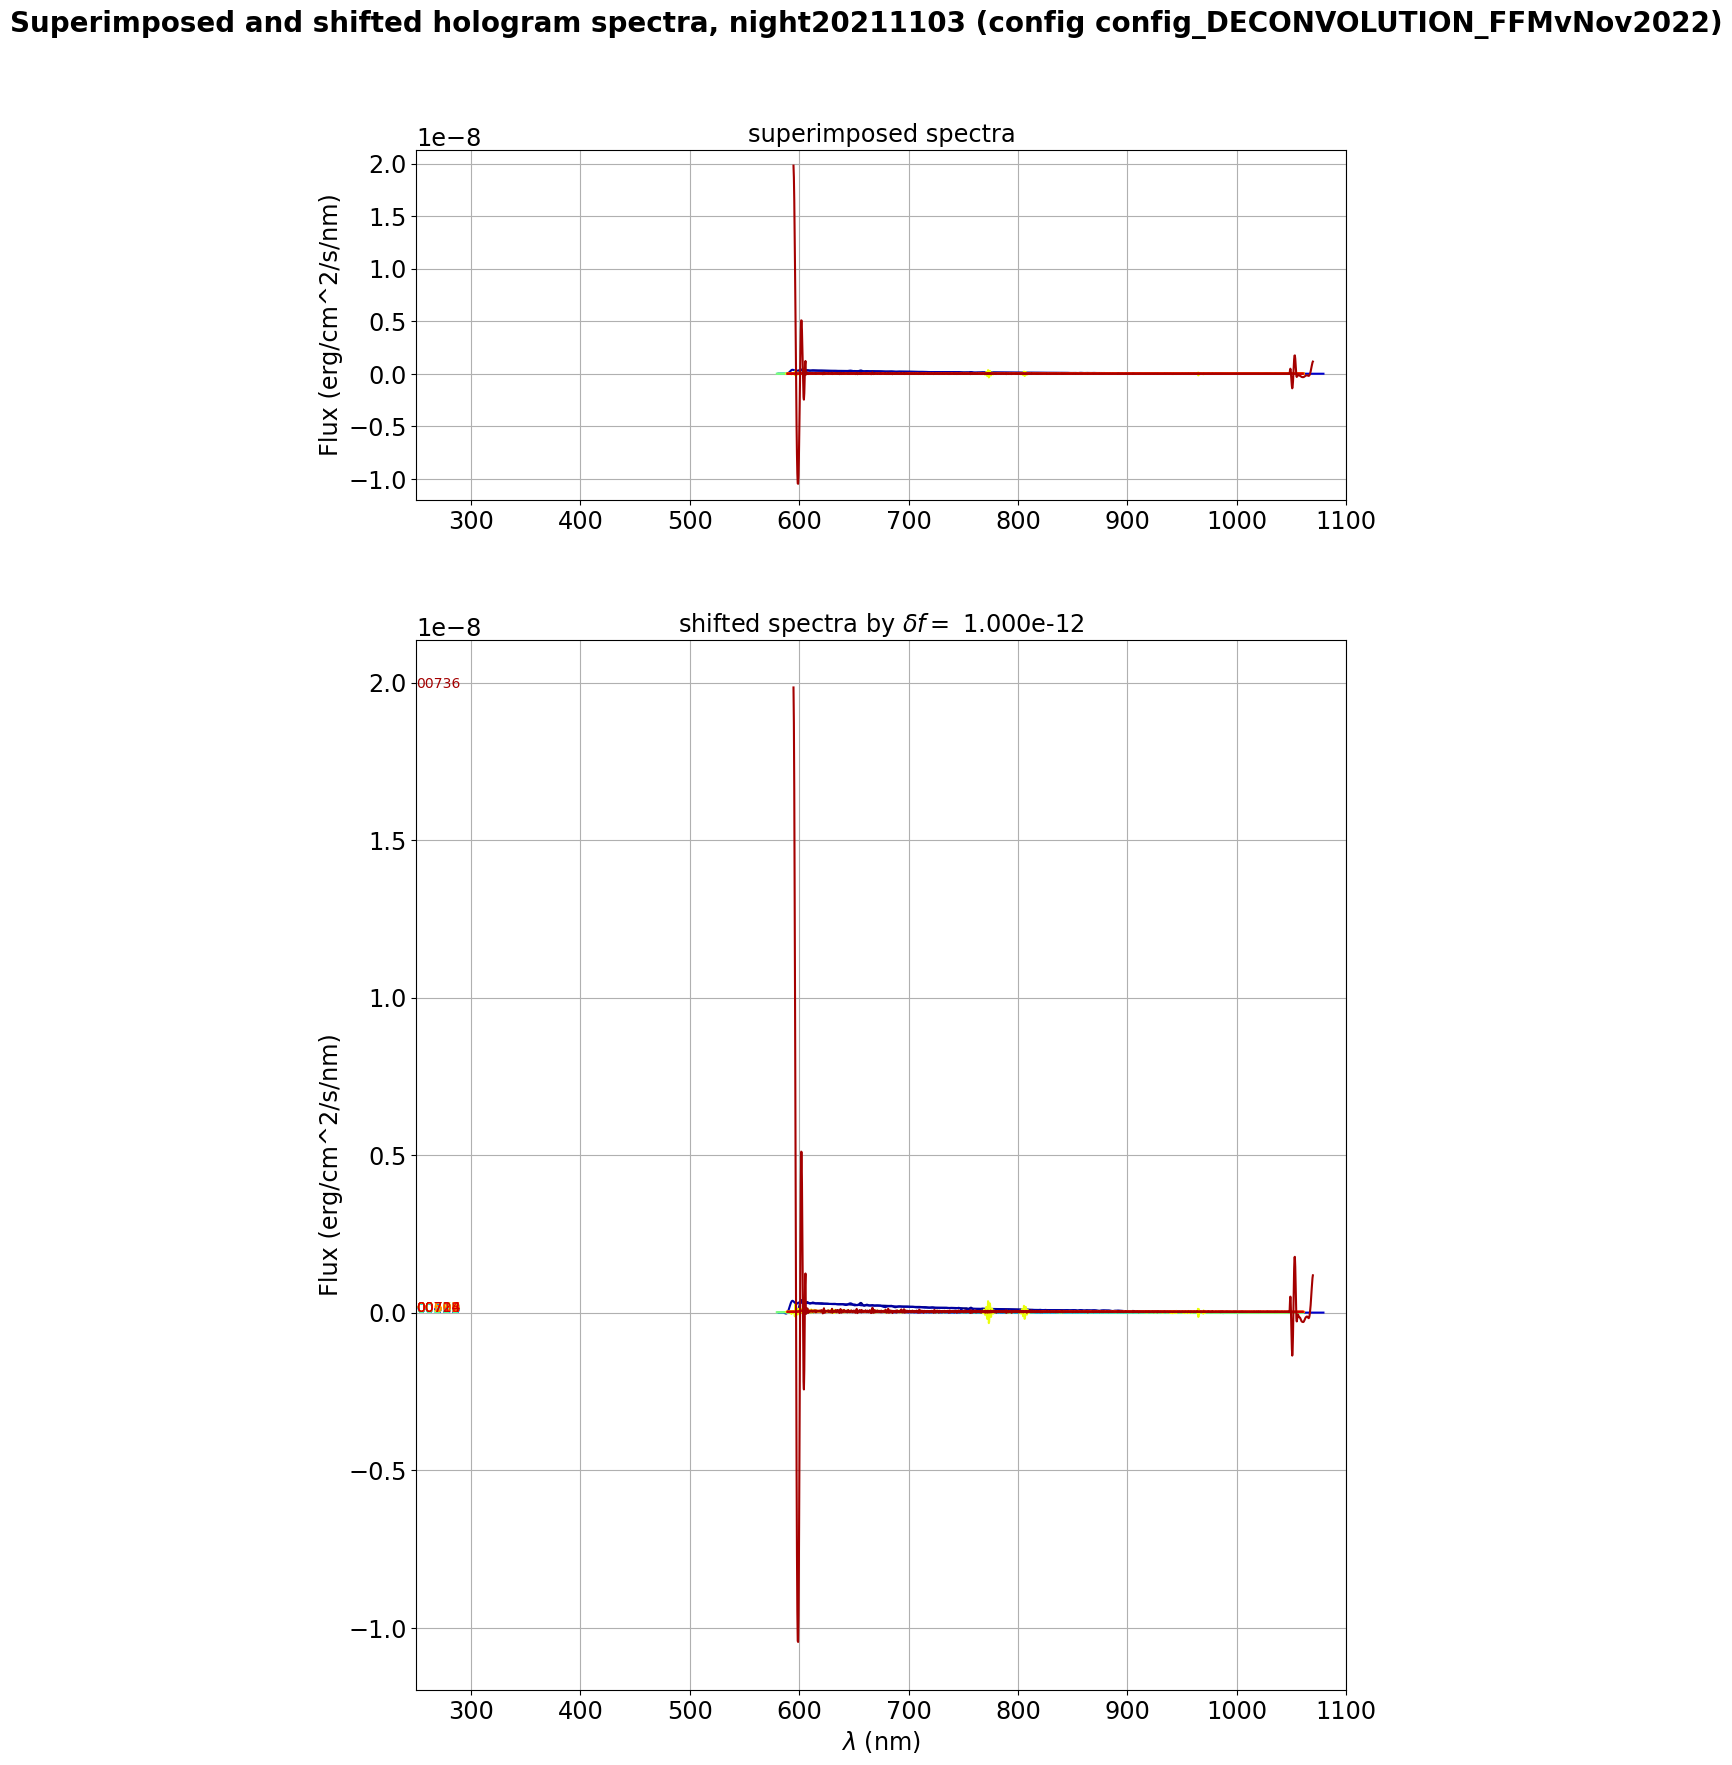

In [60]:
thetitle2 = f"Superimposed and shifted hologram spectra, night{DATE} (config {configdir})"
sumfig2 = SaveFigSpectraSummaryBothInPdf(all_lambdas,all_data,all_num,delta=0.1e-11,thetitle=thetitle2)

In [61]:
all_figs.append(sumfig2)

### Save in pdf file

In [62]:
# Write all images in pdf files

#multipage_pdf_file = f'multipage_pdf_holo_{DATE}_{configdir}.pdf'
# gerate a multipage pdf:
#with PdfPages(multipage_pdf_file) as pdf:
#    for fig in all_figs:
#        pdf.savefig(fig)
#        plt.close()


## View one spectrum

3 ) exposure_2021110300462_postisrccd_spectrum.fits   /sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/FELH0600~holo4_003/config_DECONVOLUTION_FFMvNov2022/20211103/2021110300462/basespec/exposure_2021110300462_postisrccd_spectrum.fits
No rebinning: parameters.REBIN is forced to 1.


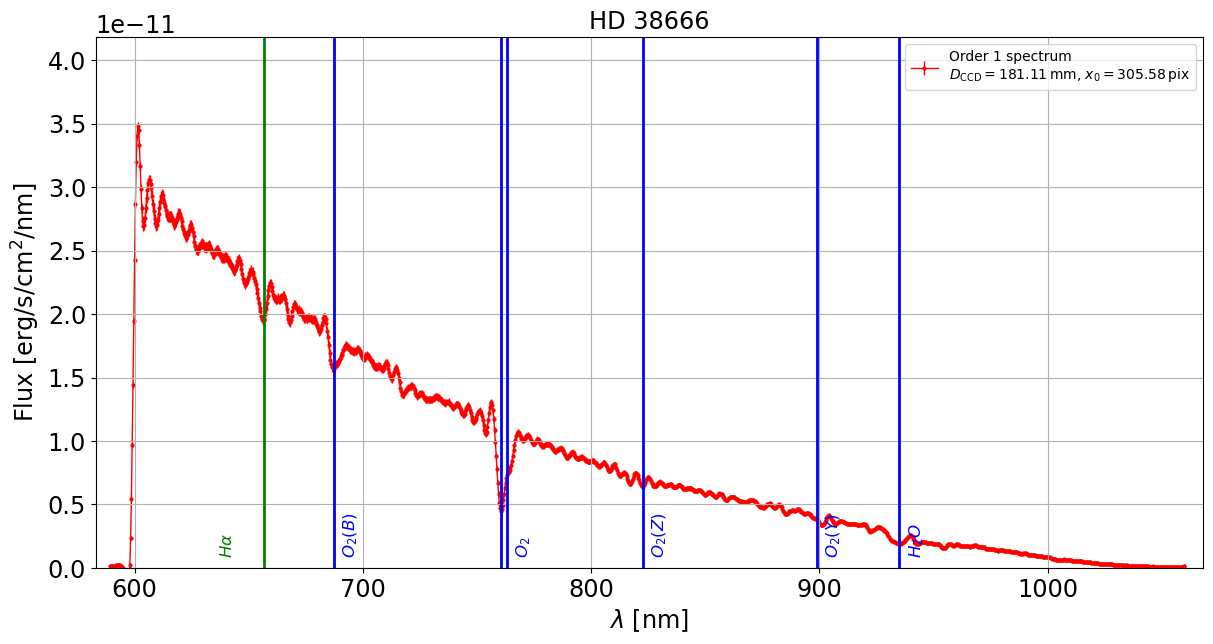

In [63]:
idx=3

fullfilename = all_good_spectra_spectrum_files[idx]
    
filename = os.path.basename(fullfilename)
print(idx,")",filename," ",fullfilename)
    
    
fig=plt.figure(figsize=(12,12))
ax1 = fig.add_subplot(2, 1, 1)
    
filename= os.path.basename(fullfilename)
tag=file_tag_forsorting(filename.split(".")[0])
all_num.append(tag)
    
   
     
s=Spectrum(fullfilename, config=config,fast_load=False)
label=filename.split('.')[0]+" "
#s.plot_spectrum(ax=ax1,force_lines=True,label=label)
s.plot_spectrum(ax=ax1,force_lines=True)

#ax2 = fig.add_subplot(1, 2, 2)
    
#fullfilename2=all_files_spectrogram[idx]
    
#s.load_spectrogram(fullfilename2)
#s.plot_spectrogram(ax=ax2,scale="log")
    

plt.show()
    
    
    
if FLAG_RECALIB: 
    ax2 = fig.add_subplot(2, 1, 2)
    print(" === RECALIBRATE lines === ")
    s.lines = lines_calib
    lambdas = calibrate_spectrum(s, with_adr=False)
    label=filename.split('.')[0]+" recalibrated"
    s.plot_spectrum(ax=ax2,force_lines=True,label=label)
    t=s.lines.print_detected_lines(print_table=True)
    print(t["Shift"])
    print(t["Chisq"])
        

In [64]:
all_figs.append(fig)

## Info

In [65]:
df_infos=pd.DataFrame(infos,columns=["idx","object","date_obs","airmass","temperature","pressure","humidity"])

In [66]:
df_infos.set_index('idx',inplace=True)

In [67]:
all_reftime=[ (Time(tt)-Time( df_infos["date_obs"].values[0])).to_value(u.hr) for tt in df_infos["date_obs"].values ]

In [68]:
all_reftime=np.array(all_reftime)

In [69]:
df_infos["reftime"]=all_reftime

In [70]:
NN = len(df_infos)

In [71]:
df_infos

,object,date_obs,airmass,temperature,pressure,humidity,reftime
idx,,,,,,,
0,HD 37795,2021-11-04T05:11:46.140,1.143972,7.2,740.40,33.0,0.000000
1,HD 37795,2021-11-04T05:12:19.436,1.142683,7.2,740.40,33.0,0.009249
2,HD 38666,2021-11-04T05:17:19.895,1.147055,7.3,740.35,34.0,0.092710
3,HD 38666,2021-11-04T05:25:27.533,1.129119,7.3,740.35,31.0,0.228165
4,HD 38666,2021-11-04T05:29:31.198,1.120449,7.4,740.30,32.0,0.295849
5,HD 38666,2021-11-04T05:37:42.404,1.104112,7.3,740.20,33.0,0.432296
6,HD 38666,2021-11-04T05:45:48.997,1.089339,7.4,740.10,29.0,0.567460
7,HD 38666,2021-11-04T05:54:01.298,1.075749,7.5,740.10,30.0,0.704211
8,HD 38666,2021-11-04T06:02:36.844,1.062903,7.4,740.00,28.0,0.847418


In [72]:
configmode

'FFMvNov2022'

In [73]:
#summary_file = f"summaryspectra_{DATE}_{configdir}.csv"
summary_file = f"summaryspectra_{DATE}-{filterdispersername}-{configdir}.csv"
df_infos.to_csv(summary_file)

Text(0.5, 1.0, 'airmassvs vs date')

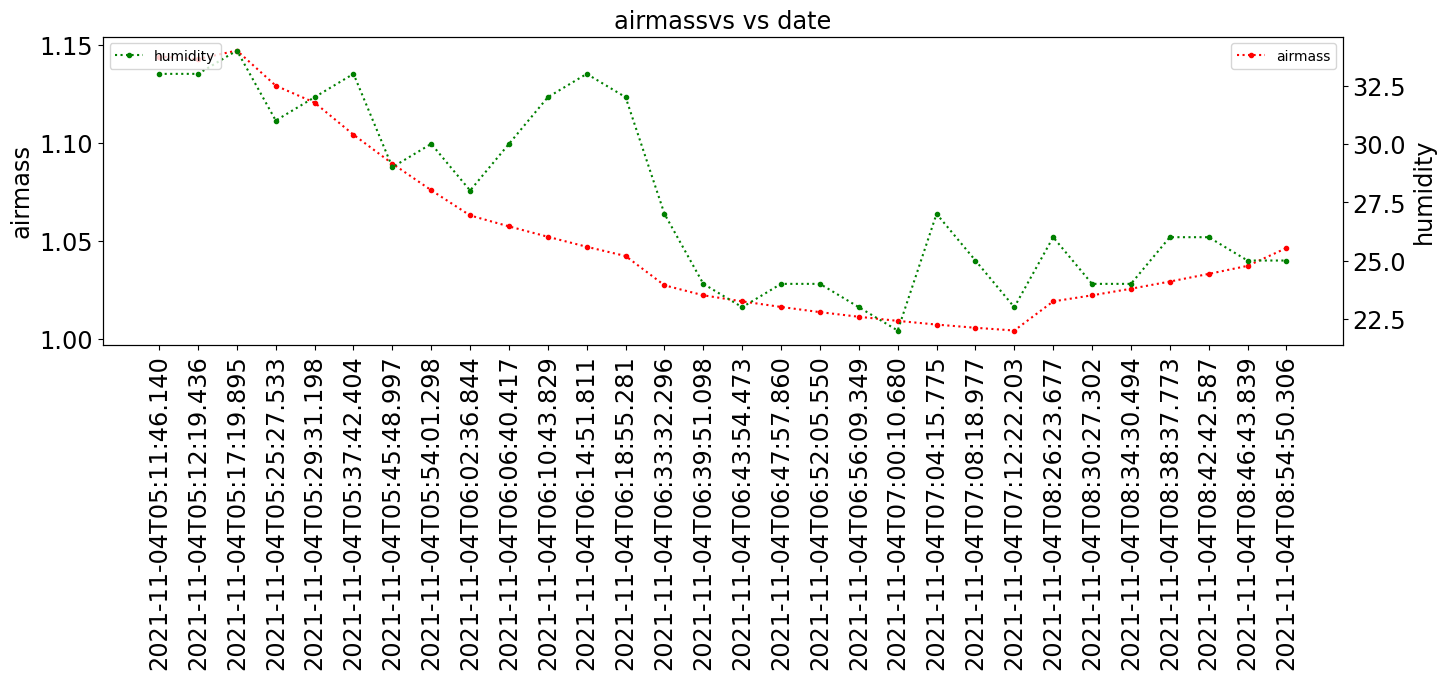

In [74]:
fig=plt.figure(figsize=(16,4))
#plt.xticks(rotation=90)
ax = fig.add_subplot(1, 1, 1)
ax.plot(df_infos['date_obs'], df_infos['airmass'],linestyle='dotted', marker='.',color="red",label="airmass")
#ax.set_xticks(rotation='vertical');
ax.xaxis.set_tick_params(rotation=90)
ax.set_ylabel("airmass")
ax.legend(loc="upper right")

ax2 = ax.twinx()
ax2.plot(df_infos['date_obs'], df_infos['humidity'],linestyle='dotted', marker='.',color="green",label="humidity")
ax2.set_ylabel("humidity")
ax2.legend(loc="upper left")
ax.set_title("airmassvs vs date")

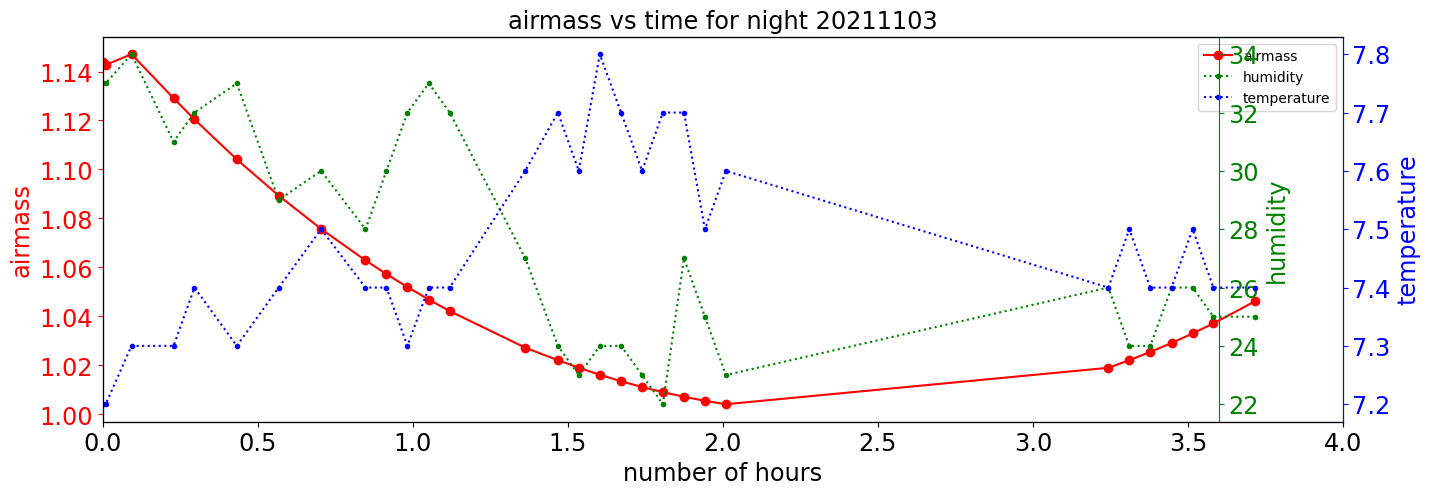

In [75]:
fig=plt.figure(figsize=(16,5))
#plt.xticks(rotation=90)
ax = fig.add_subplot(1, 1, 1)
p1,= ax.plot(df_infos['reftime'], df_infos['airmass'],marker="o",color="red",label="airmass")
#ax.set_xticks(rotation='vertical');
#ax.xaxis.set_tick_params(rotation=90)
ax.set_xlabel("number of hours")
ax.set_xlim(0,np.ceil(df_infos['reftime'].values.max()))
ax.set_ylabel("airmass")
ax2 = ax.twinx()
p2, = ax2.plot(df_infos['reftime'], df_infos['humidity'],linestyle='dotted', marker='.',color="green",label="humidity")
ax2.set_ylabel("humidity")
ax2.spines["right"].set_position(("axes", 0.9))

ax3 = ax.twinx()

ax3.spines["right"].set_position(("axes", 1.0))
p3, = ax3.plot(df_infos['reftime'], df_infos['temperature'],linestyle='dotted', marker='.',color="blue",label="temperature")
ax3.set_ylabel("temperature")

curves = [p1, p2, p3]
ax.legend(curves, [c.get_label() for c in curves])

ax.set_title(f"airmass vs time for night {DATE}")

ax.yaxis.label.set_color(p1.get_color())
ax2.yaxis.label.set_color(p2.get_color())
ax3.yaxis.label.set_color(p3.get_color())

ax2.spines["right"].set_edgecolor(p2.get_color())
ax3.spines["right"].set_edgecolor(p3.get_color())

ax.tick_params(axis='y', colors=p1.get_color())
ax2.tick_params(axis='y', colors=p2.get_color())
ax3.tick_params(axis='y', colors=p3.get_color())
plt.show()


In [76]:
all_figs.append(fig)

# Header info

In [77]:
NN=len(all_good_spectra_spectrum_files)

all_rebin=np.zeros(NN)
all_targetx=np.zeros(NN)
all_targety=np.zeros(NN)
all_rotangle=np.zeros(NN)
all_d2ccd=np.zeros(NN)
all_pixshift=np.zeros(NN)
all_chi2_fit=np.zeros(NN)
all_a2_fit=np.zeros(NN)
all_lbda_ref=np.zeros(NN)
all_tagnumber=np.zeros(NN)


for idx in range(NN):
    
    fullfilename=all_good_spectra_spectrum_files[idx]
    
    filename= os.path.basename(fullfilename)
    hdul=fits.open(fullfilename)
    header=hdul[0].header
    tagnum=str(all_num[idx])
    
    #ROTANGLE=  -0.1367006901184345 / [deg] angle of the dispersion axis             
    #D2CCD   =    179.6778868175837 / [mm] distance between disperser and CCD        
    #TARGETX =    315.9547462941386 / target position on X axis                      
    #TARGETY =    75.06785960446246 / target position on Y axis                      
    #LBDA_REF=    634.9155139280113                                                  
    #PIXSHIFT=  -0.9996981508176748                                                  
    #CHI2_FIT=    1.602115867259752                                                  
    #A2_FIT  =                  1.0                                                  
    #REBIN   =                    2 / original image rebinning factor to get spectrum
    
    rebin=header["REBIN"]
    targetx=header["TARGETX"]*rebin
    targety=header["TARGETY"]*rebin
    rotangle=header["ROTANGLE"]
    d2ccd=header["D2CCD"]
    pixshift=header["PIXSHIFT"]
    
    if header.get("CHI2_FIT") != None:
        chi2_fit=header["CHI2_FIT"]
    else:
        chi2_fit= -1
        
    if header.get("A2_FIT") != None:
        a2_fit=header["A2_FIT"]
    else:
        a2_fit=-1
    
    
    lbda_ref=header["LBDA_REF"]
    
    
    all_rebin[idx]=rebin
    all_targetx[idx]=targetx
    all_targety[idx]=targety
    all_rotangle[idx]=rotangle
    all_d2ccd[idx]=d2ccd
    all_pixshift[idx]=pixshift
    
    
    all_chi2_fit[idx]=chi2_fit
    all_a2_fit[idx]=a2_fit
    all_lbda_ref[idx]=lbda_ref
    all_tagnumber[idx]=tagnum
    

In [78]:
header

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                  -64 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                 1365                                                  
NAXIS2  =                    3                                                  
EXTEND  =                    T                                                  
ORIGIN  = 'LSST DM Header Service'                                              
TIMESYS = 'TAI     '                                                            
DATE    = '2021-11-04T08:54:50.306'                                             
DATE-OBS= '2021-11-04T08:54:50.306'                                             
DATE-BEG= '2021-11-04T08:54:54.377'                                             
DATE-END= '2021-11-04T08:55:24.615'                                             
MJD     =     59522.37141558

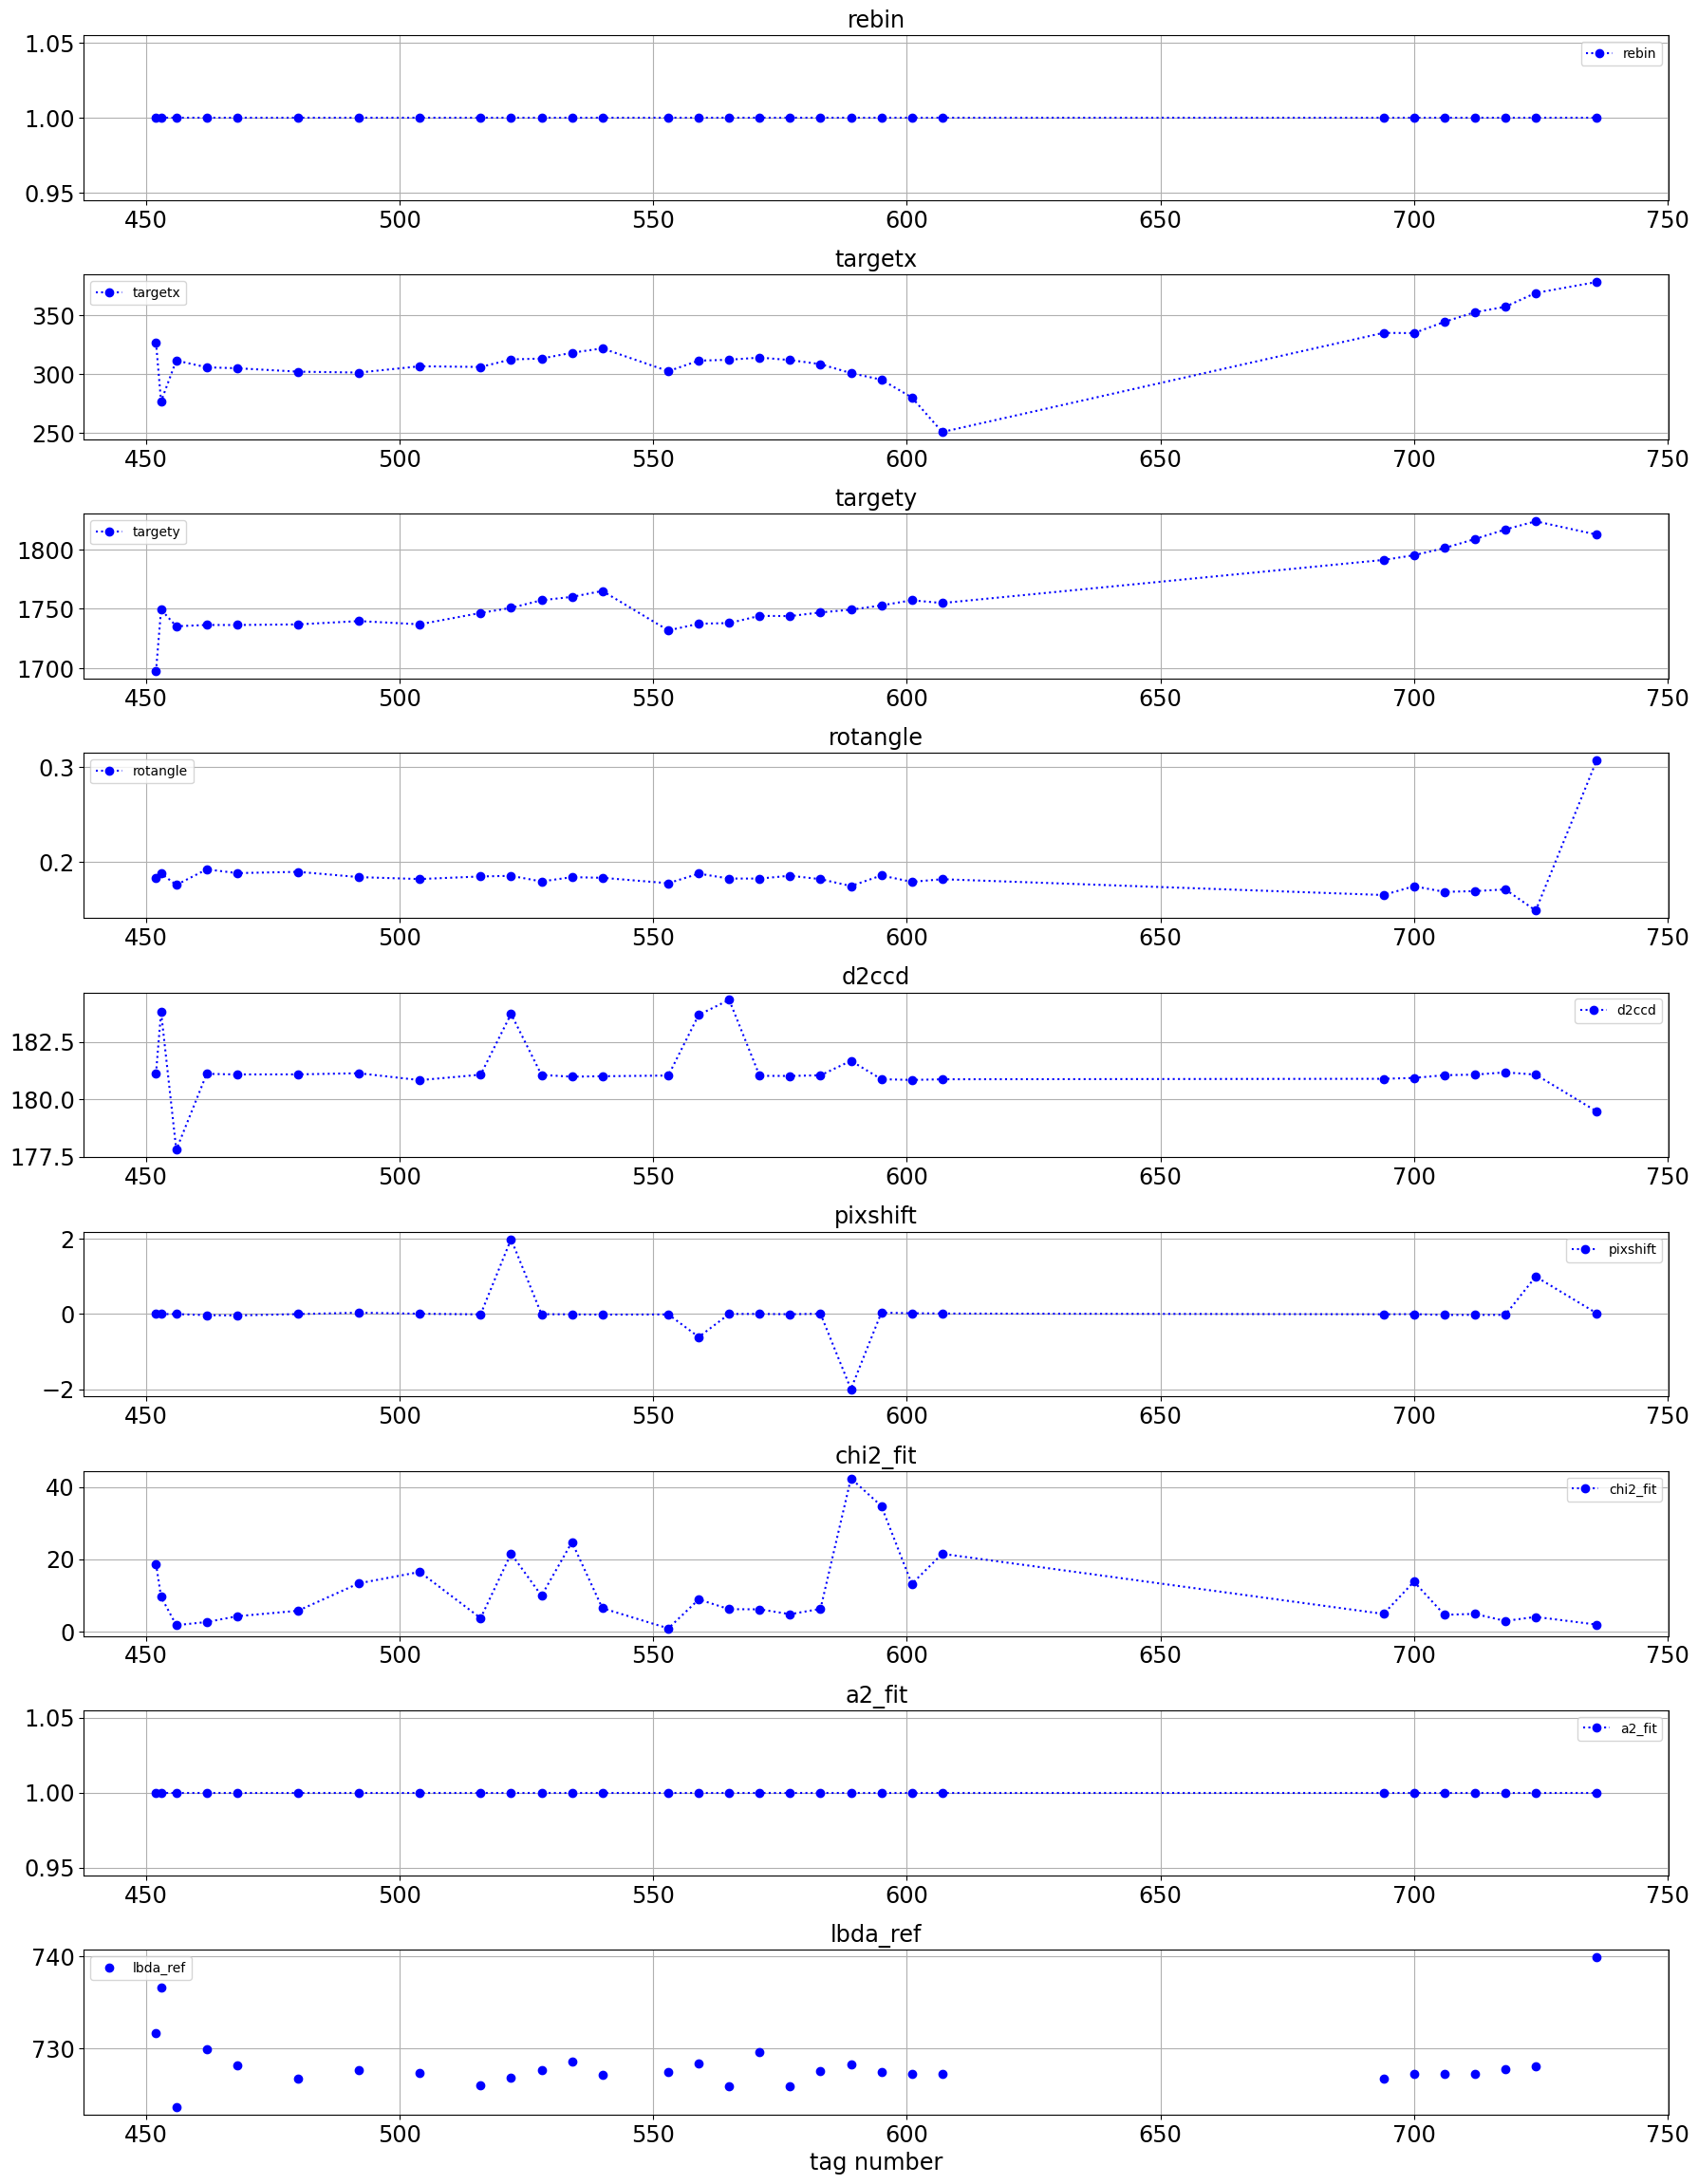

In [79]:
fig=plt.figure(figsize=(18,25))

# rebin
ax=fig.add_subplot(10,1,1)
ax.plot(all_tagnumber,all_rebin,"b:o",label="rebin")
ax.legend()
ax.grid()
ax.set_title("rebin")

#targetx
ax=fig.add_subplot(10,1,2)
ax.plot(all_tagnumber,all_targetx,"b:o",label="targetx")
ax.legend()
ax.grid()
ax.set_title("targetx")



#targety
ax=fig.add_subplot(10,1,3)
ax.plot(all_tagnumber,all_targety,"b:o",label="targety")
ax.legend()
ax.grid()
ax.set_title("targety")



#rotangle
ax=fig.add_subplot(10,1,4)
ax.plot(all_tagnumber,all_rotangle,"b:o",label="rotangle")
ax.legend()
ax.grid()
ax.set_title("rotangle")

#d2ccd
ax=fig.add_subplot(10,1,5)
ax.plot(all_tagnumber,all_d2ccd,"b:o",label="d2ccd")
ax.legend()
ax.grid()
ax.set_title("d2ccd")


#pixshift
ax=fig.add_subplot(10,1,6)
ax.plot(all_tagnumber,all_pixshift,"b:o",label="pixshift")
ax.legend()
ax.grid()
ax.set_title("pixshift")


#chi2_fit
ax=fig.add_subplot(10,1,7)
ax.plot(all_tagnumber,all_chi2_fit,"b:o",label="chi2_fit")
ax.legend()
ax.grid()
ax.set_title("chi2_fit")

#a2_fit
ax=fig.add_subplot(10,1,8)
ax.plot(all_tagnumber,all_a2_fit,"b:o",label="a2_fit")
ax.legend()
ax.grid()
ax.set_title("a2_fit")


#all_lbda_ref
ax=fig.add_subplot(10,1,9)
ax.plot(all_tagnumber,all_lbda_ref,"bo",label="lbda_ref")
ax.legend()
ax.grid()
ax.set_title("lbda_ref")

ax.set_xlabel("tag number")
plt.tight_layout()
plt.show()


In [80]:
all_figs.append(fig)

# Write in pdf file

In [81]:
# Write all images in pdf files
if FLAG_RECALIB:  
    multipage_pdf_file = f'multipage_pdf_holo-{DATE}-{filterdispersername}-{configdir}_recalib.pdf'
else:
    multipage_pdf_file = f'multipage_pdf_holo-{DATE}-{filterdispersername}-{configdir}.pdf'
    
# gerate a multipage pdf:
with PdfPages(multipage_pdf_file) as pdf:
    for fig in all_figs:
        pdf.savefig(fig)
        plt.close()

In [82]:
 multipage_pdf_file

'multipage_pdf_holo-20211103-FELH0600~holo4_003-config_DECONVOLUTION_FFMvNov2022.pdf'

# write in pickles files

In [83]:
all_out_data = {}

for idx in range(NN):
    if FLAG_ORDER2:
        thedata = {'number':all_tagnumber[idx],
               'object':df_infos.iloc[idx]['object'],
               'dateobs':df_infos.iloc[idx]['date_obs'],
               'refhour':df_infos.iloc[idx]['reftime'],
               'airmass':df_infos.iloc[idx]['airmass'], 
               'pressure':df_infos.iloc[idx]['pressure'], 
               'temperature':df_infos.iloc[idx]['temperature'], 
               'humidity':df_infos.iloc[idx]['humidity'], 
               'targetx_pix':all_targetx[idx],
               'targety_pix':all_targety[idx],
               'rotangle':all_rotangle[idx],
               'd2ccd':all_d2ccd[idx],
               'all_lambdas':all_lambdas[idx],
               'all_fluxes':all_data[idx],
               'all_fluxes_err':all_data_err[idx],
               'all_lambdas_order2':all_lambdas_order2[idx],
               'all_fluxes_order2':all_data_order2[idx],
               'all_fluxes_err_order2':all_data_err_order2[idx],
              }
    else:
        thedata = {'number':all_tagnumber[idx],
               'object':df_infos.iloc[idx]['object'],
               'dateobs':df_infos.iloc[idx]['date_obs'],
               'refhour':df_infos.iloc[idx]['reftime'],
               'airmass':df_infos.iloc[idx]['airmass'],
               'pressure':df_infos.iloc[idx]['pressure'], 
               'temperature':df_infos.iloc[idx]['temperature'], 
               'humidity':df_infos.iloc[idx]['humidity'], 
               'targetx_pix':all_targetx[idx],
               'targety_pix':all_targety[idx],
               'rotangle':all_rotangle[idx],
               'd2ccd':all_d2ccd[idx],
               'all_lambdas':all_lambdas[idx],
               'all_fluxes':all_data[idx],
               'all_fluxes_err':all_data_err[idx],
            }         
            
    all_out_data[os.path.basename(all_good_spectra_spectrum_files[idx])]=thedata


In [84]:
if FLAG_RECALIB: 
    pkl_outfilename=f'run-auxtel-holo-{DATE}-{filterdispersername}-{configdir}_recalib.pickle'
else:
    pkl_outfilename=f'run-auxtel-holo-{DATE}-{filterdispersername}-{configdir}.pickle'
    

with open(pkl_outfilename, 'wb') as pickle_file:
    pickle.dump(all_out_data,pickle_file)


In [85]:
pkl_infilename=pkl_outfilename

In [86]:
with open(pkl_infilename, 'rb') as pickle_file:
    content = pickle.load(pickle_file)


In [87]:
#content

In [88]:
# Get first value of dictionary
next(iter(content.items()))

('exposure_2021110300452_postisrccd_spectrum.fits',
 {'number': 452.0,
  'object': 'HD 37795',
  'dateobs': '2021-11-04T05:11:46.140',
  'refhour': 0.0,
  'airmass': 1.14397247903133,
  'pressure': 740.4,
  'temperature': 7.2,
  'humidity': 33.0,
  'targetx_pix': 326.6421441203045,
  'targety_pix': 1697.348904805918,
  'rotangle': 0.1830080086963601,
  'd2ccd': 181.1175156535786,
  'all_lambdas': array([ 589.72795204,  590.07747031,  590.42698332, ..., 1059.65618329,
         1059.99583417, 1060.33547592]),
  'all_fluxes': array([8.42539251e-13, 8.90355120e-13, 8.92880274e-13, ...,
         6.47163704e-13, 8.03625662e-13, 8.72638563e-13]),
  'all_fluxes_err': array([6.91257204e-13, 5.38364134e-13, 4.02965937e-13, ...,
         5.36649742e-14, 5.83339826e-14, 9.32423546e-14])})